## Port Call Trends Monitor - Methodology
This section examines how AIS-derived trade estimates have evolved in ports along the Red Sea given the conflict in the Middle East and the escalating attacks in the Red Sea.

### Ports of interest

The first step is to detect the ports of interest, which for this study are the ones in Egypt, Yemen, Djibouti, Jordan and Saudi Arabia.

In [31]:
countries = ["Egypt", "Yemen", "Djibouti", "Jordan", "Saudi Arabia"]
ports = api_call("https://services9.arcgis.com/weJ1QsnbMYJlCHdG/arcgis/rest/services/PortWatch_ports_database/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json")

In [32]:
ports_oi = ports[ports['country'].isin(countries)]

In [33]:
ports_red_sea = create_gdf(ports_oi, 'EPSG:4326', 'lat', 'lon')

In [34]:
ports_red_sea.head()

portid    portname country ISO3 continent           fullname        lat  \
14   port23  Alexandria   Egypt  EGY    Africa  Alexandria, Egypt  31.155365   
19   port71   As Suways   Egypt  EGY    Africa   As Suways, Egypt  29.951008   
33  port191      Safaga   Egypt  EGY    Africa      Safaga, Egypt  26.725556   
41  port192   Port Said   Egypt  EGY    Africa   Port Said, Egypt  31.249586   
47  port274    Damietta   Egypt  EGY    Africa    Damietta, Egypt  31.462137   

          lon  vessel_count_total  vessel_count_container  \
14  29.837591                2942                     835   
19  32.530639                 221                       1   
33  33.942231                 213                       0   
41  32.307719                 796                     499   
47  31.759472                2104                     692   

    vessel_count_dry_bulk  vessel_count_general_cargo  vessel_count_RoRo  \
14                    447                        1147                141   
19                      6                          87                  3   
33                     81                         127                  0   
41                     33                         158                 10   
47                    603                         679                  2   

    vessel_count_tanker       industry_top1                 industry_top2  \
14                  369    Mineral Products            Vegetable Products   
19                  123    Mineral Products  Chemical & Allied Industries   
33                    2  Vegetable Products              Mineral Products   
41                   94    Mineral Products            Vegetable Products   
47                  126    Mineral Products  Chemical & Allied Industries   

                      industry_top3  share_country_maritime_import  \
14                           Metals                          21.61   
19                    Stone & Glass                           0.15   
33  Prepared Foodstuffs & Beverages                           1.92   
41     Chemical & Allied Industries                           3.38   
47               Vegetable Products                          19.27   

    share_country_maritime_export  LOCODE                            pageid  \
14                           8.24    None  a068e6e45ebc45ecb3aeda0a5ea19a38   
19                           0.46    None  985a636a613c43919bfb65a922bd6e6b   
33                           2.57  EG SGA  11463b58a3054345a897c7484b631d20   
41                           3.94    None  87392bda133f4d98ac6a7d3ed8d4a6b5   
47                          19.42    None  1b9285ff906f45c0aa30f0a6f15199d4   

   countrynoaccents  ObjectId                   geometry  
14            Egypt        15  POINT (29.83759 31.15537)  
19            Egypt        20  POINT (32.53064 29.95101)  
33            Egypt        34  POINT (33.94223 26.72556)  
41            Egypt        42  POINT (32.30772 31.24959)  
47            Egypt        48  POINT (31.75947 31.46214)

In [35]:
ports_red_sea[
    [
        "geometry",
        "portname",
        "country",
        "vessel_count_total",
        "vessel_count_container",
        "vessel_count_dry_bulk",
        "vessel_count_general_cargo",
        "vessel_count_RoRo",
        "vessel_count_tanker",
        "industry_top1",
        "industry_top2",
        "industry_top3",
        "share_country_maritime_import",
        "share_country_maritime_export",
    ]
].explore(
    column="country",
    cmap="Dark2",
    marker_kwds={"radius": 7},
    tiles="Esri.WorldGrayCanvas",
    legend_kwds={"loc": "upper right", "caption": "Ports"},
    # attribution = 'chec'
)

(port-call-monitor-data)=
### Retrieve the data
This example processes daily estimated trade (imports and exports) since 2019 from the IMF’s PortWatch platform. The process is similar to what was done for chokepoints. First, the URL for the API call needs to be build. After that, successive calls that return 1000 registers need to be done to download the complete dataset.

Sample URL to download portid 23 and 31:

https://services9.arcgis.com/weJ1QsnbMYJlCHdG/arcgis/rest/services/Daily_Trade_Data/FeatureServer/0/query?where=portid%20%3D%20'PORT23'%20OR%20portid%20%3D%20'PORT31'&outFields=*&outSR=4326&f=json

In [36]:
def get_port_data(ports, url_base):
    for port in ports:
        if port == ports[-1]:
            url_base += (
                f"portid%3D%27{port}%27&outFields=*&outSR=4326&f=json&resultOffset=0"
            )
        else:
            url_base += f"portid%3D%27{port}%27+OR+"
    res = requests.get(url_base)
    df = pd.DataFrame([d["attributes"] for d in res.json()["features"]])
    offset = 1000
    while len(df) % 1000 == 0:
        res = requests.get(url_base.replace("resultOffset=0", f"resultOffset={offset}"))
        df2 = pd.DataFrame([d["attributes"] for d in res.json()["features"]])
        df = pd.concat([df, df2])
        offset += 1000
    df.reset_index(inplace=True, drop=True)
    df["date"] = df.date.apply(lambda x: datetime.fromtimestamp(x / 1000))
    df.sort_values(["portid", "date"], inplace=True)
    return df


In [37]:
url_base = "https://services9.arcgis.com/weJ1QsnbMYJlCHdG/arcgis/rest/services/Daily_Trade_Data/FeatureServer/0/query?where="
ports = list(ports_red_sea.portid)
df_ports = get_port_data(ports, url_base)

In [38]:
df_ports.to_csv('ports_call.csv') # Save the call locally to avoid repeating it

In [39]:
# Reload the save data. 
df = pd.read_csv('ports_call.csv')
df.date = pd.to_datetime(df.date)
df = df.loc[df.date >= "2019-01-01"].copy()

### Resample to Weekly
Since the data is daily and there are multiple days with no trade, first data was weekly resampled.

In [40]:
df_week = df.groupby(["portname", "portid"])[
        [
            "portcalls_cargo",
            "portcalls_tanker",
            "portcalls",
            "import_cargo",
            "export_cargo",
            "import_tanker",
            "export_tanker",
            "import",
            "export",
            "date",
        ]
    ].resample("W-Mon", on="date").sum().reset_index()

df_week.loc[:, "ymd"] = df_week.date.dt.strftime("%Y-%m-%d")
df_week.loc[:, "w"] = df_week.date.dt.strftime("%W") # Week number of the year

In [41]:
df_week.head()

portname portid       date  portcalls_cargo  portcalls_tanker  portcalls  \
0     Aden  port9 2019-01-07                9                 1         10   
1     Aden  port9 2019-01-14                9                 0          9   
2     Aden  port9 2019-01-21                9                 3         12   
3     Aden  port9 2019-01-28                5                 2          7   
4     Aden  port9 2019-02-04               11                 2         13   

   import_cargo  export_cargo  import_tanker  export_tanker         import  \
0  67364.559011   6774.851456       0.000000       0.000000   67364.559011   
1  57414.729623      0.000000       0.000000       0.000000   57414.729623   
2  62216.623451    494.407228   23018.373940    3160.095388   85234.997391   
3  32504.098000      0.000000    2391.884286       0.000000   34895.982286   
4  69051.590774  13218.182961   36085.859781    3160.095388  105137.450555   

         export         ymd   w  
0   6774.851456  2019-01-07  01  
1      0.000000  2019-01-14  02  
2   3654.502616  2019-01-21  03  
3      0.000000  2019-01-28  04  
4  16378.278349  2019-02-04  05

### Weekly Trade Charts

In [42]:
start_reference_date = "2022-01-01"
conflict_date = "2023-10-07"
crisis_date = "2023-11-17"

In [ ]:
df_filt = df_week.loc[(df_week.date >= "2023-01-01")].copy() # Obtain the recent data

Calculate the reference period and add it to the recent data. The merging will occur on the week of the year.

In [44]:
df_ref = df_week.loc[(df_week.date >= start_reference_date) & (df_week.date < conflict_date)].copy()
df_ref = df_ref.groupby(["portname", "portid", "w"])[
    [
        "portcalls_cargo",
        "portcalls_tanker",
        "portcalls",
        "import_cargo",
        "export_cargo",
        "import_tanker",
        "export_tanker",
        "import",
        "export",
    ]
].mean()
df_ref.reset_index(inplace=True)
df_ref.rename(
    columns={
        "portcalls_cargo": "portcalls_cargo_ref",
        "portcalls_tanker": "portcalls_tanker_ref",
        "portcalls": "portcalls_ref",
        "import_cargo": "import_cargo_ref",
        "export_cargo": "export_cargo_ref",
        "import_tanker": "import_tanker_ref",
        "export_tanker": "export_tanker_ref",
        "import": "import_ref",
        "export": "export_ref",
    },
    inplace=True,
)
df_filt = df_filt.merge(
    df_ref, on=["portname", "portid", "w"], how="left", validate="m:1"
)

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


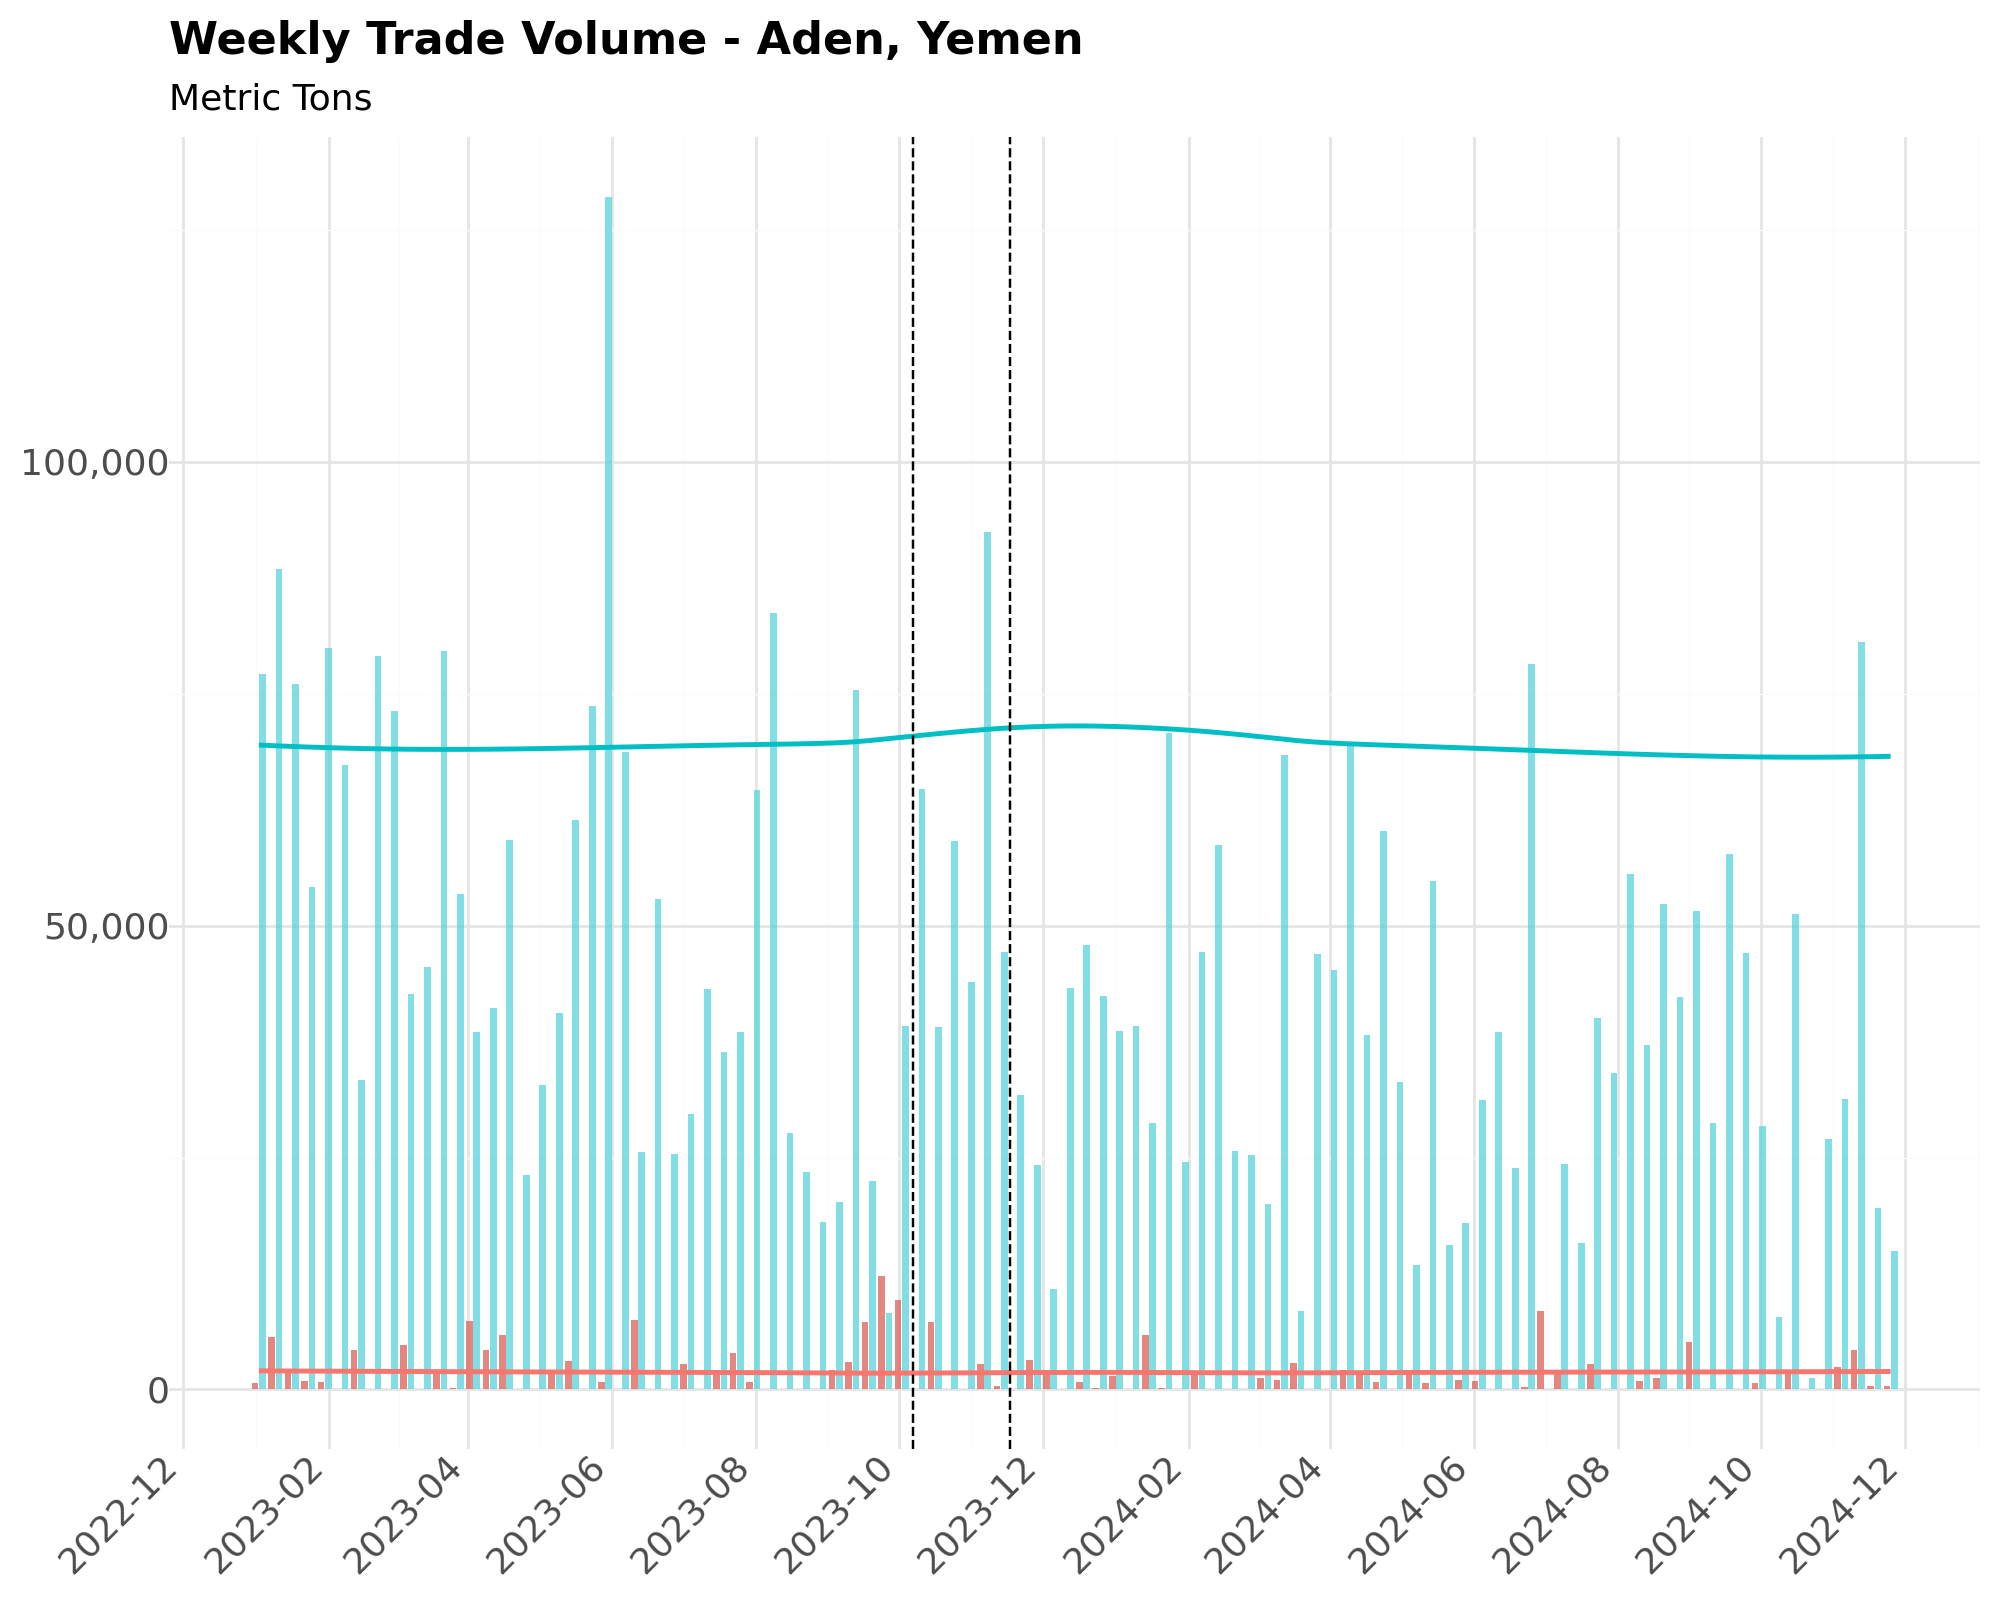

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


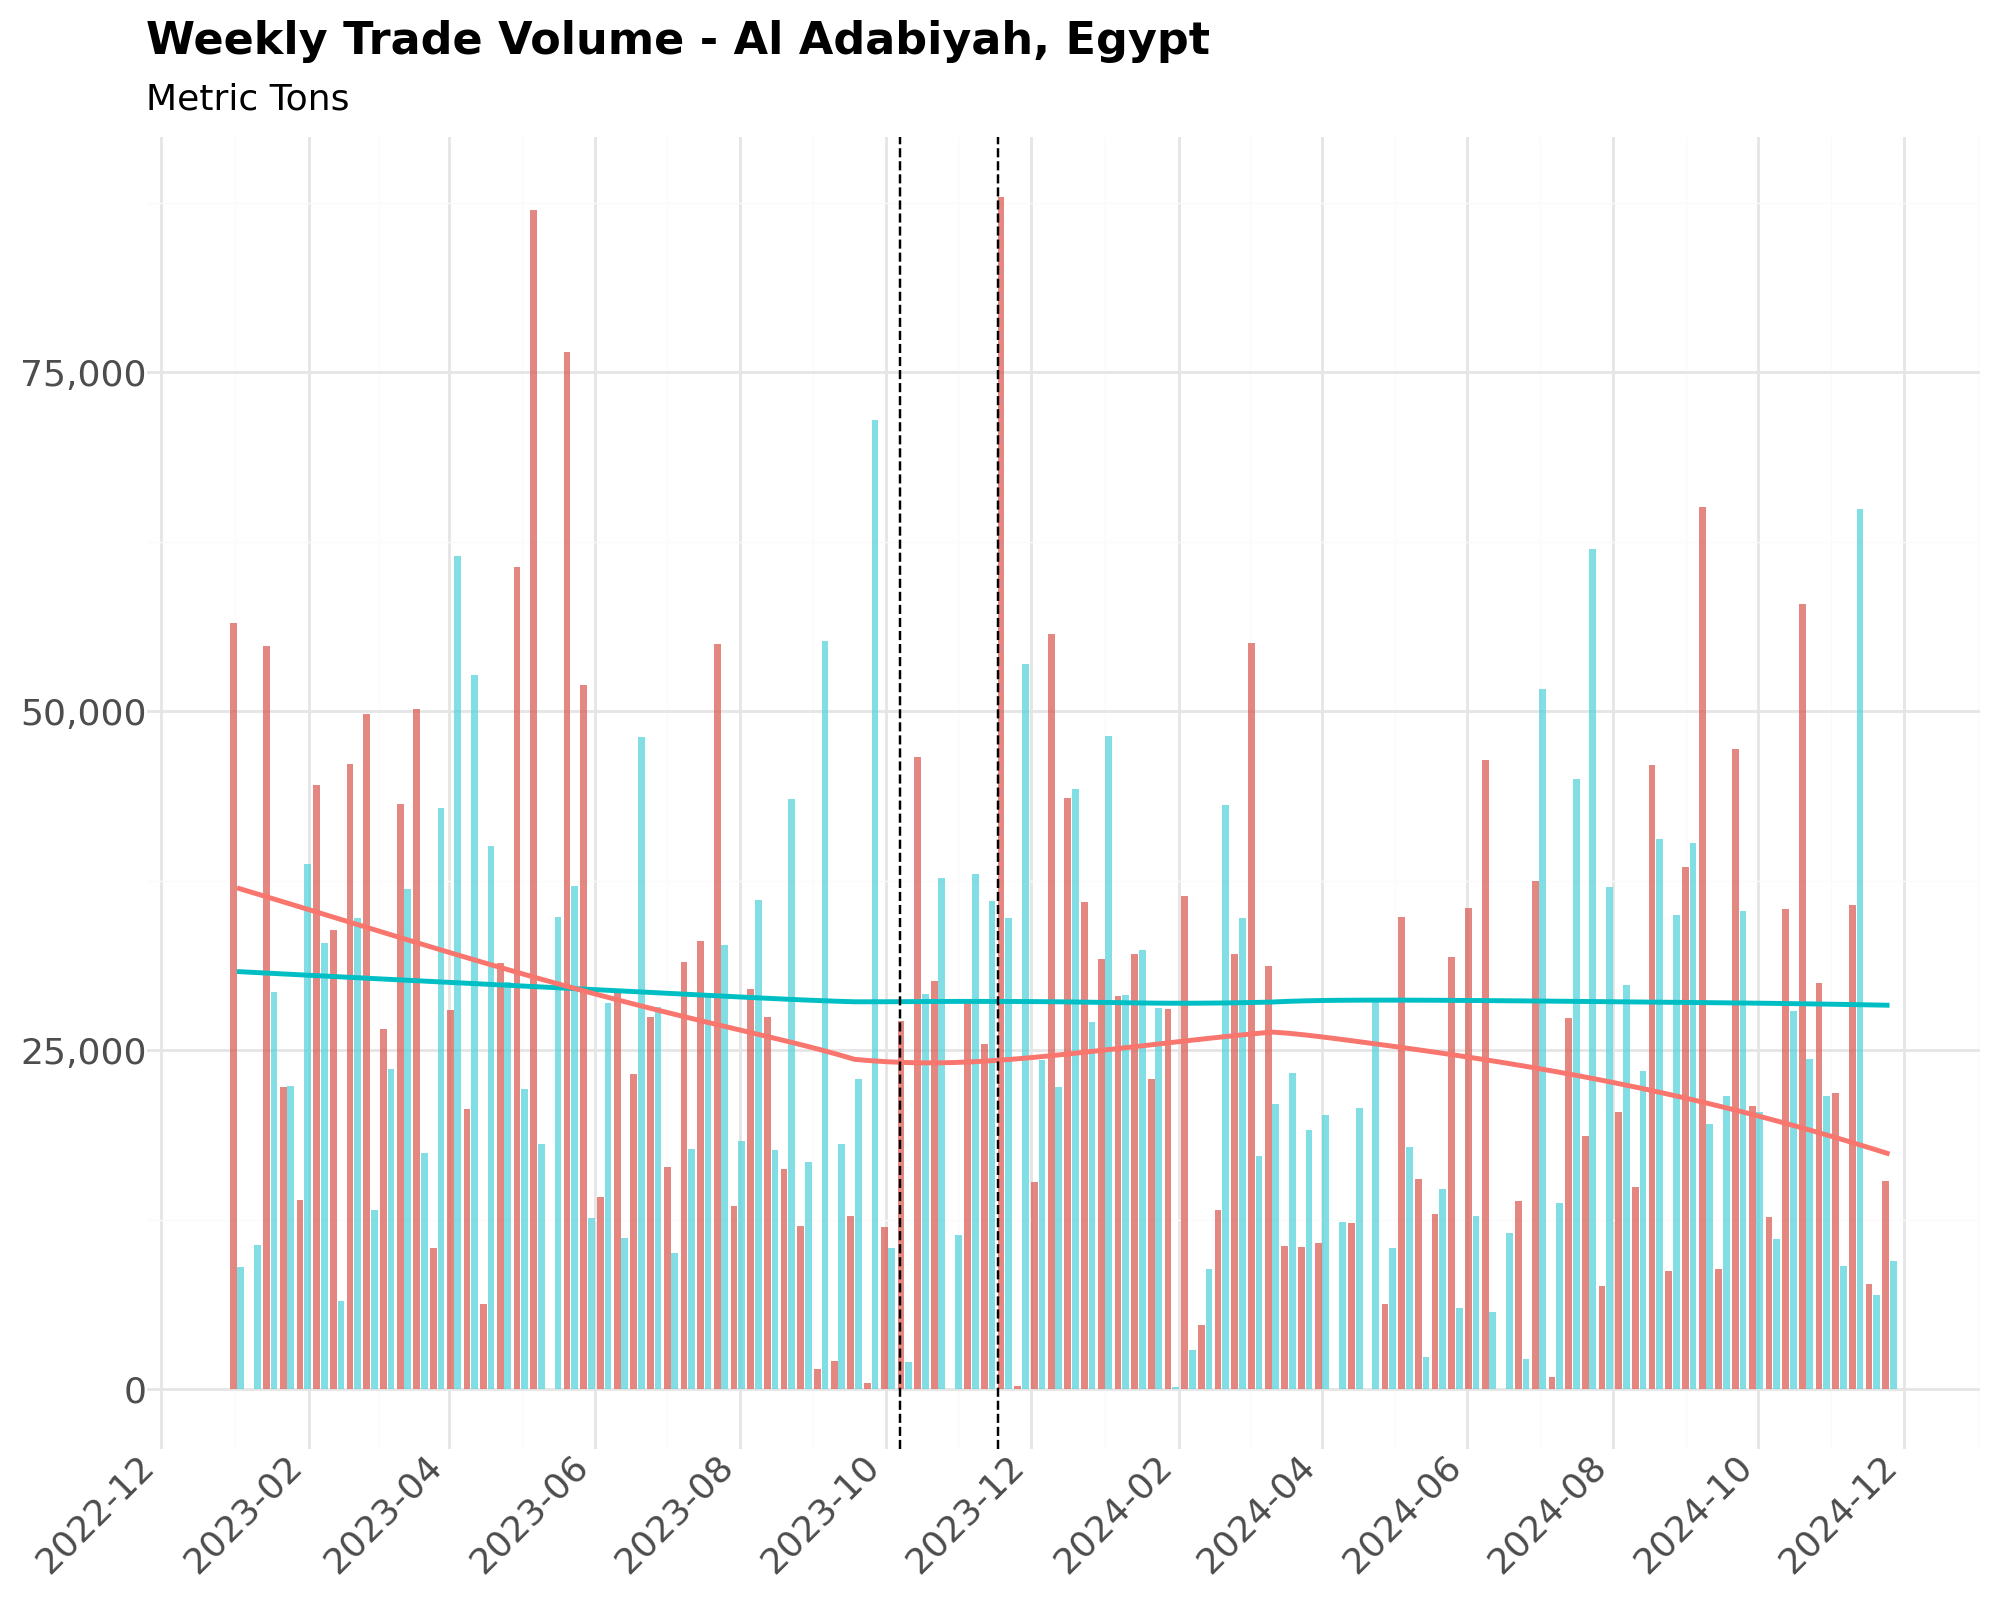

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


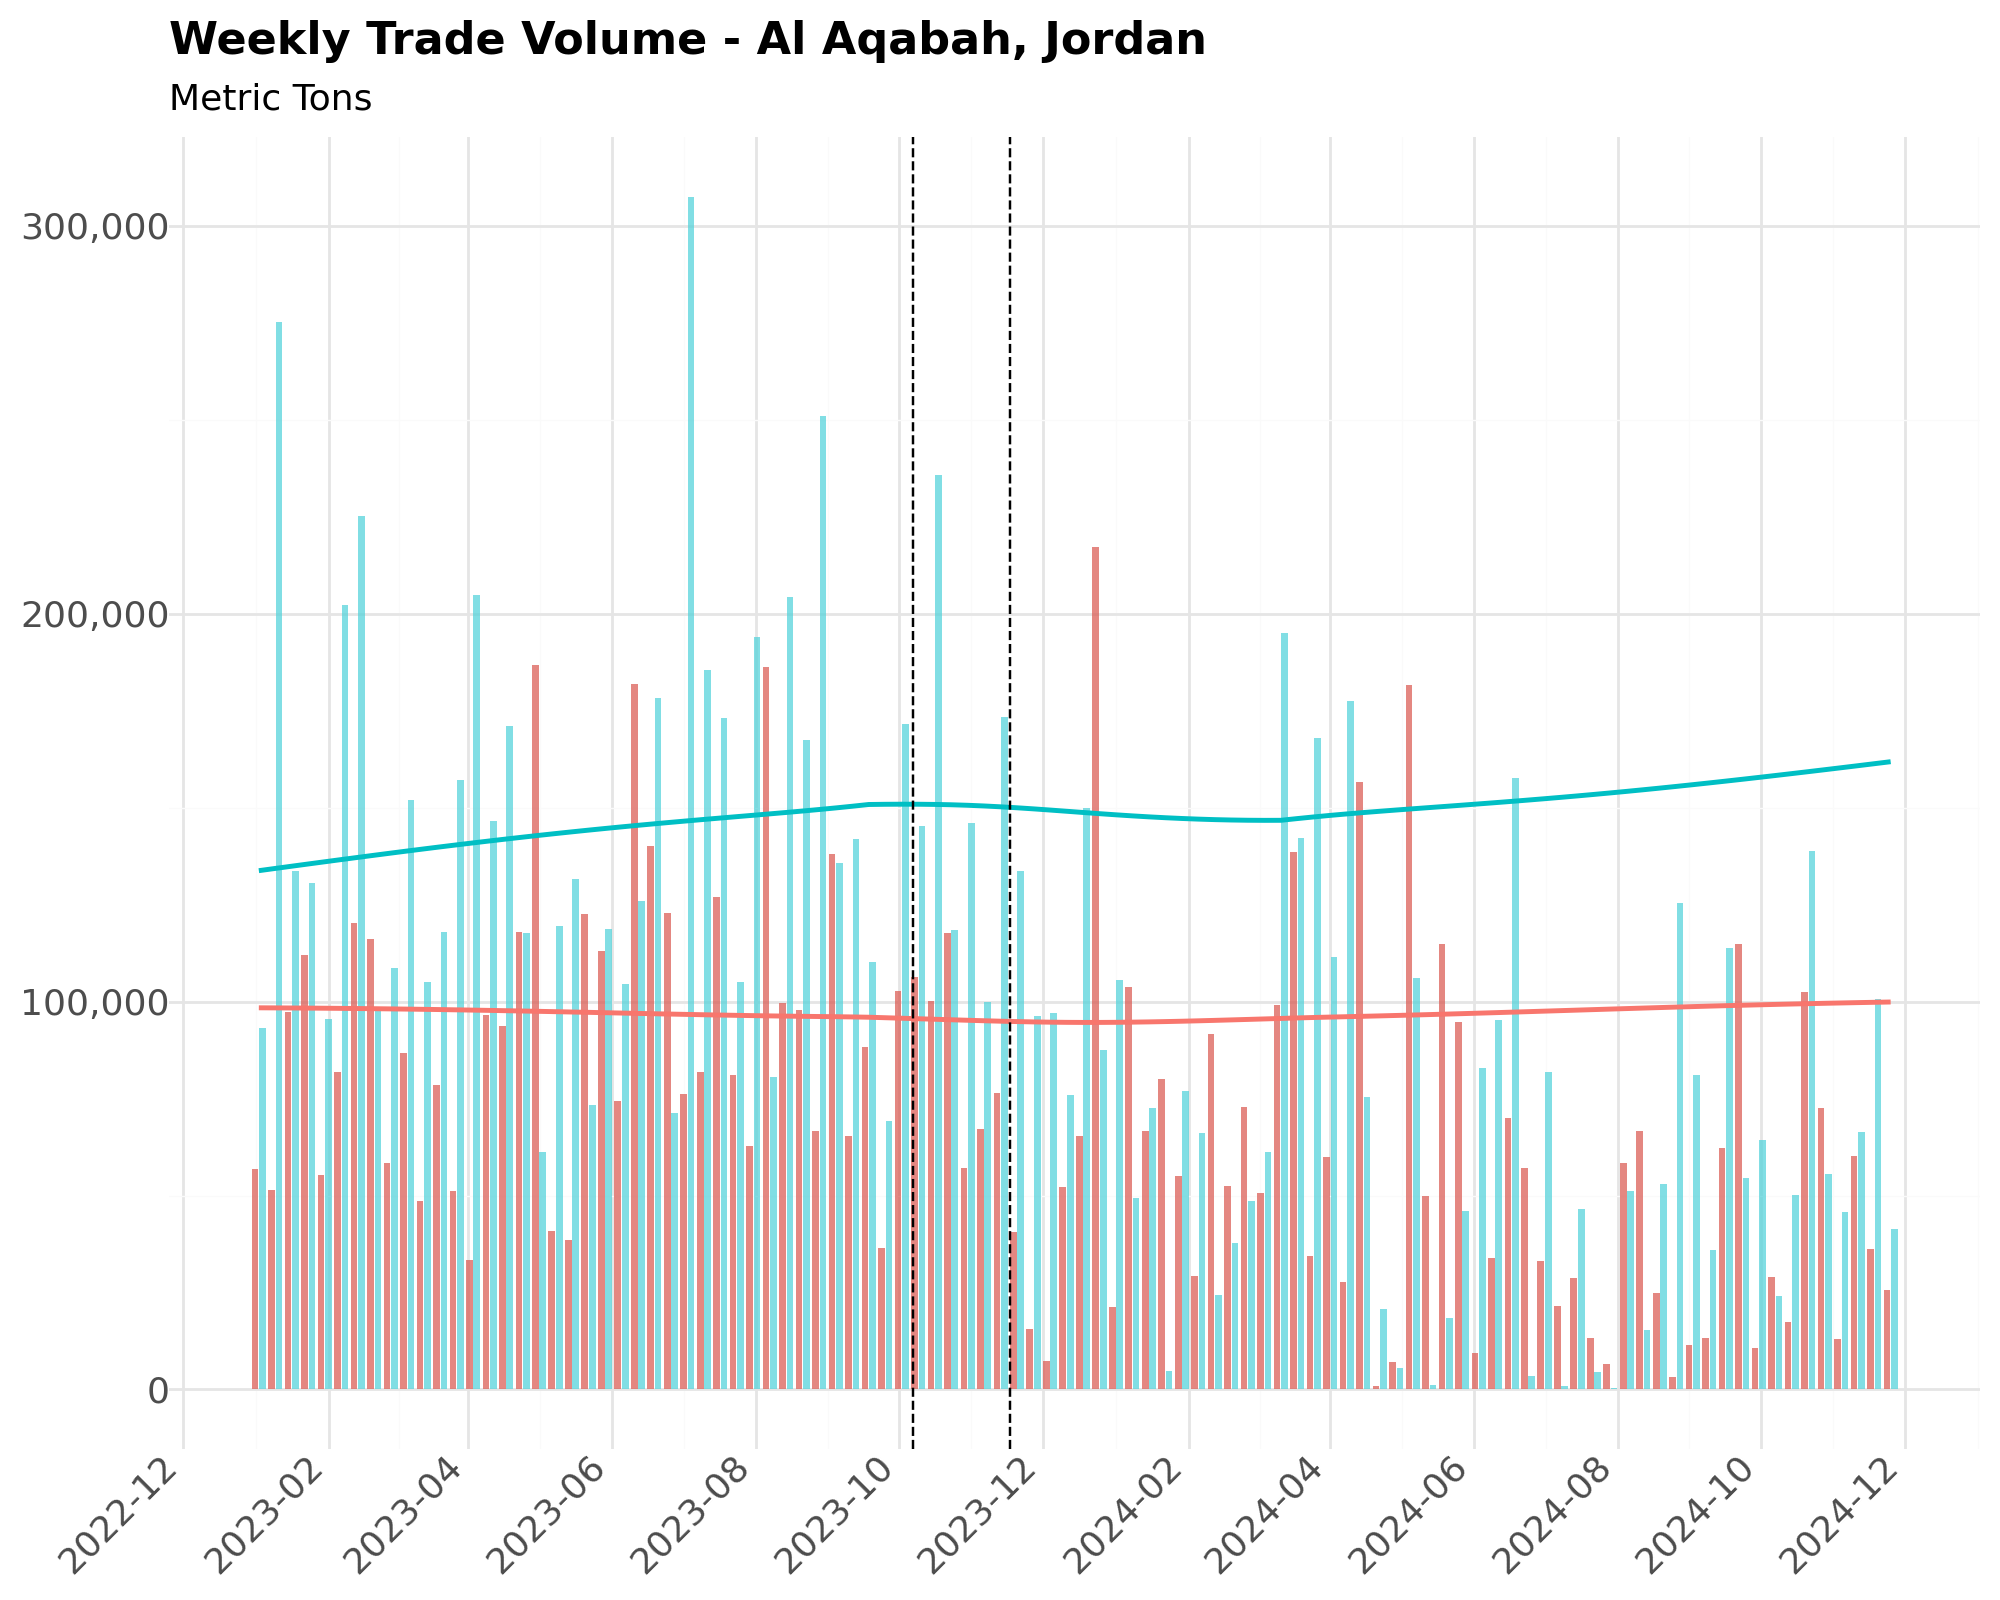

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


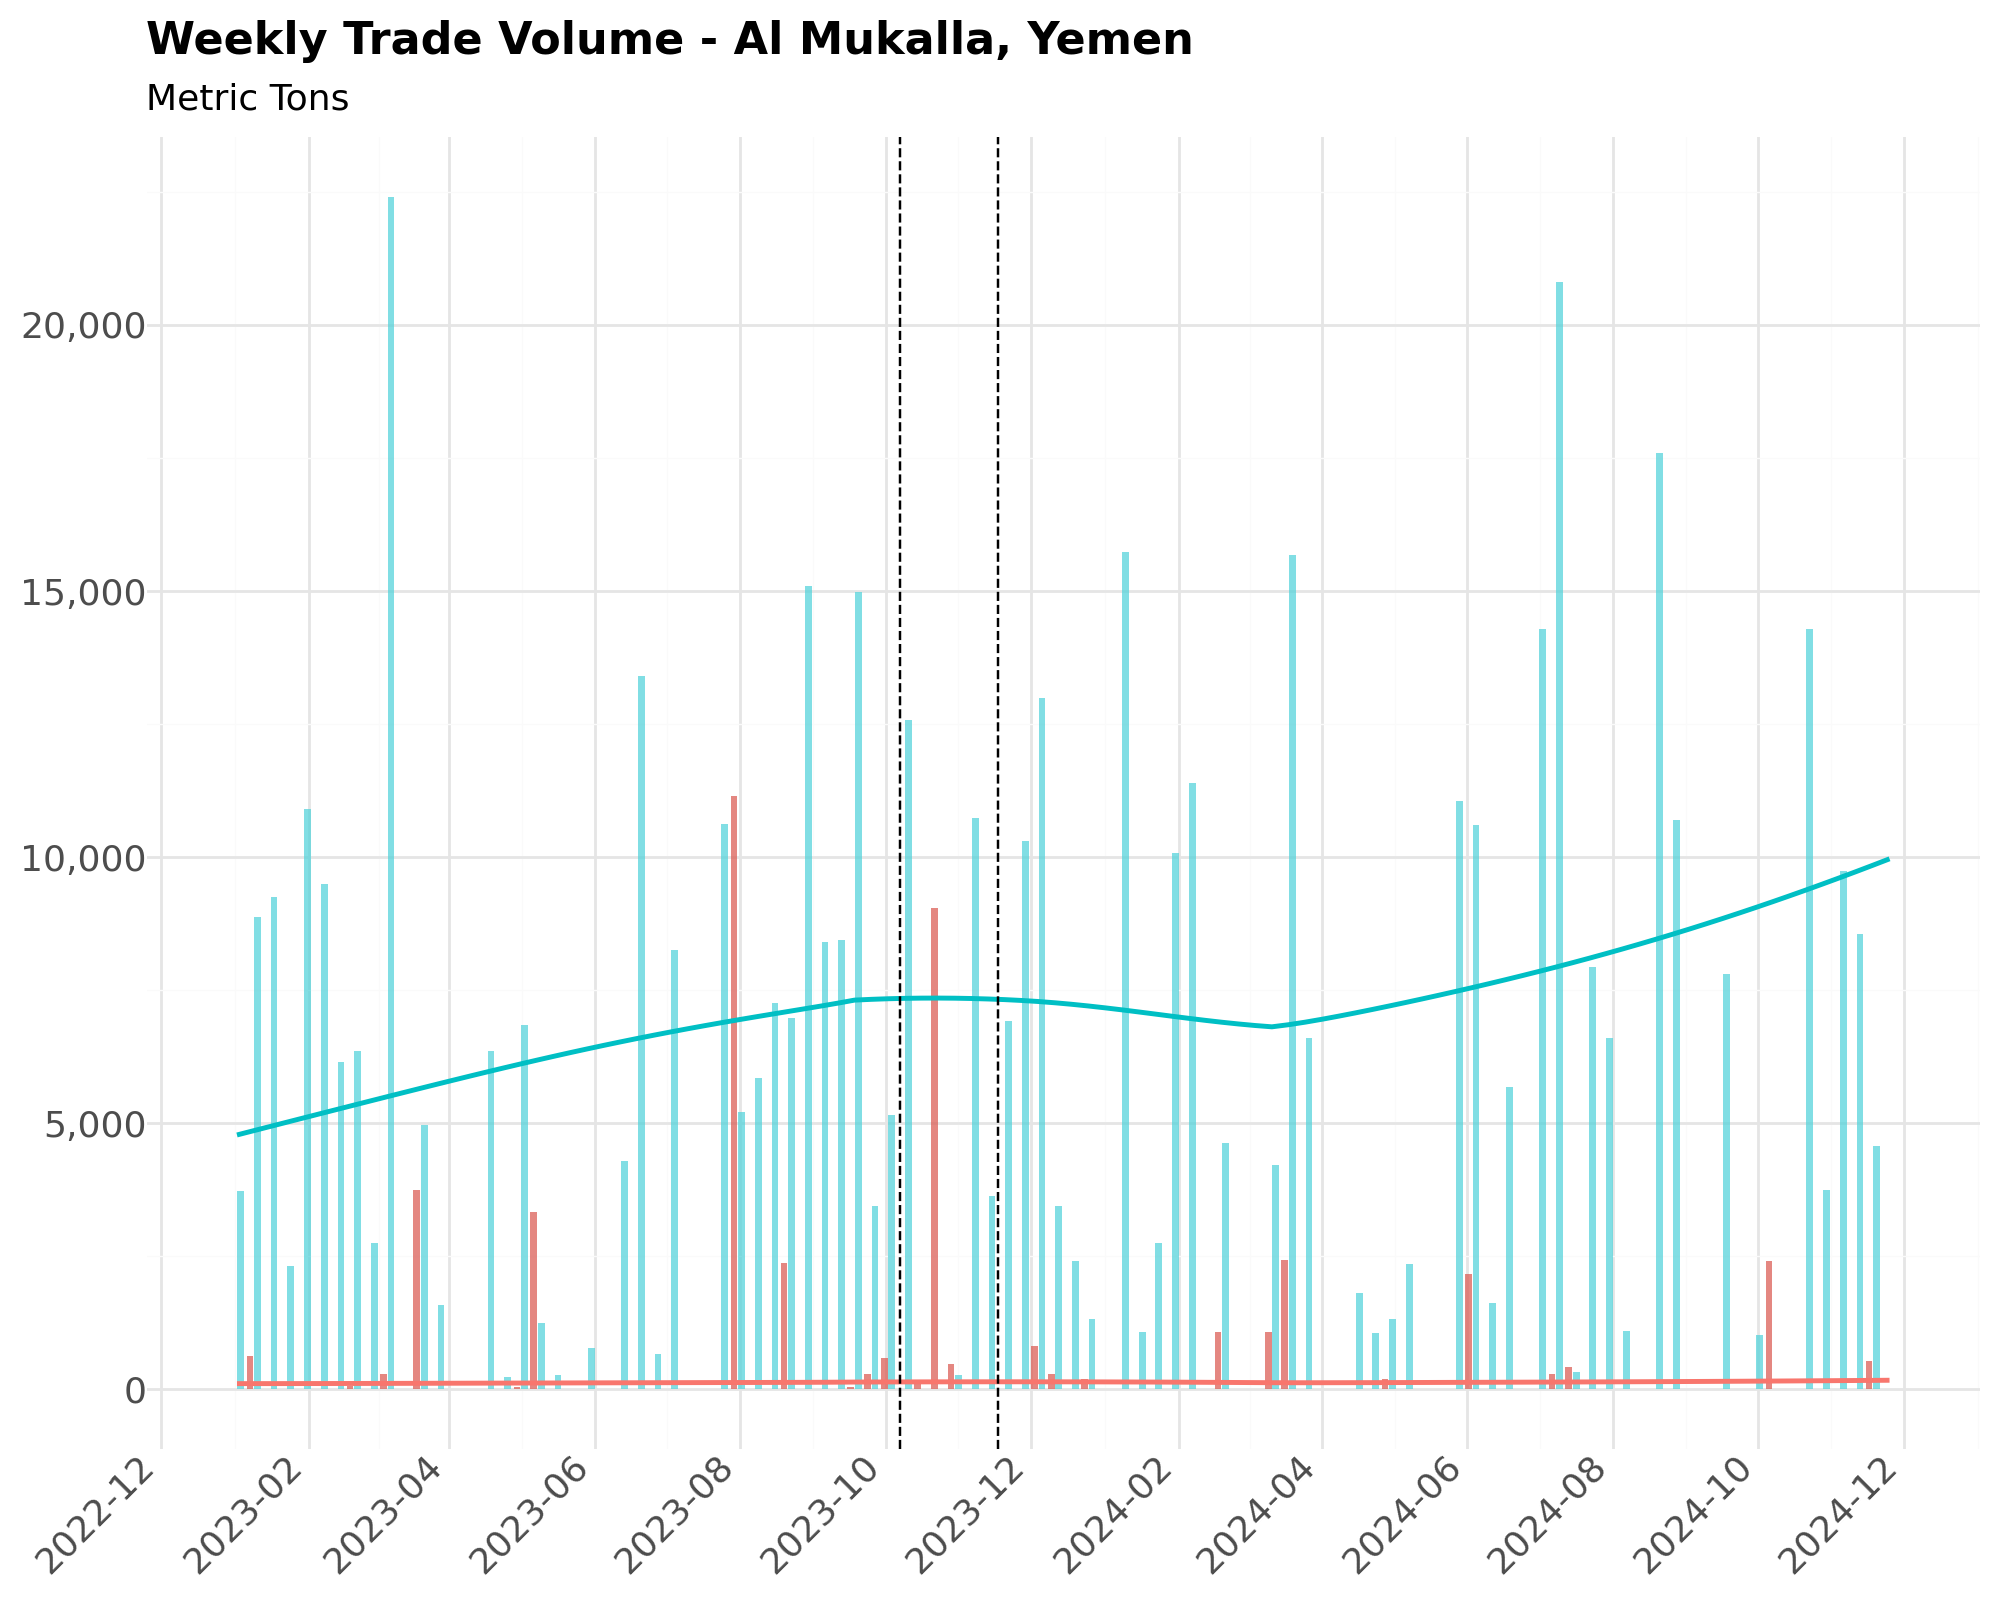

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


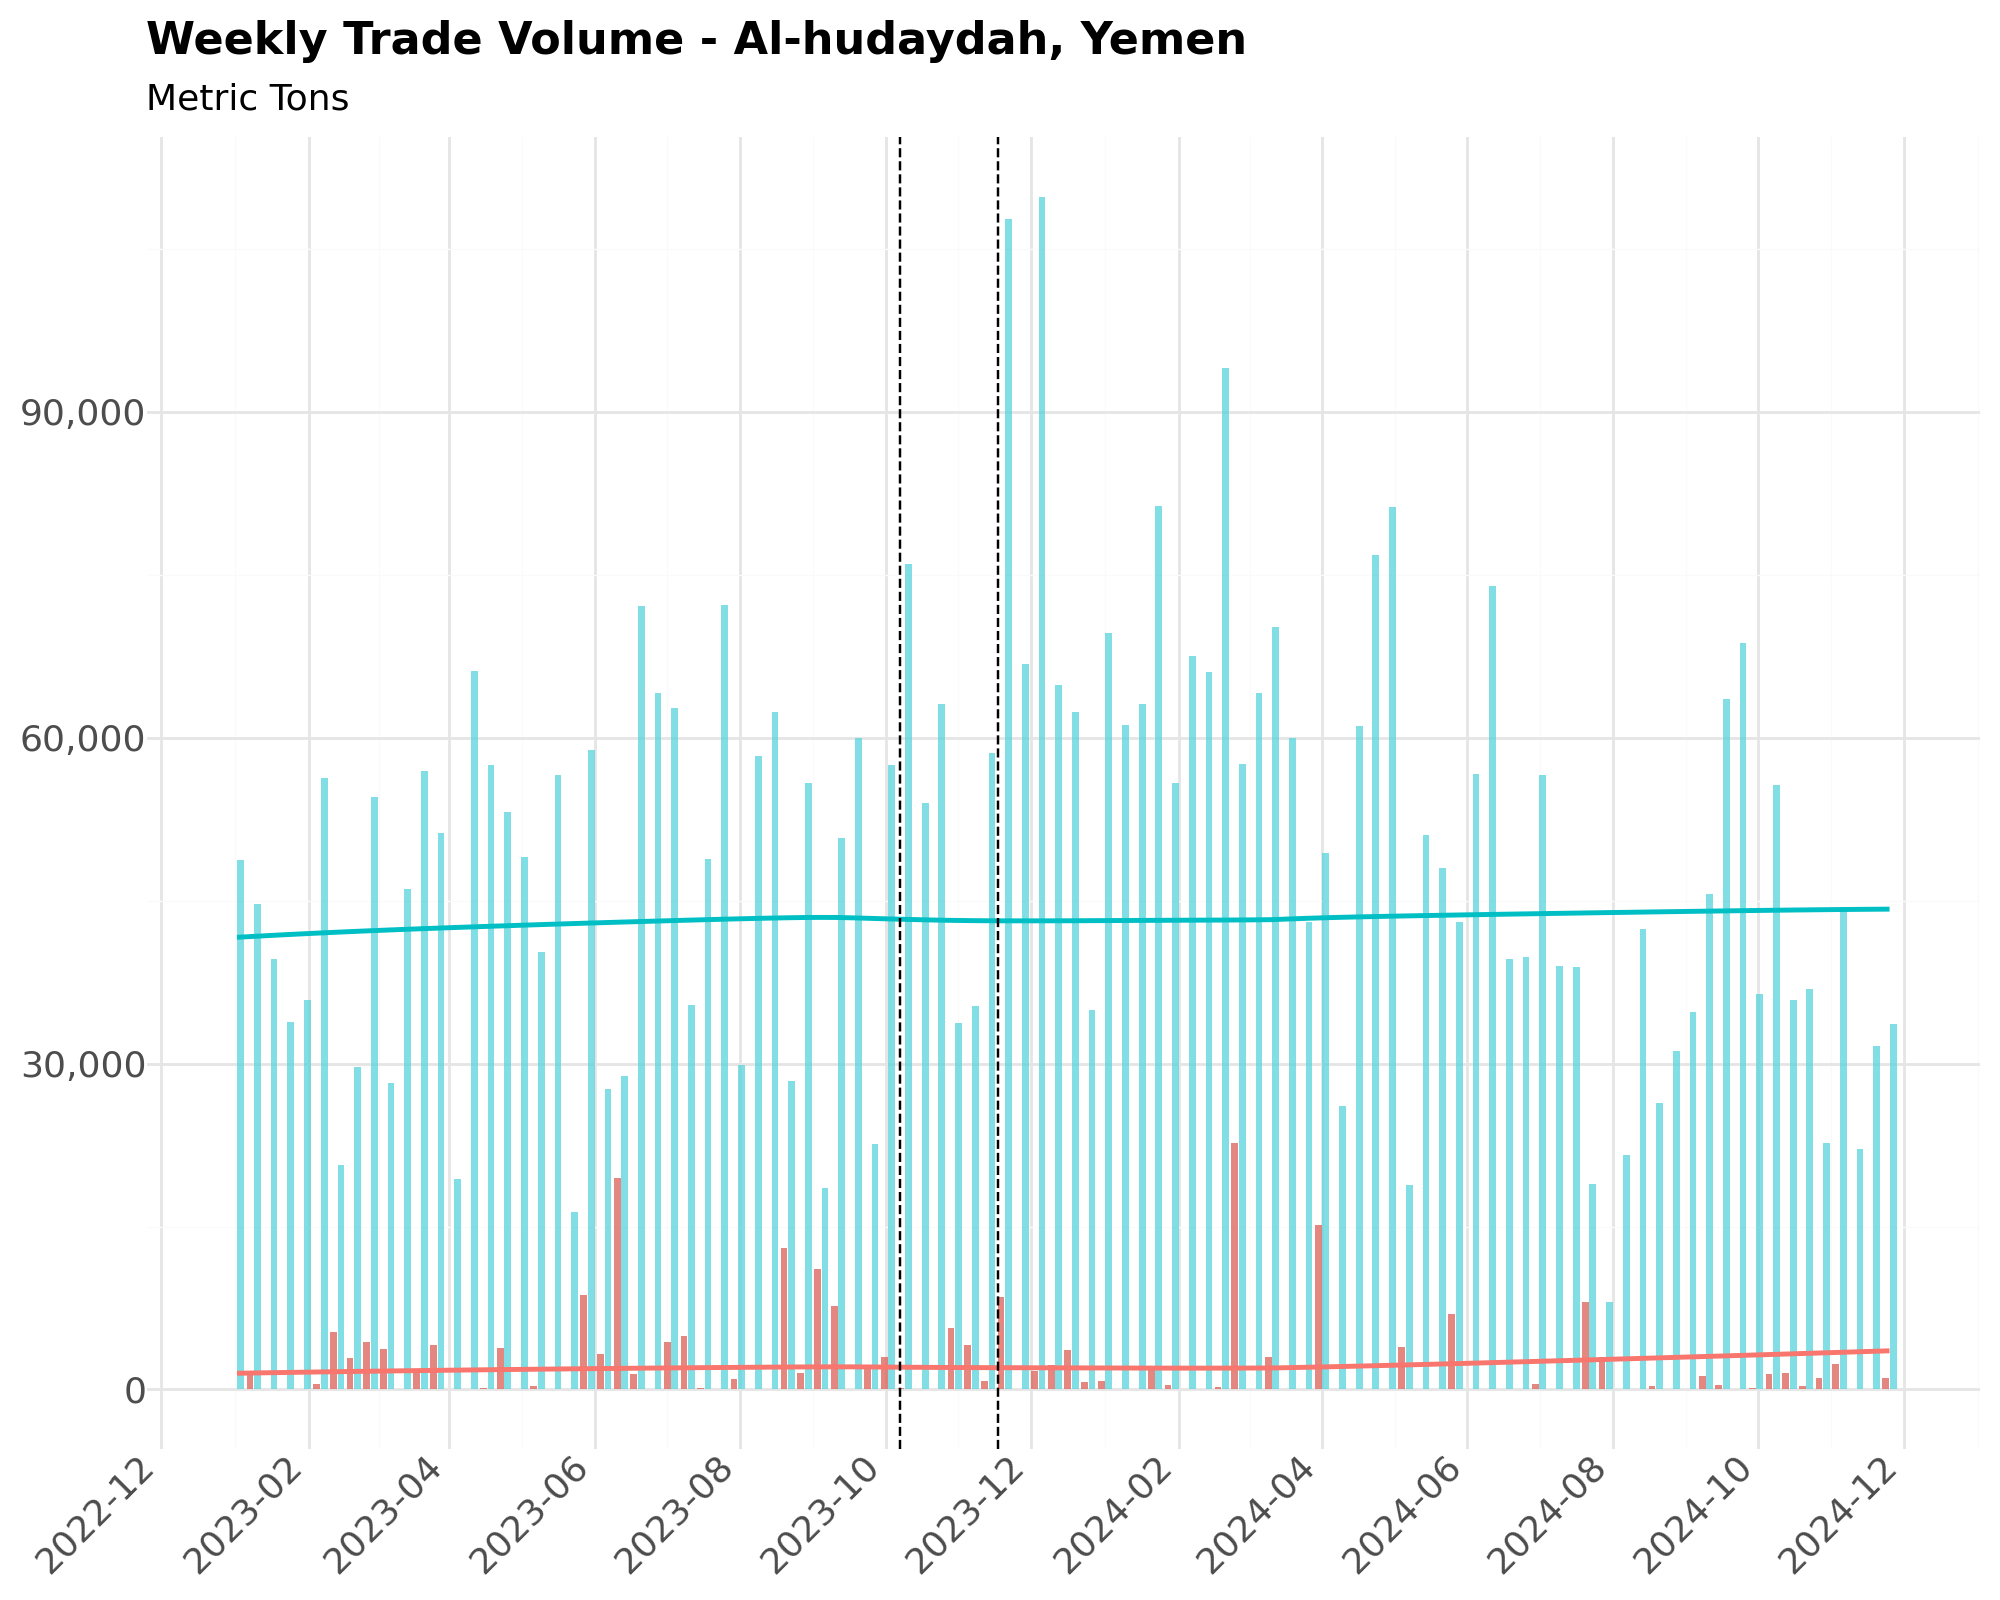

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


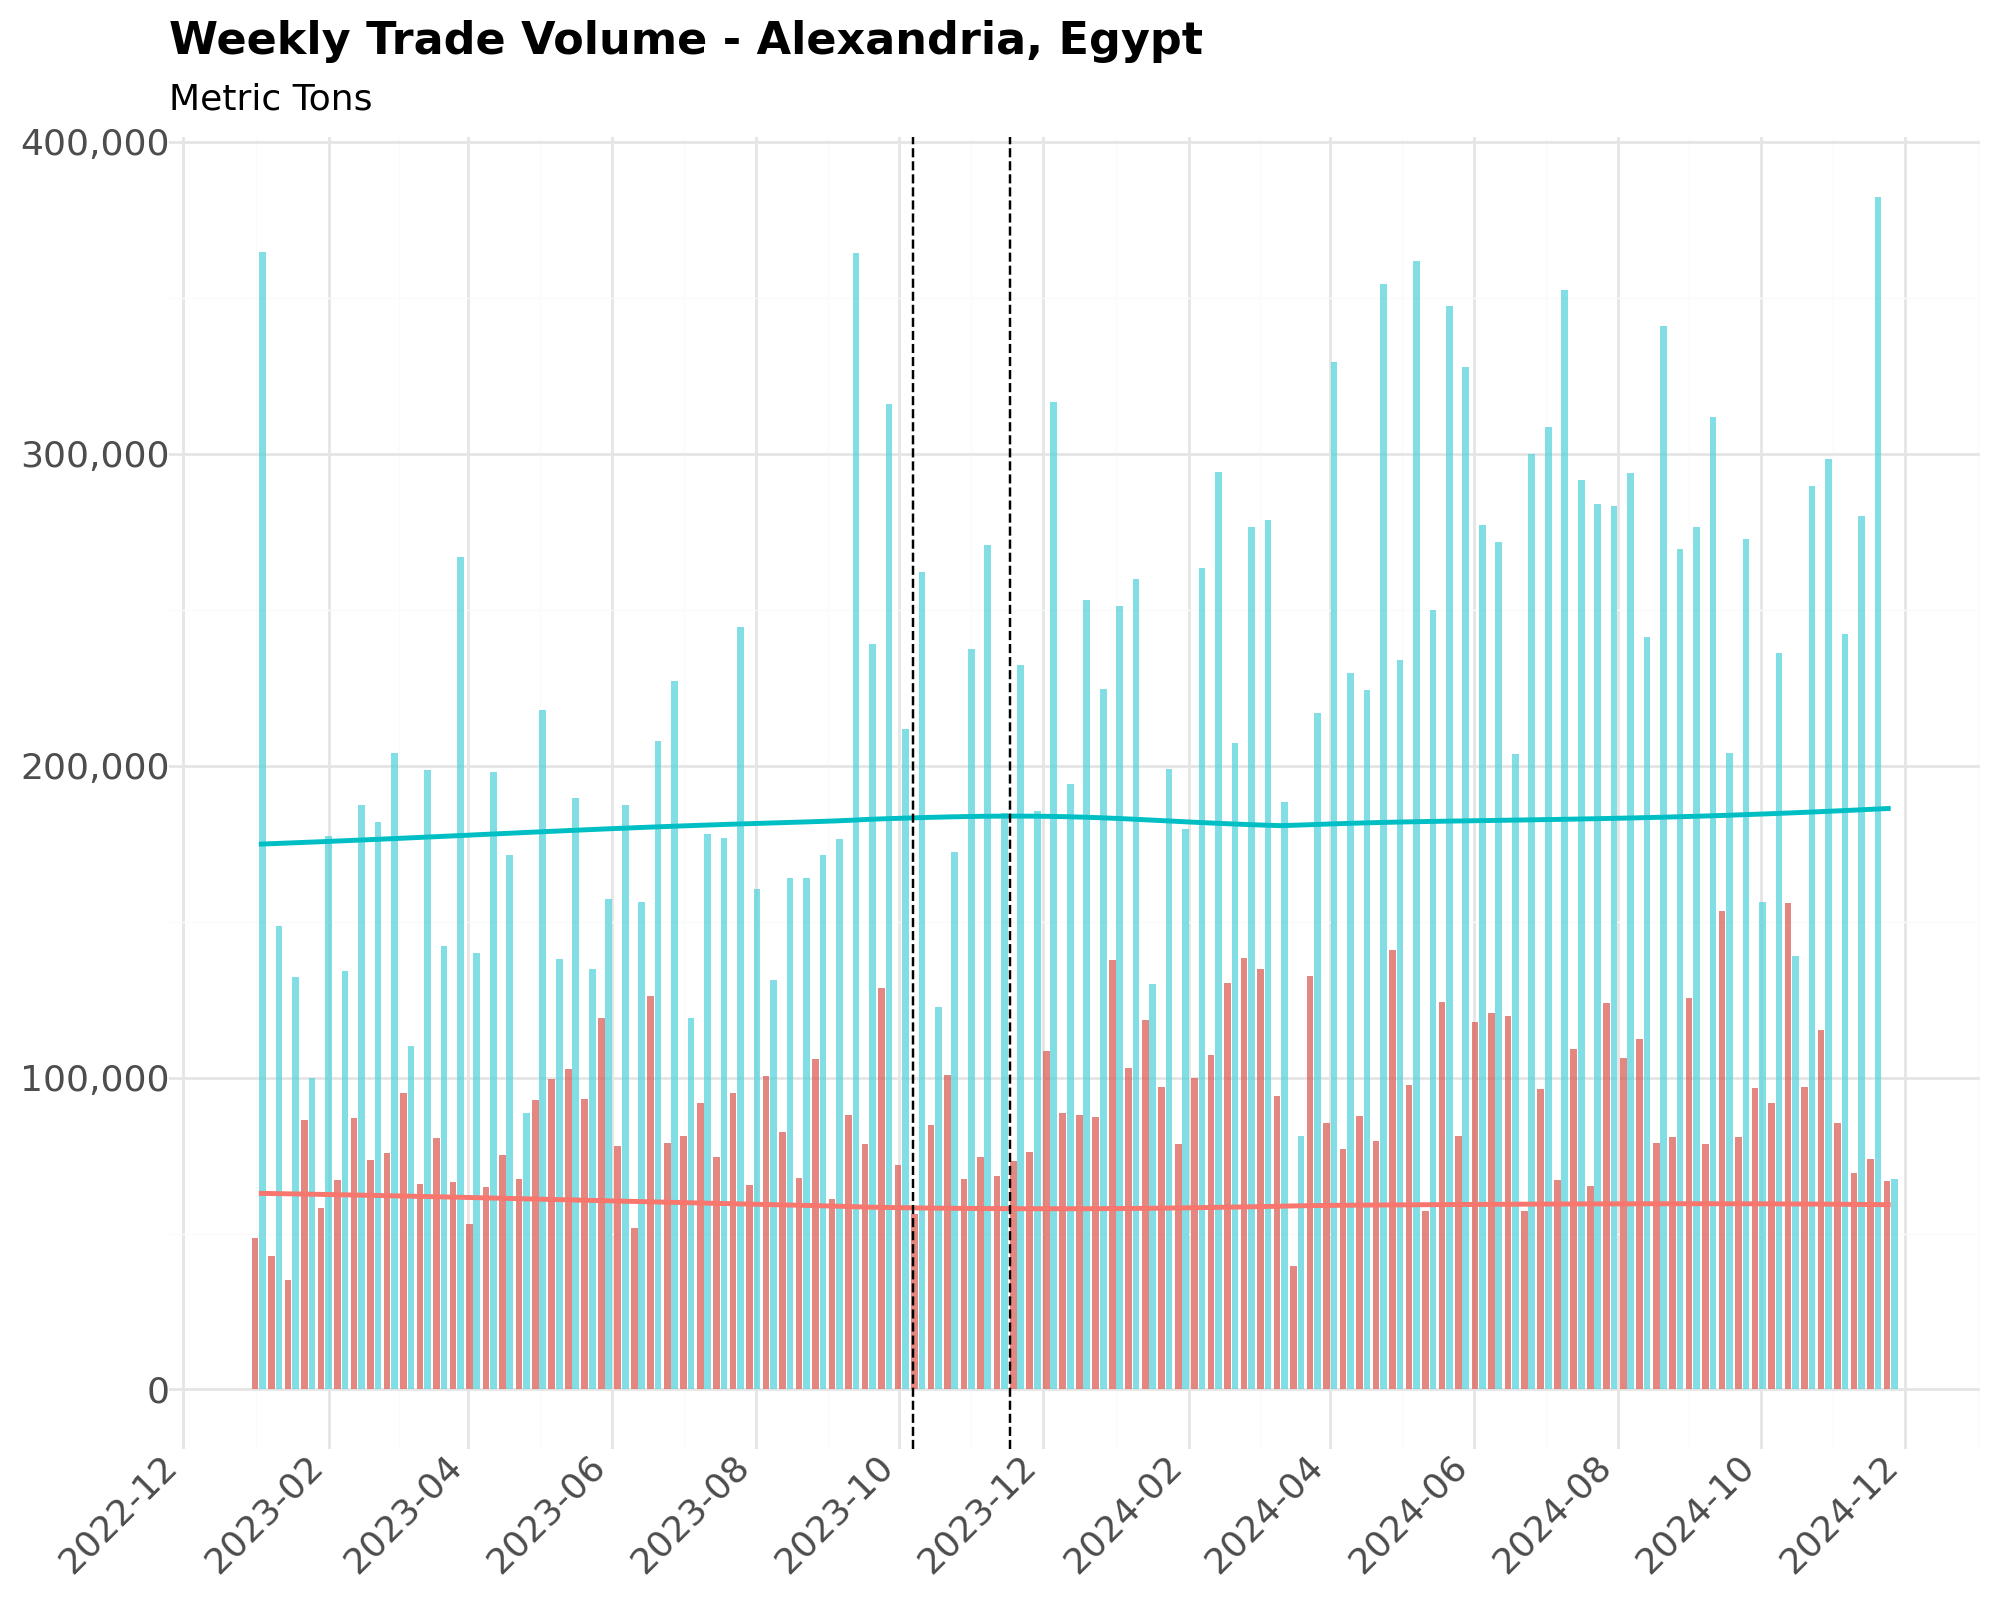

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


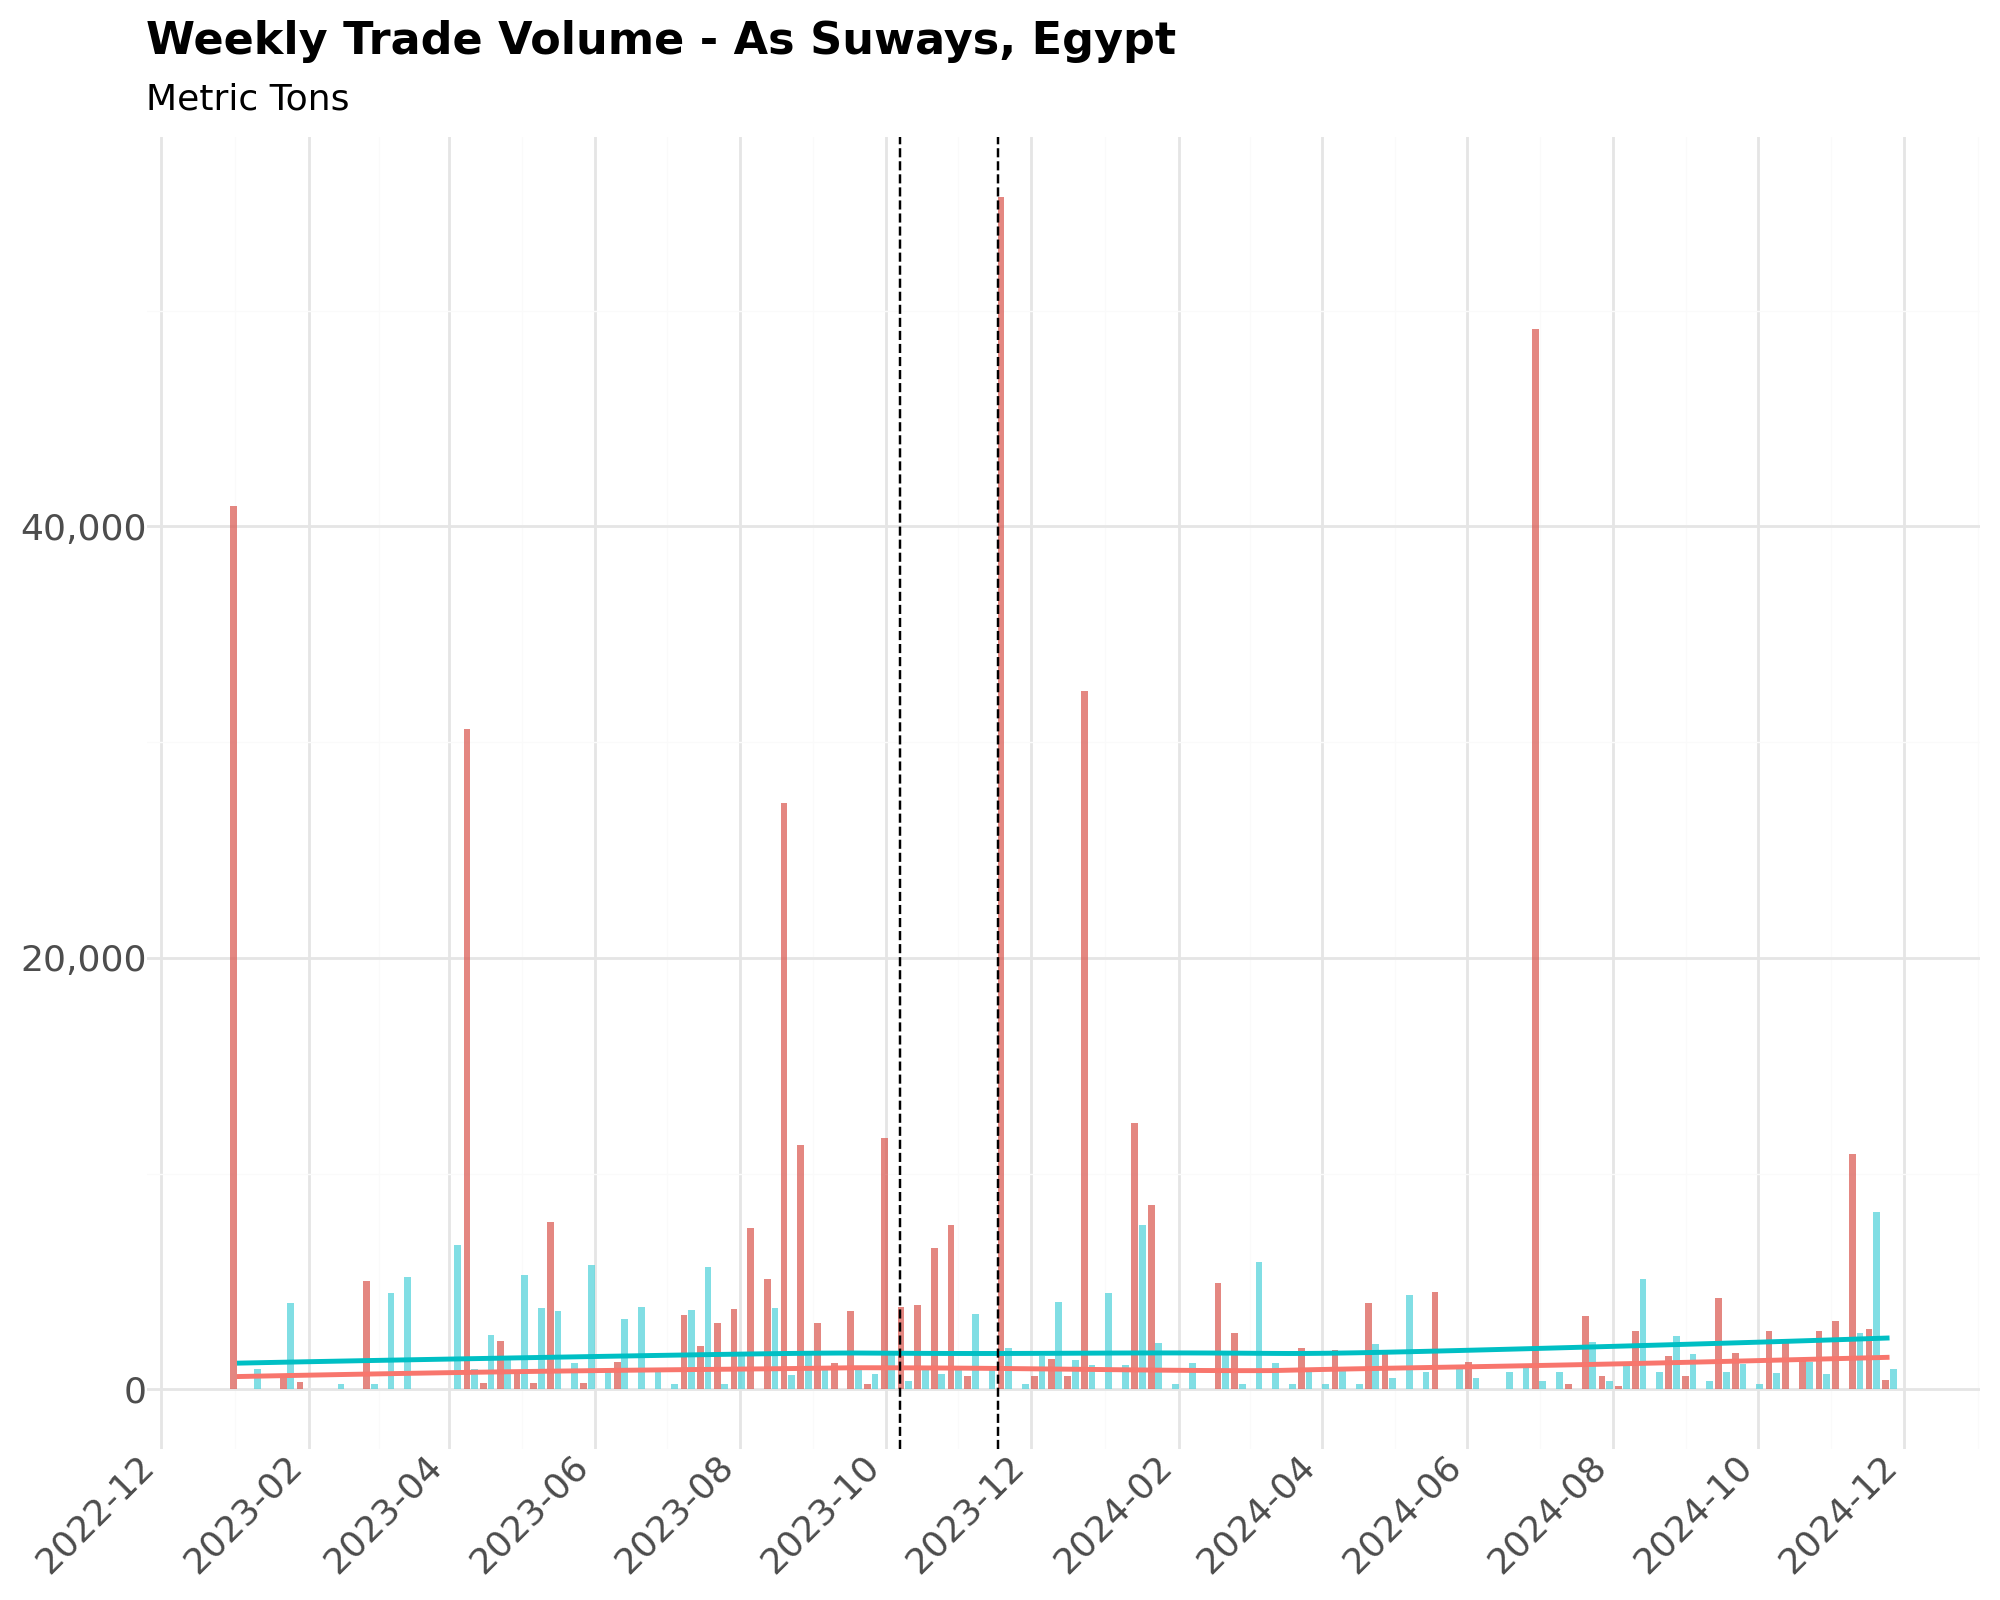

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


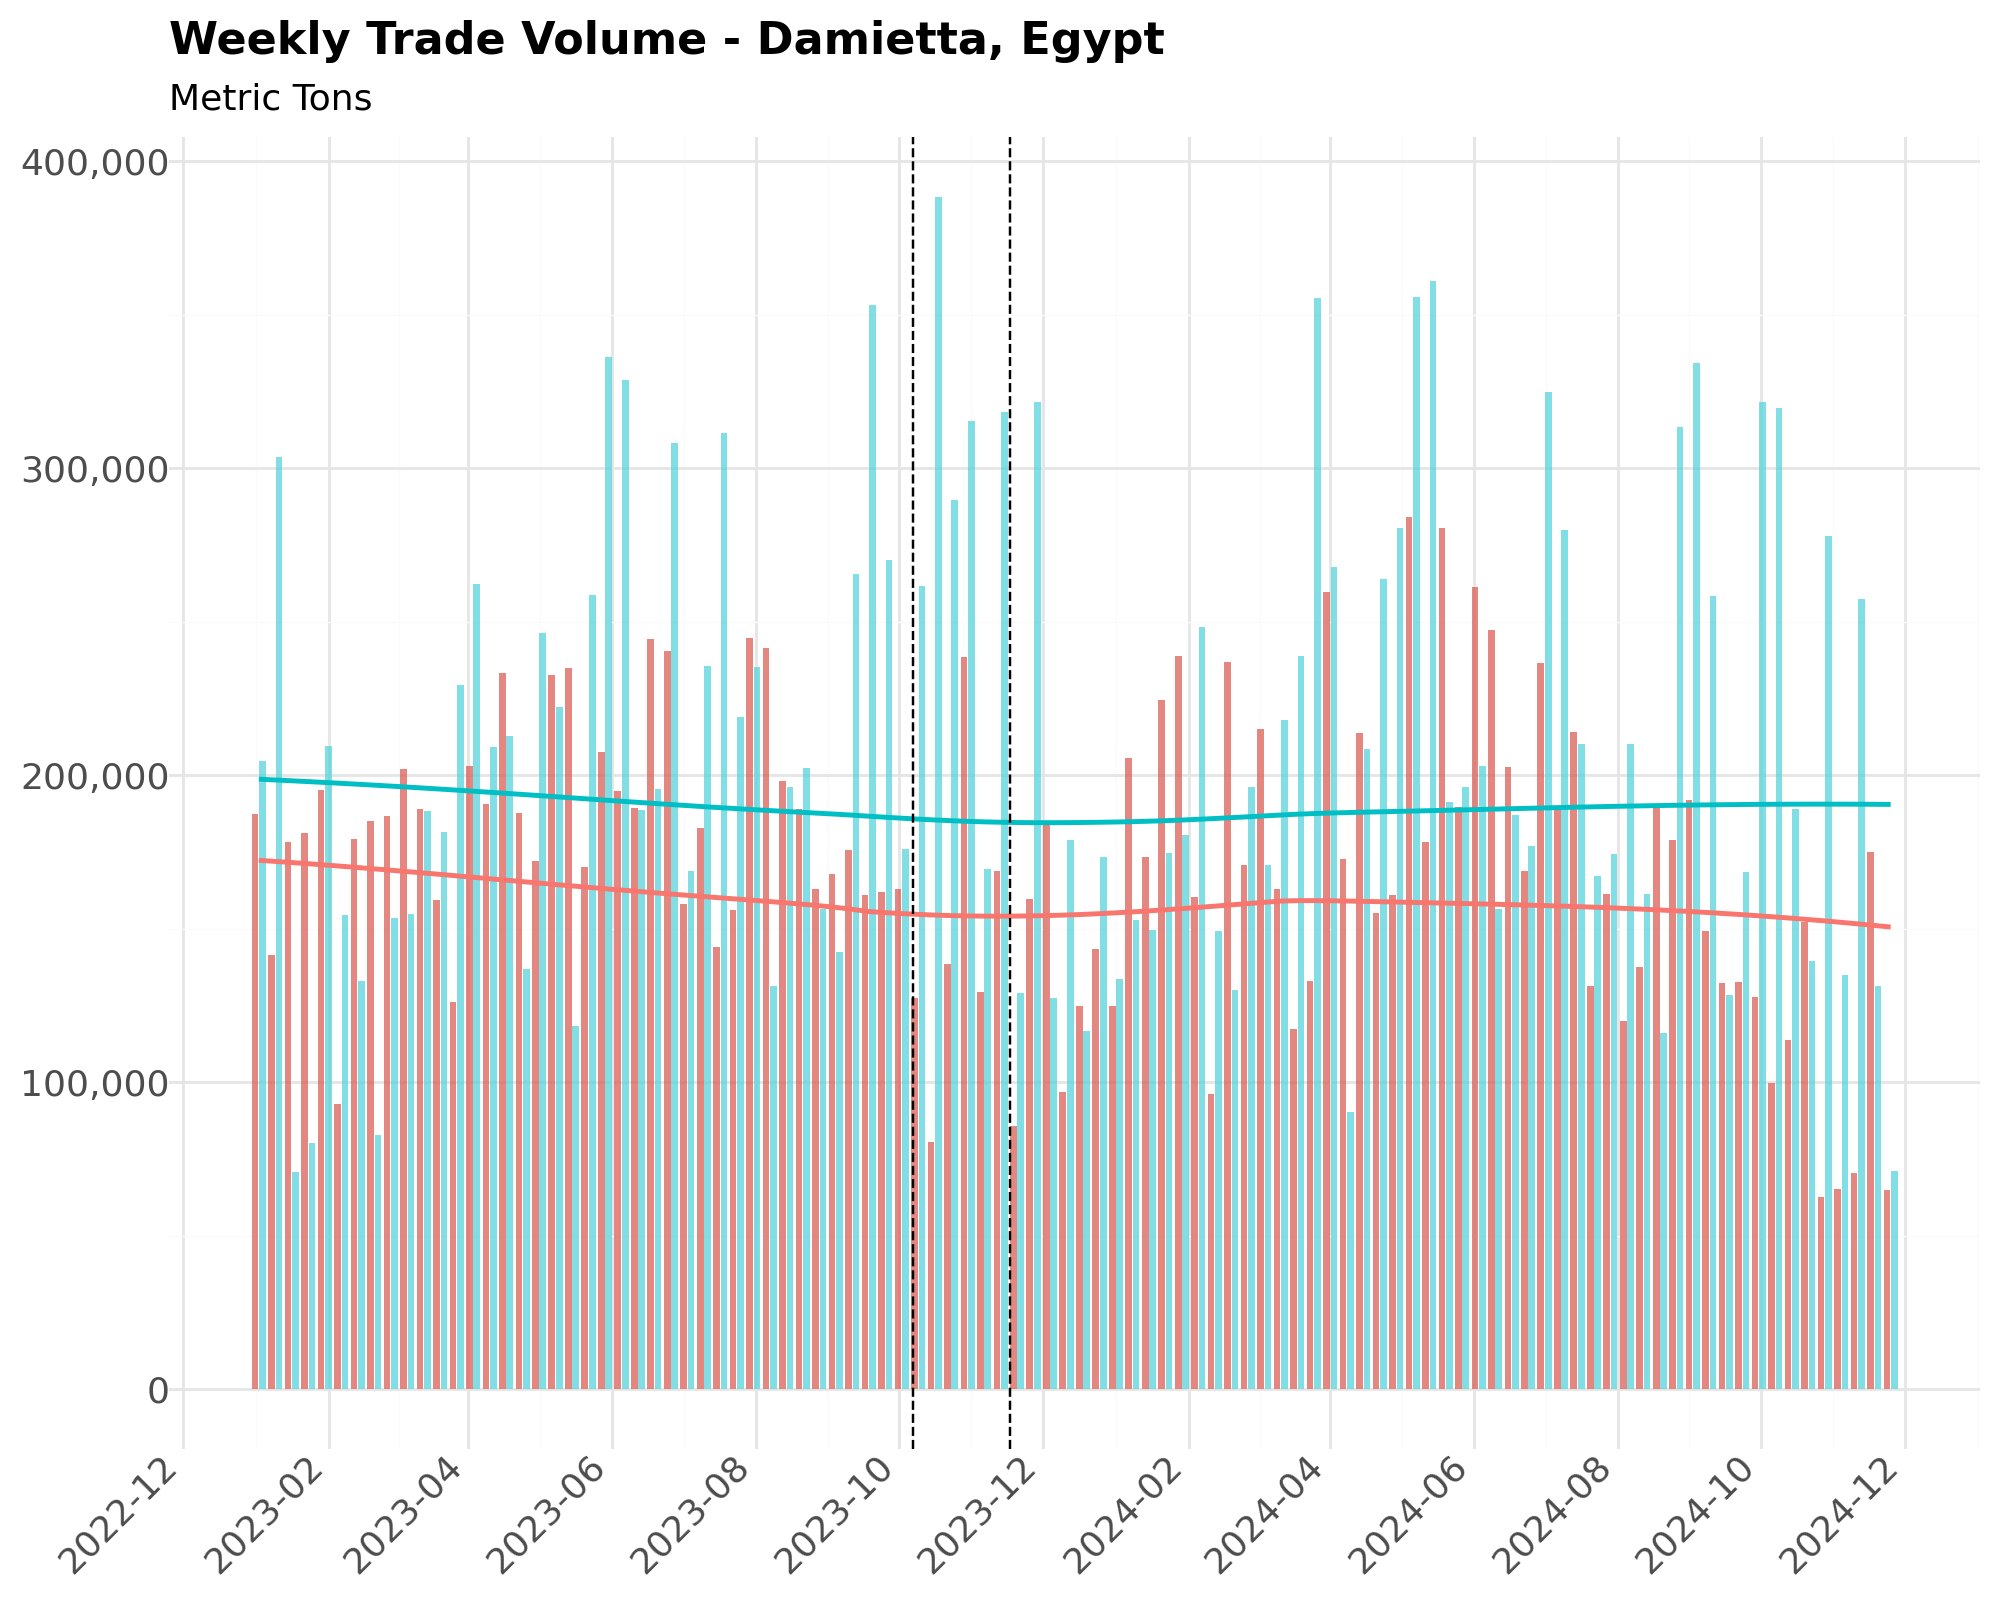

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


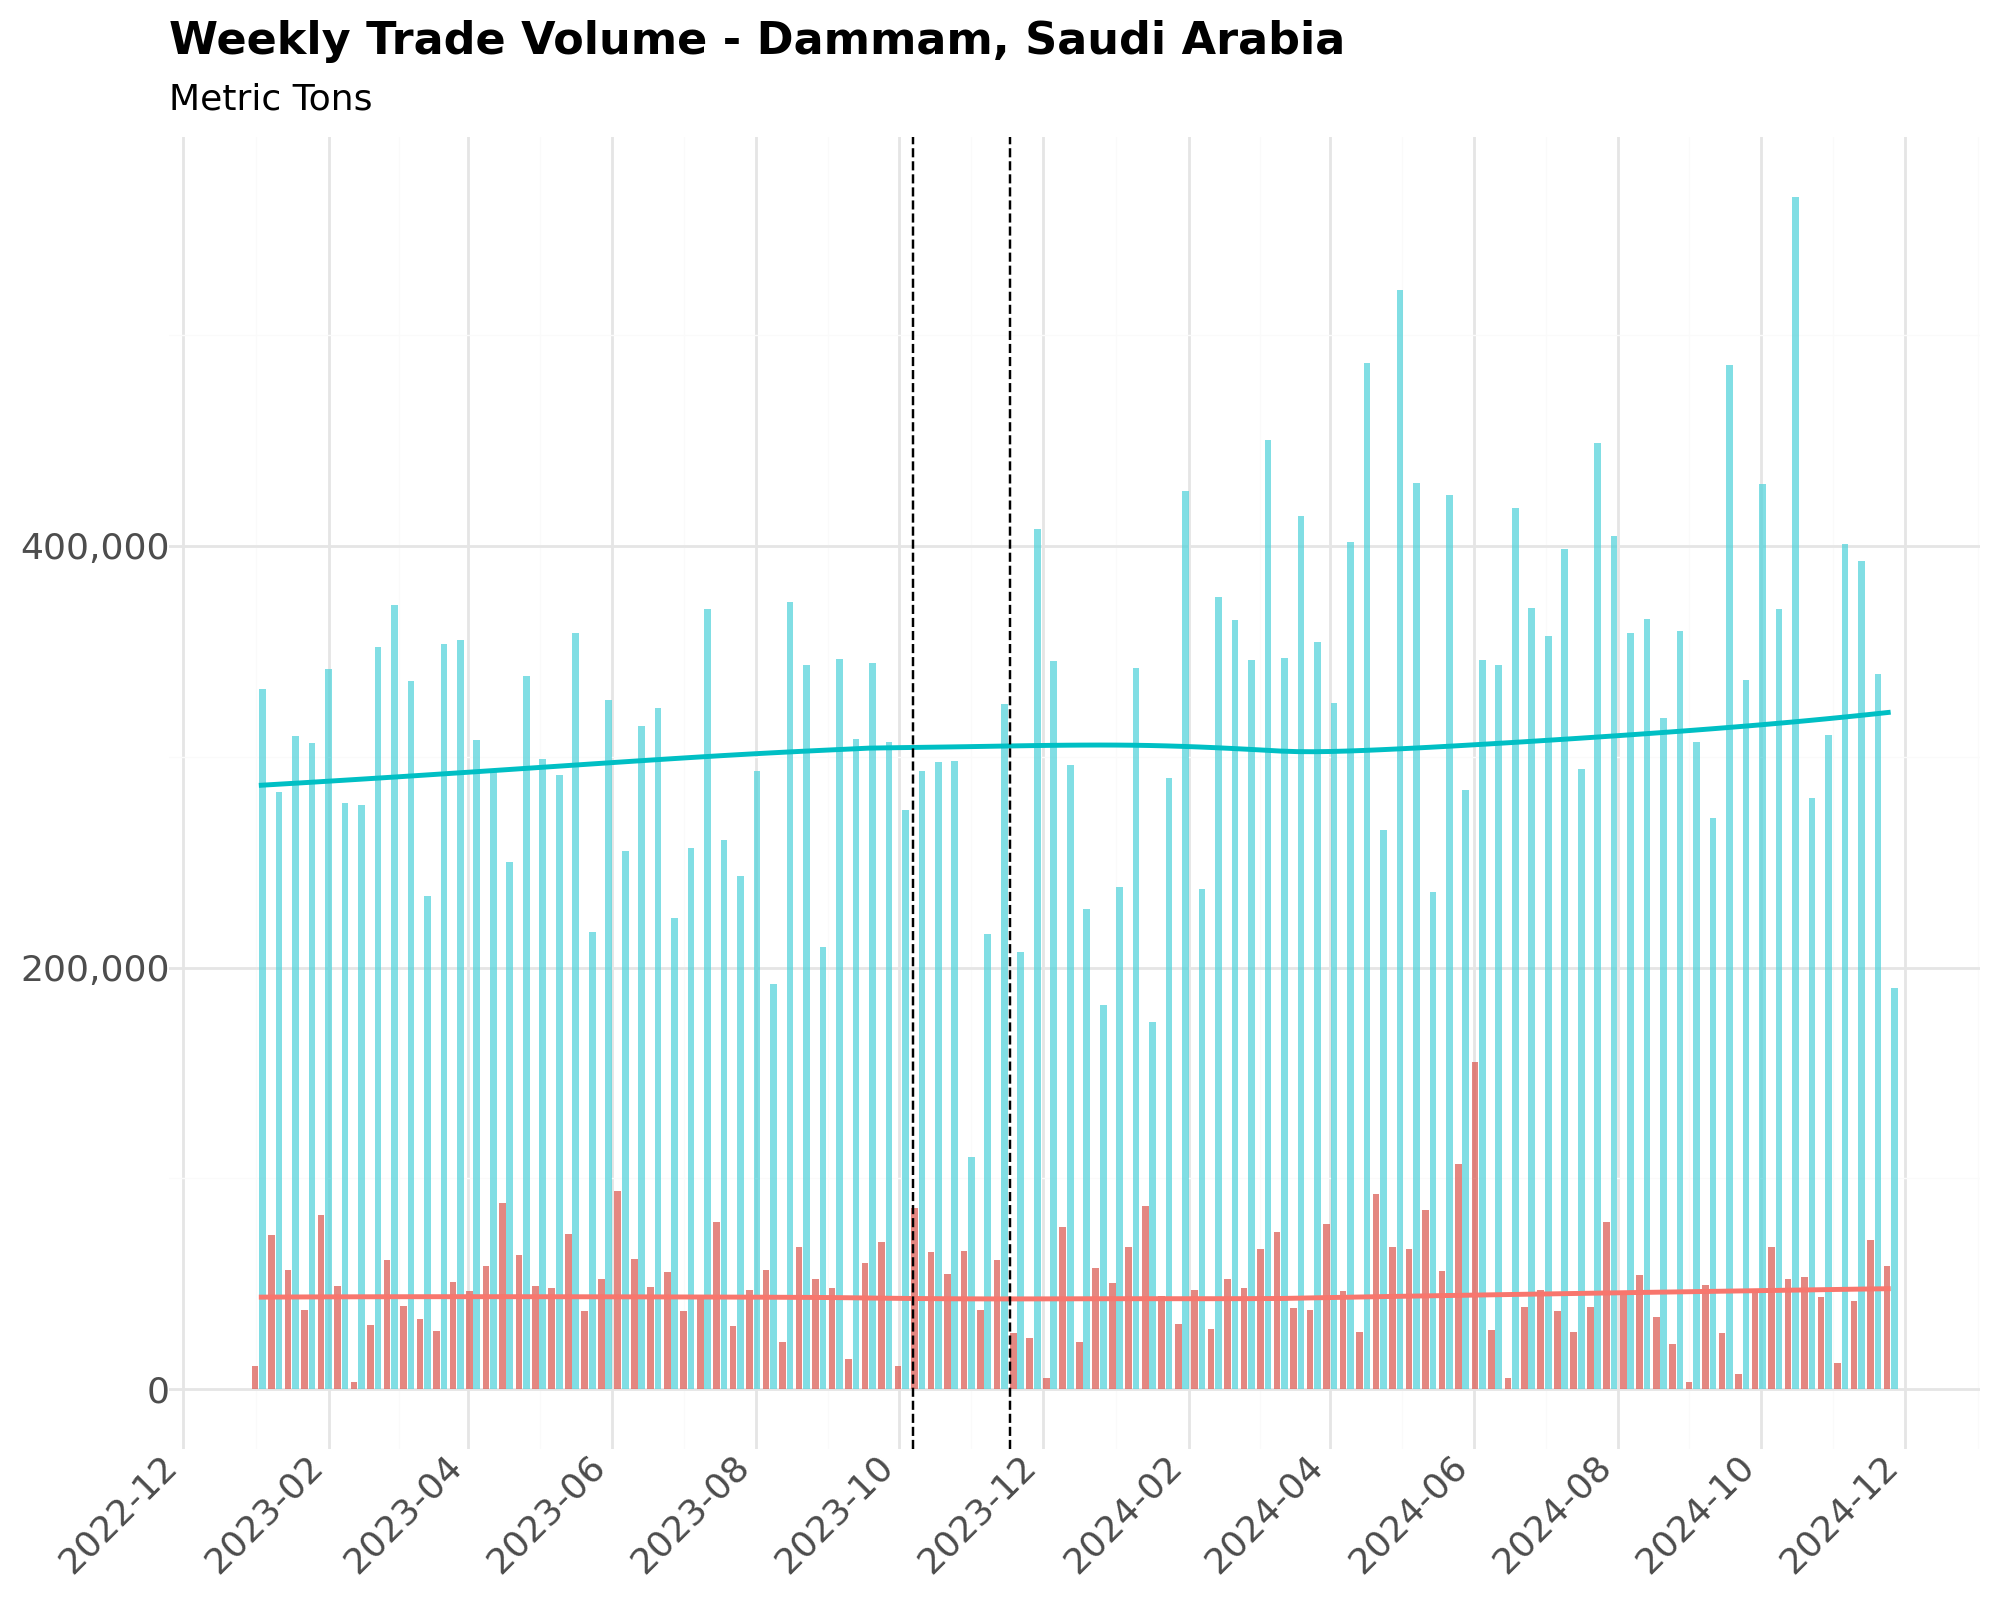

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


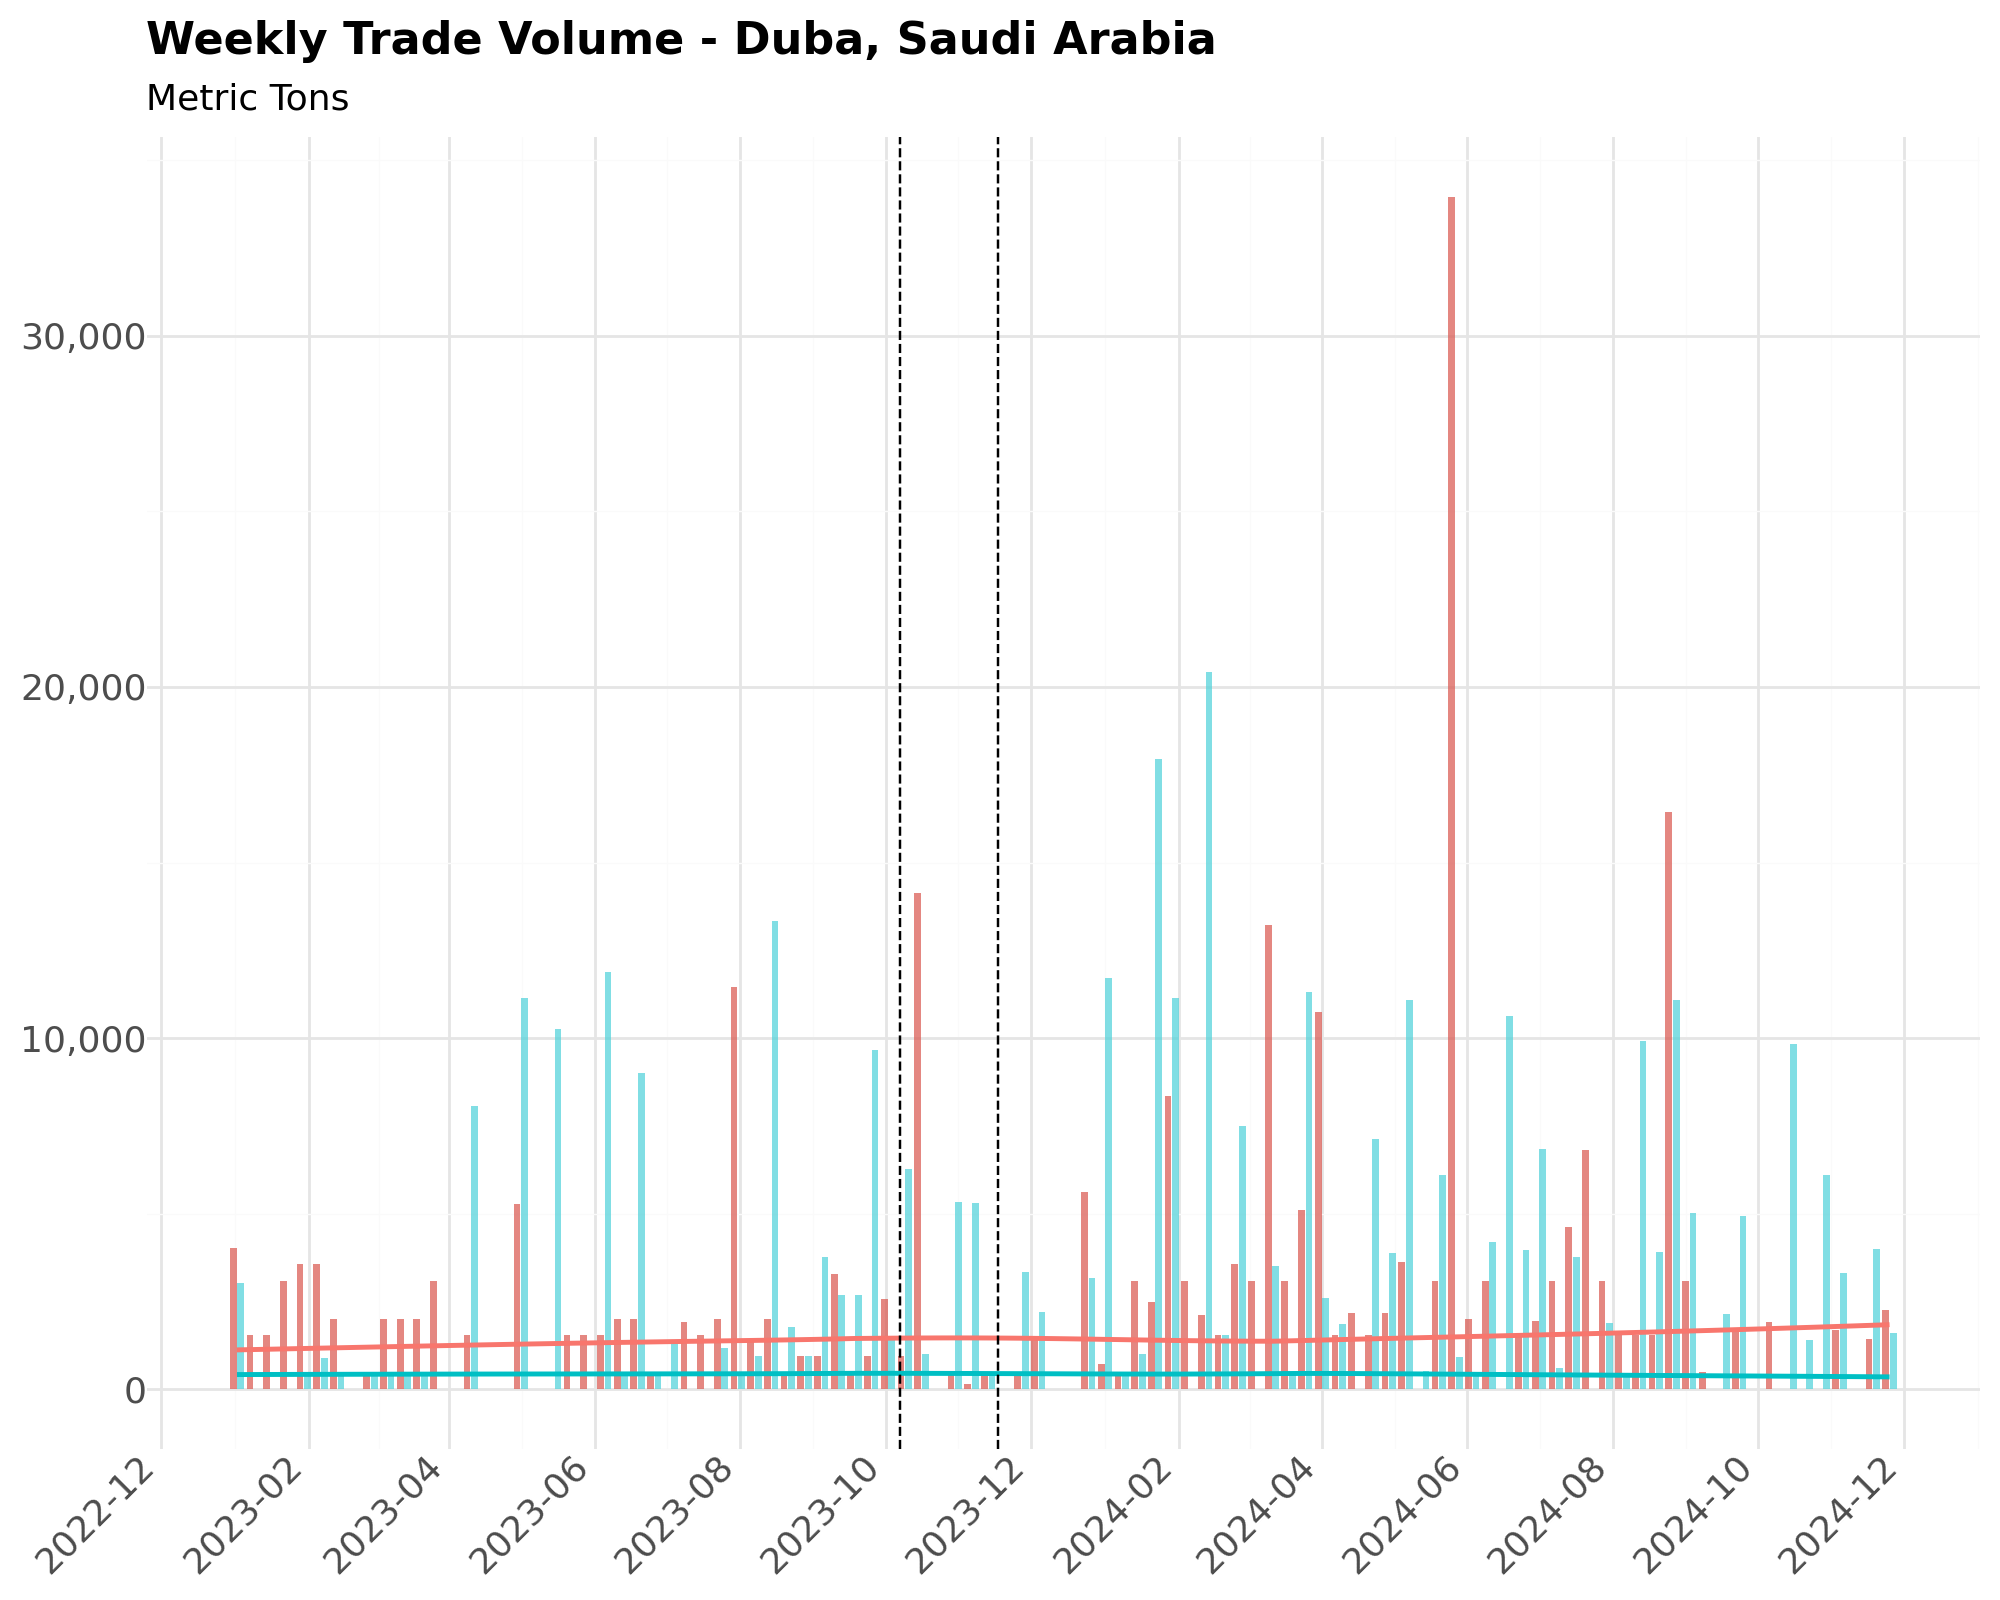

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


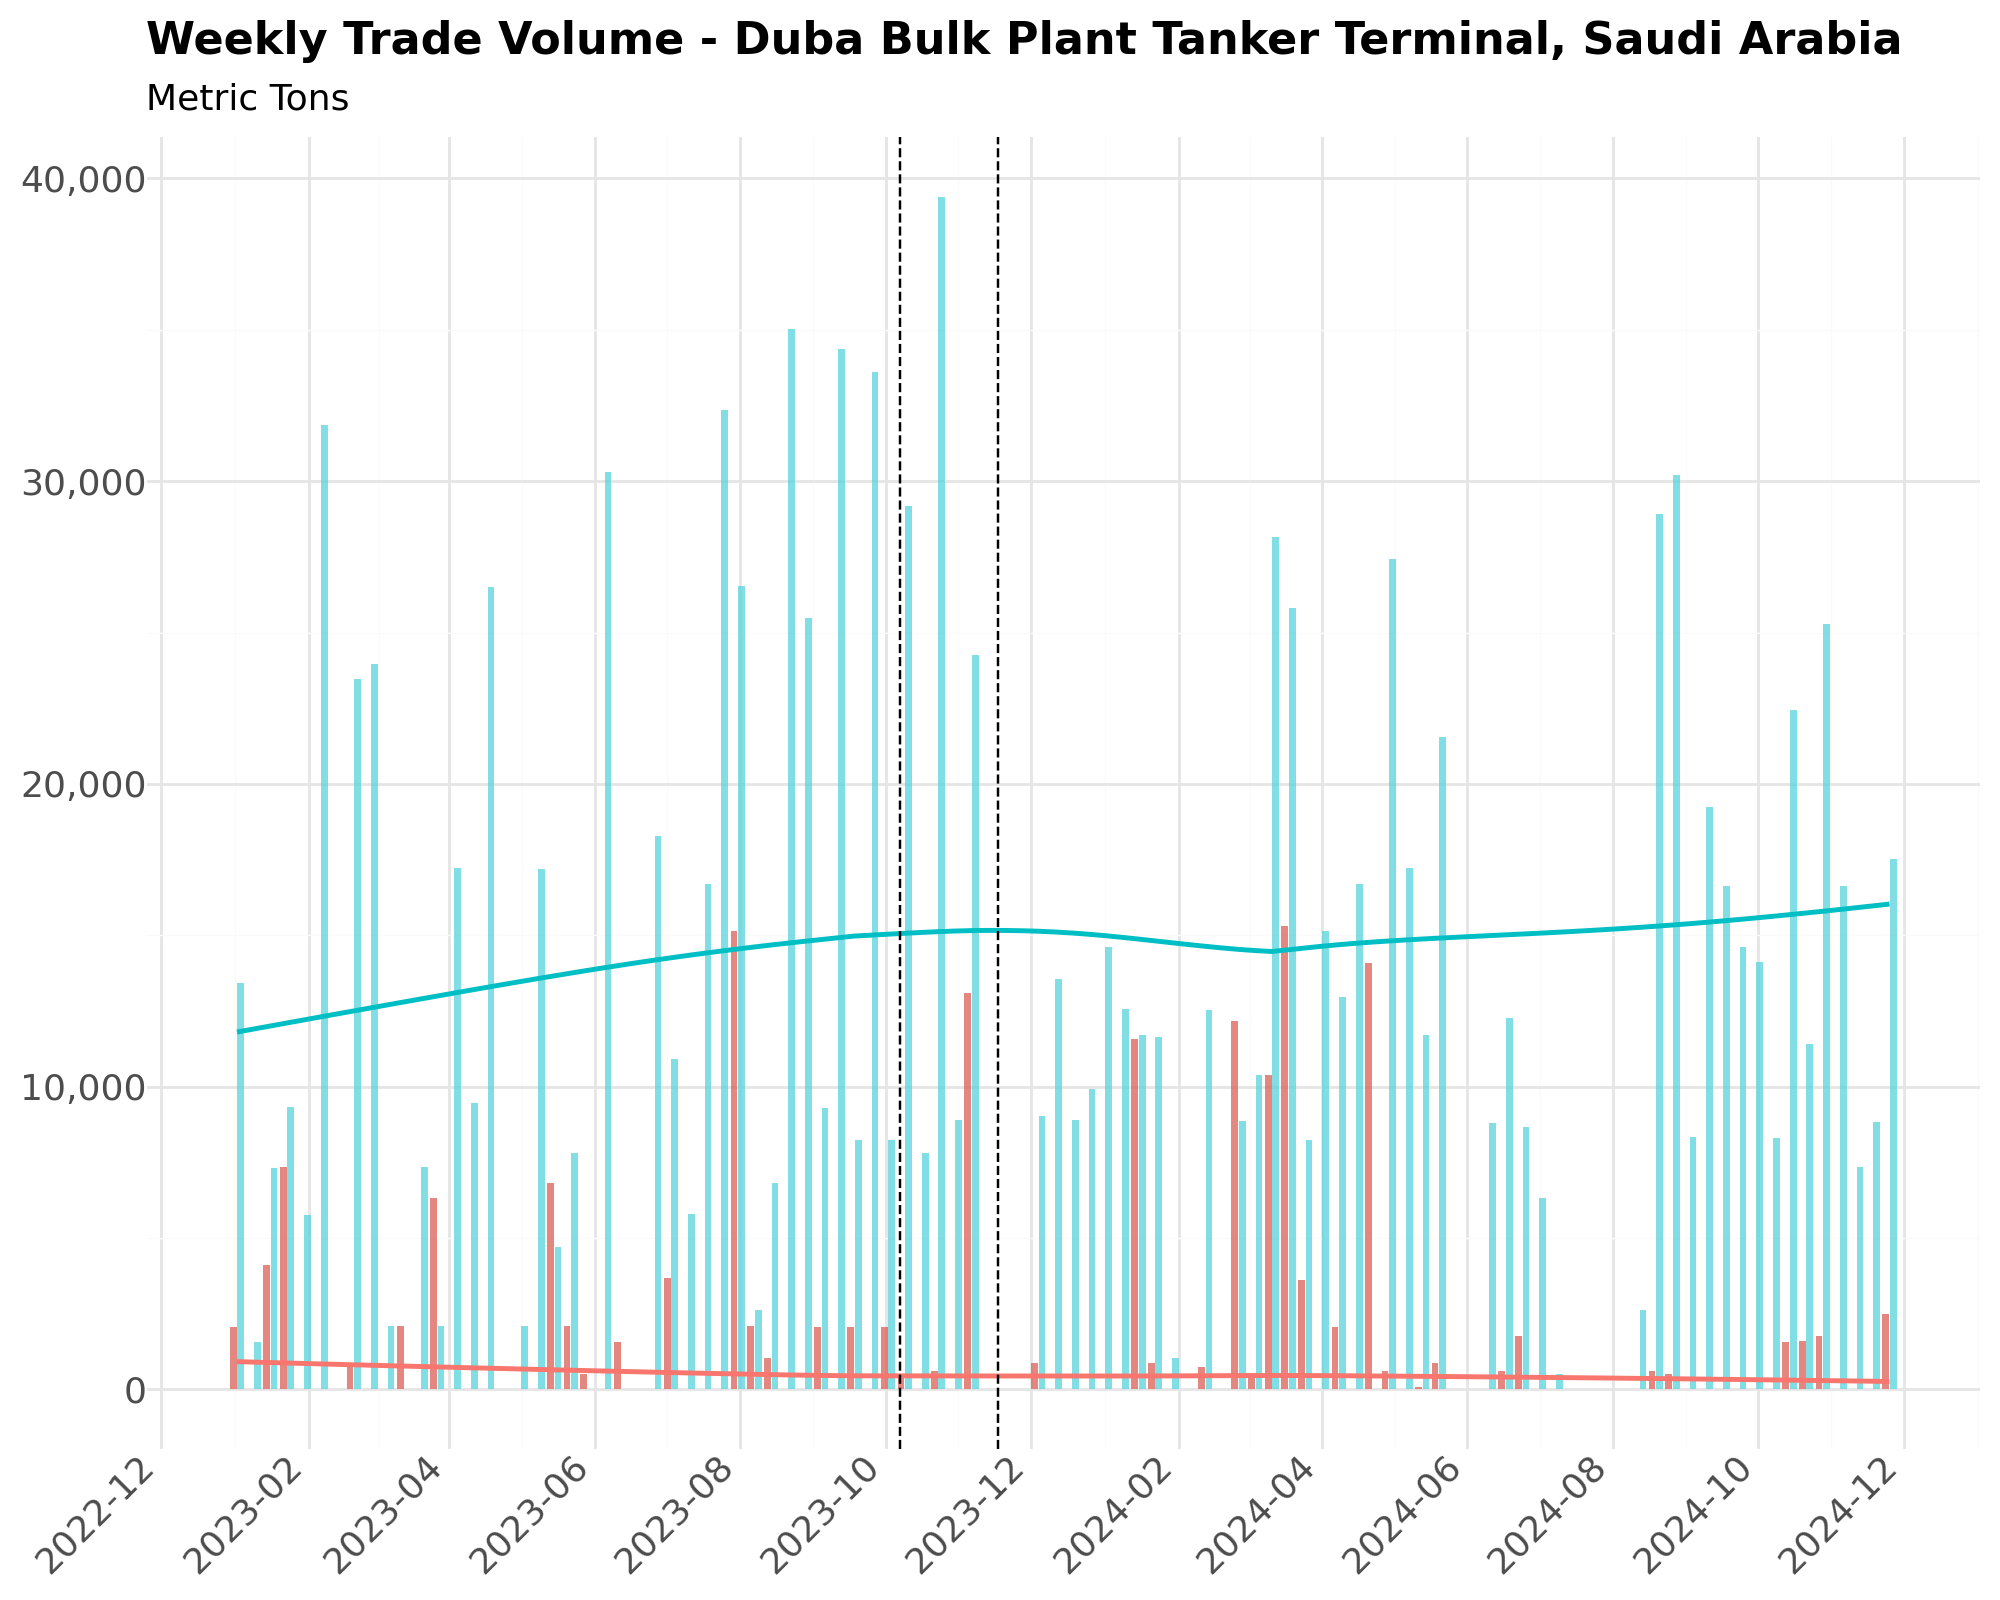

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


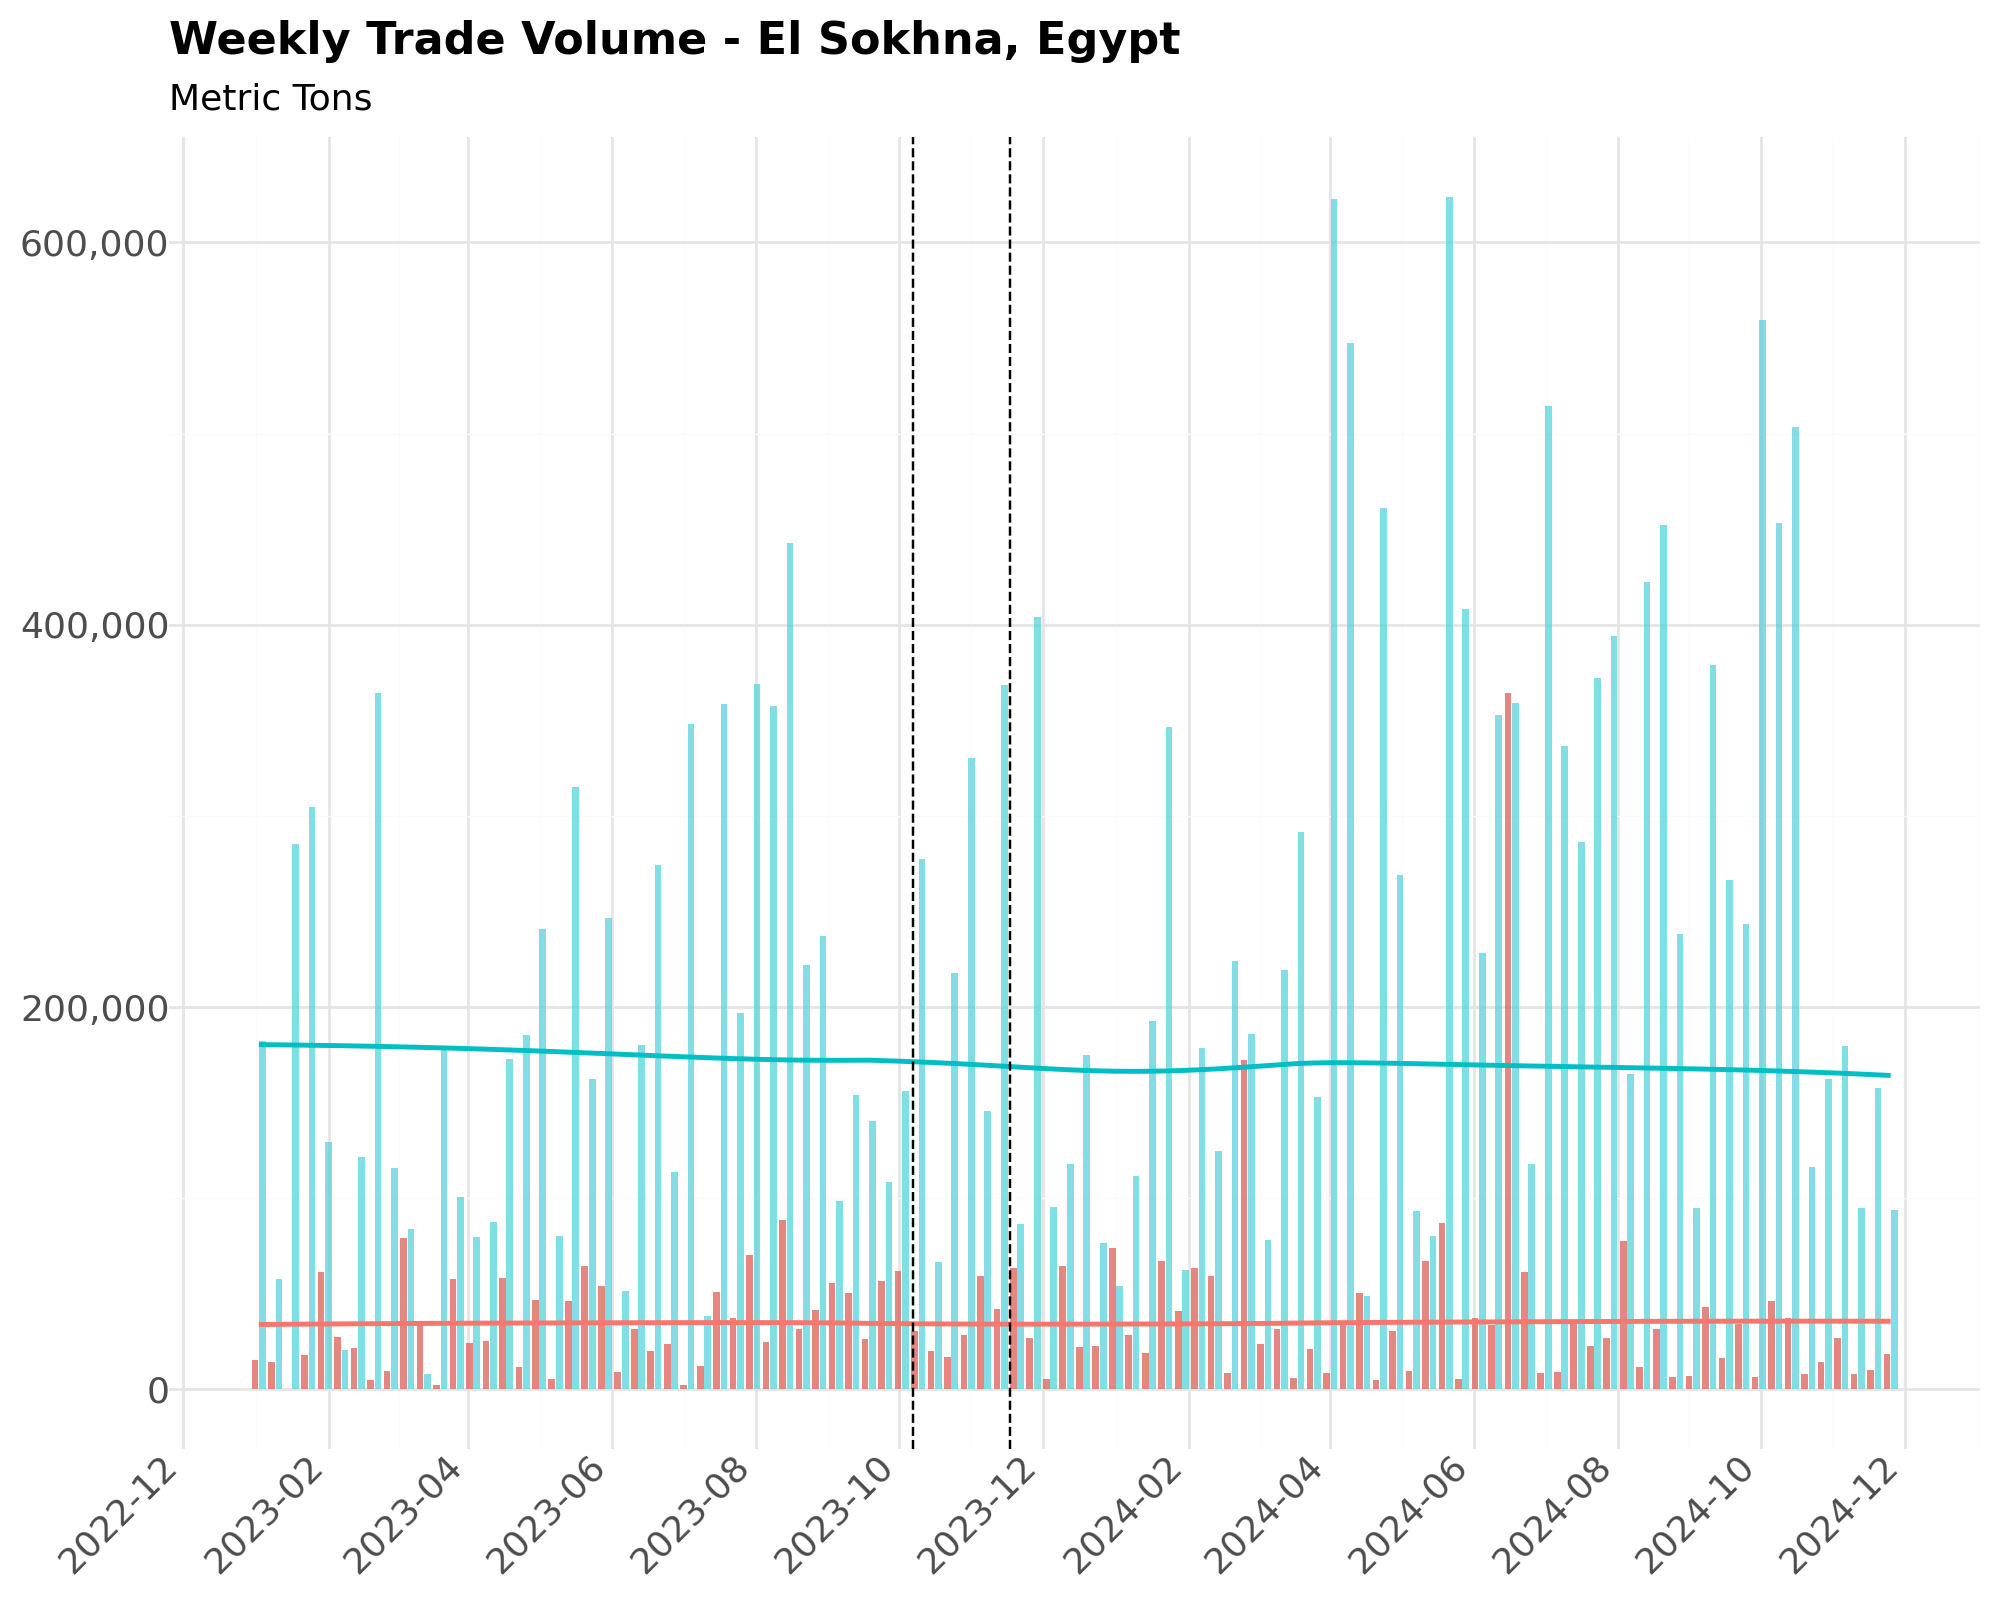

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


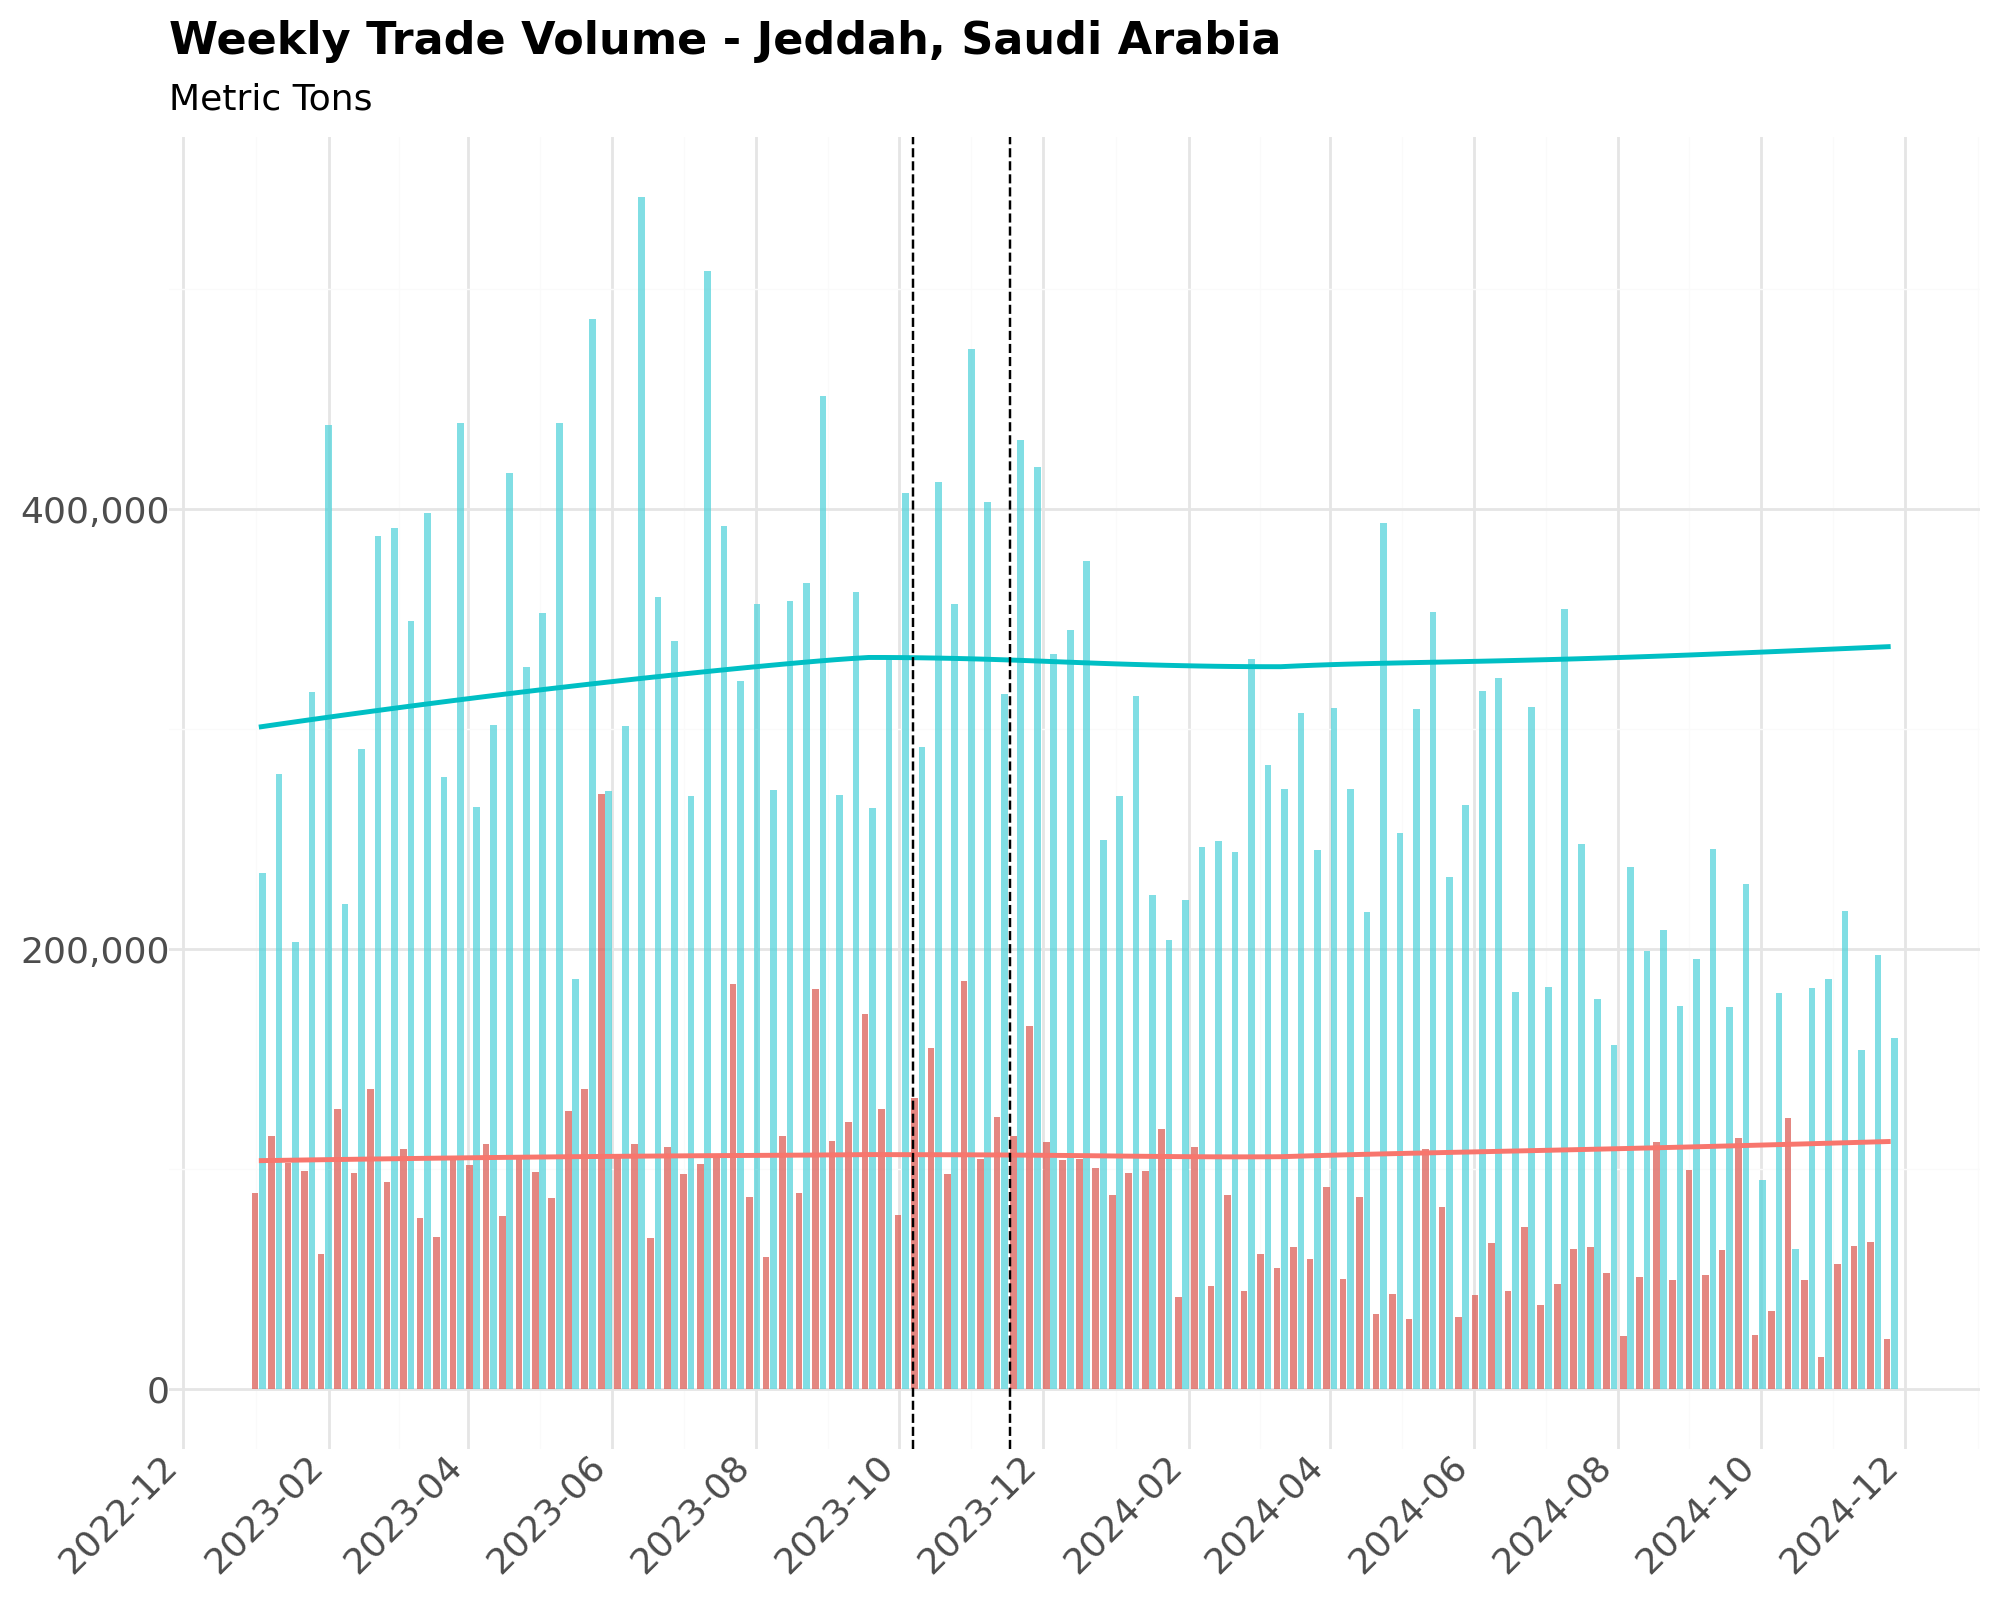

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


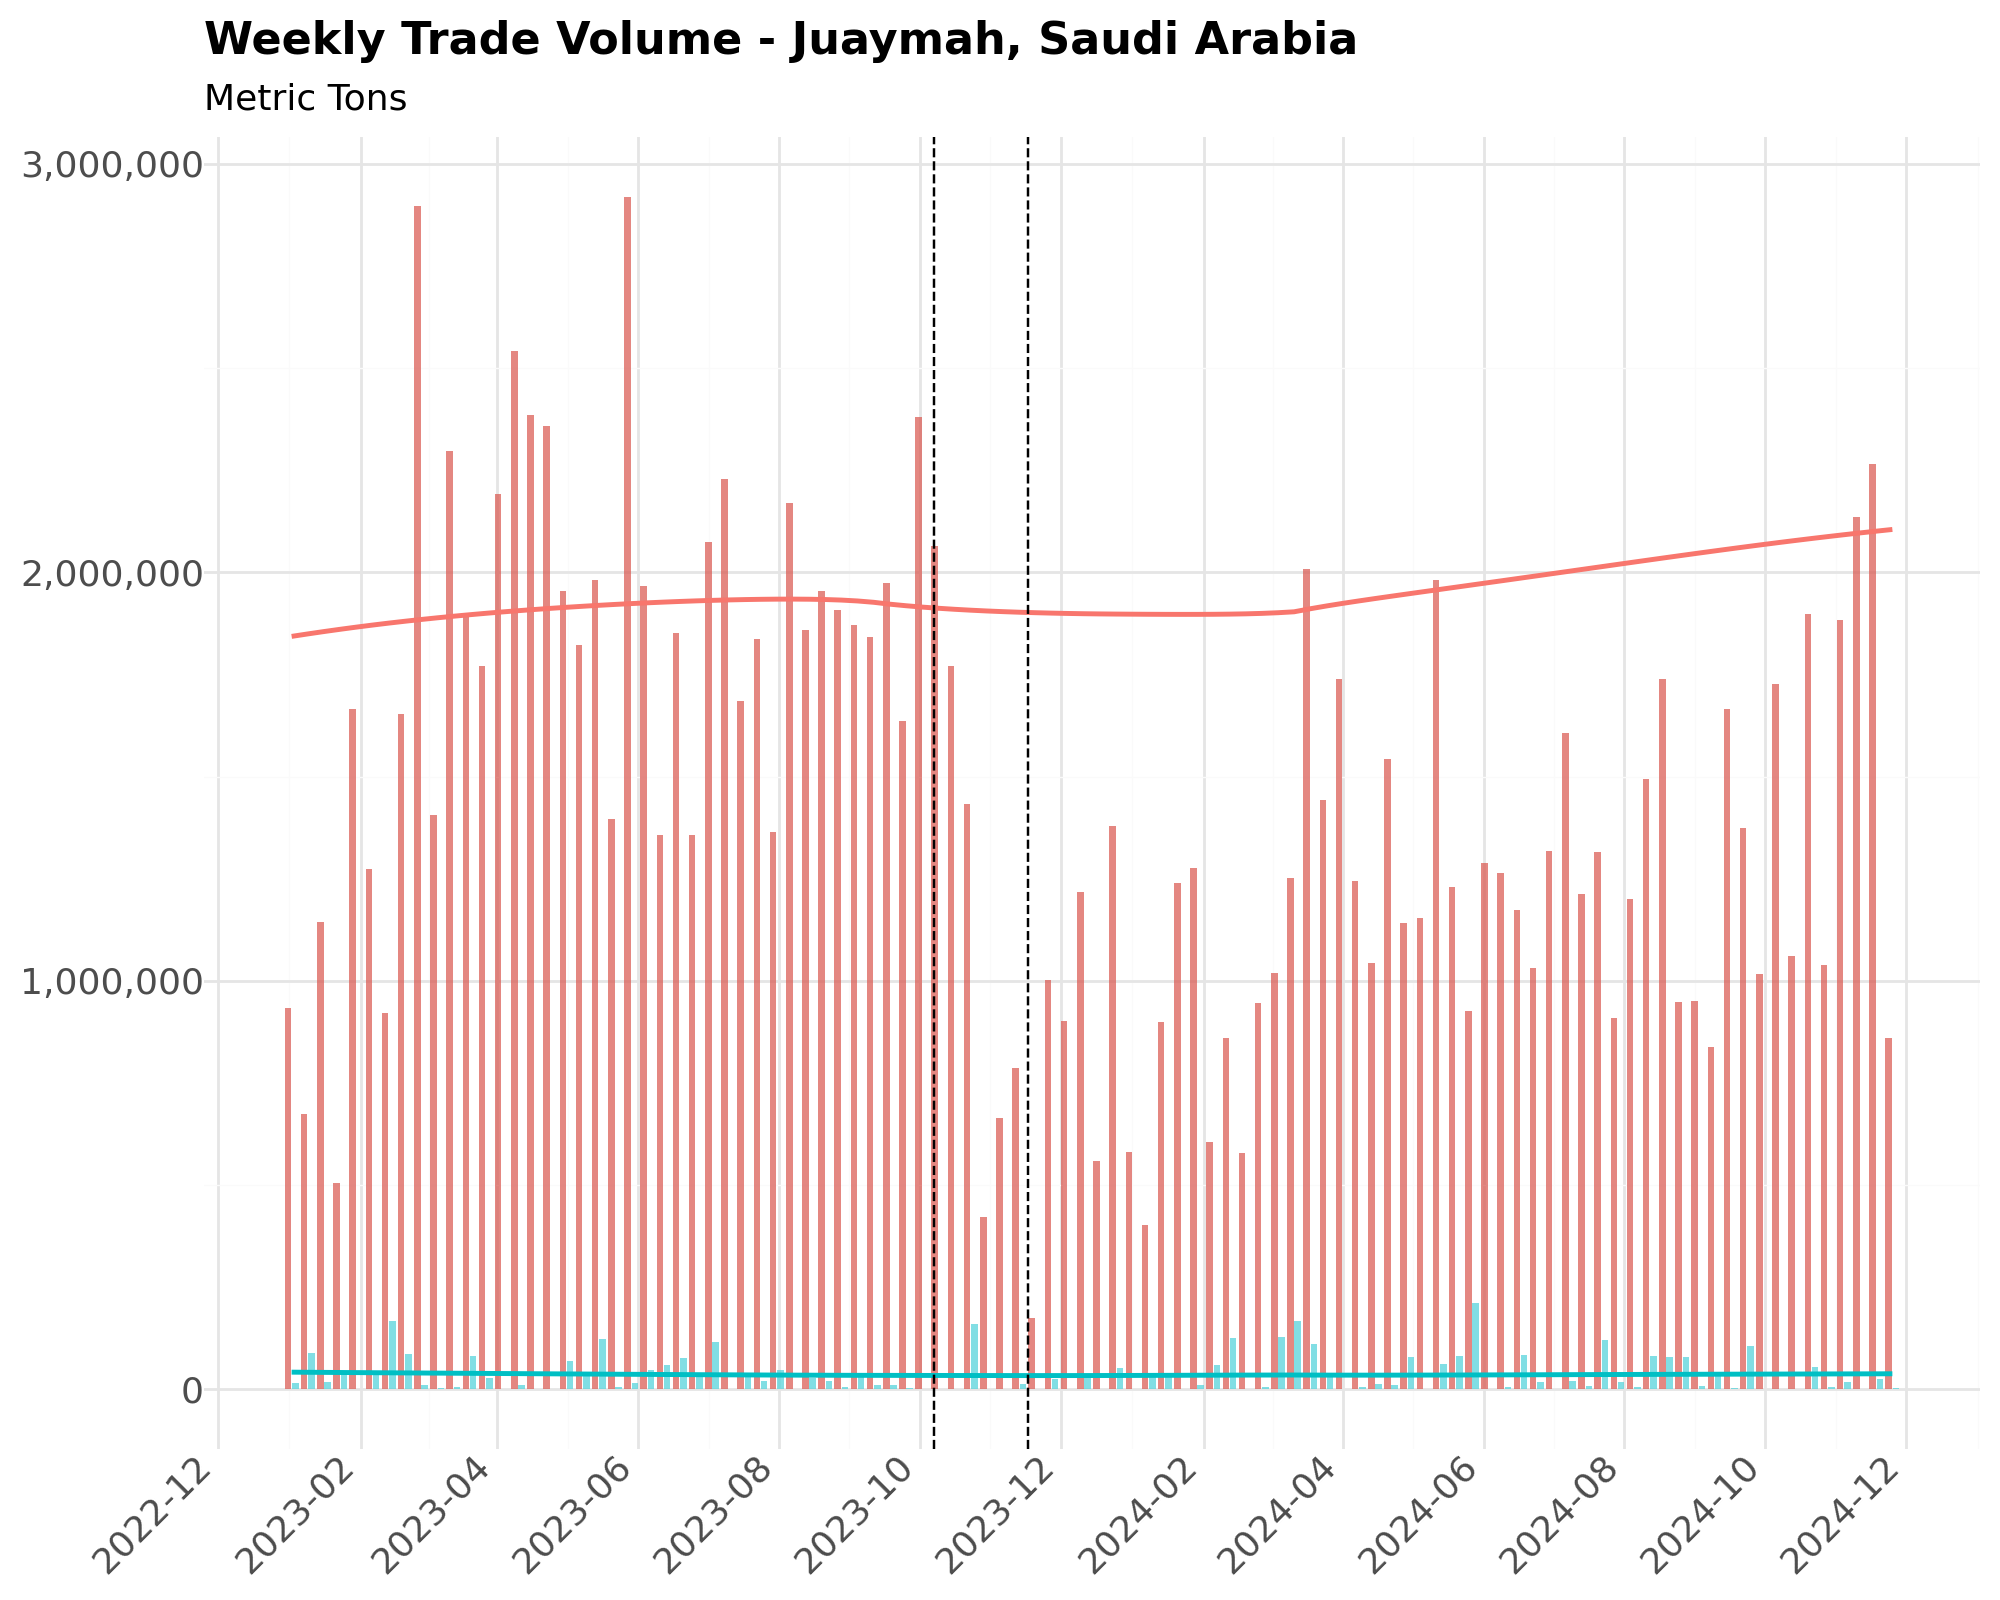

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


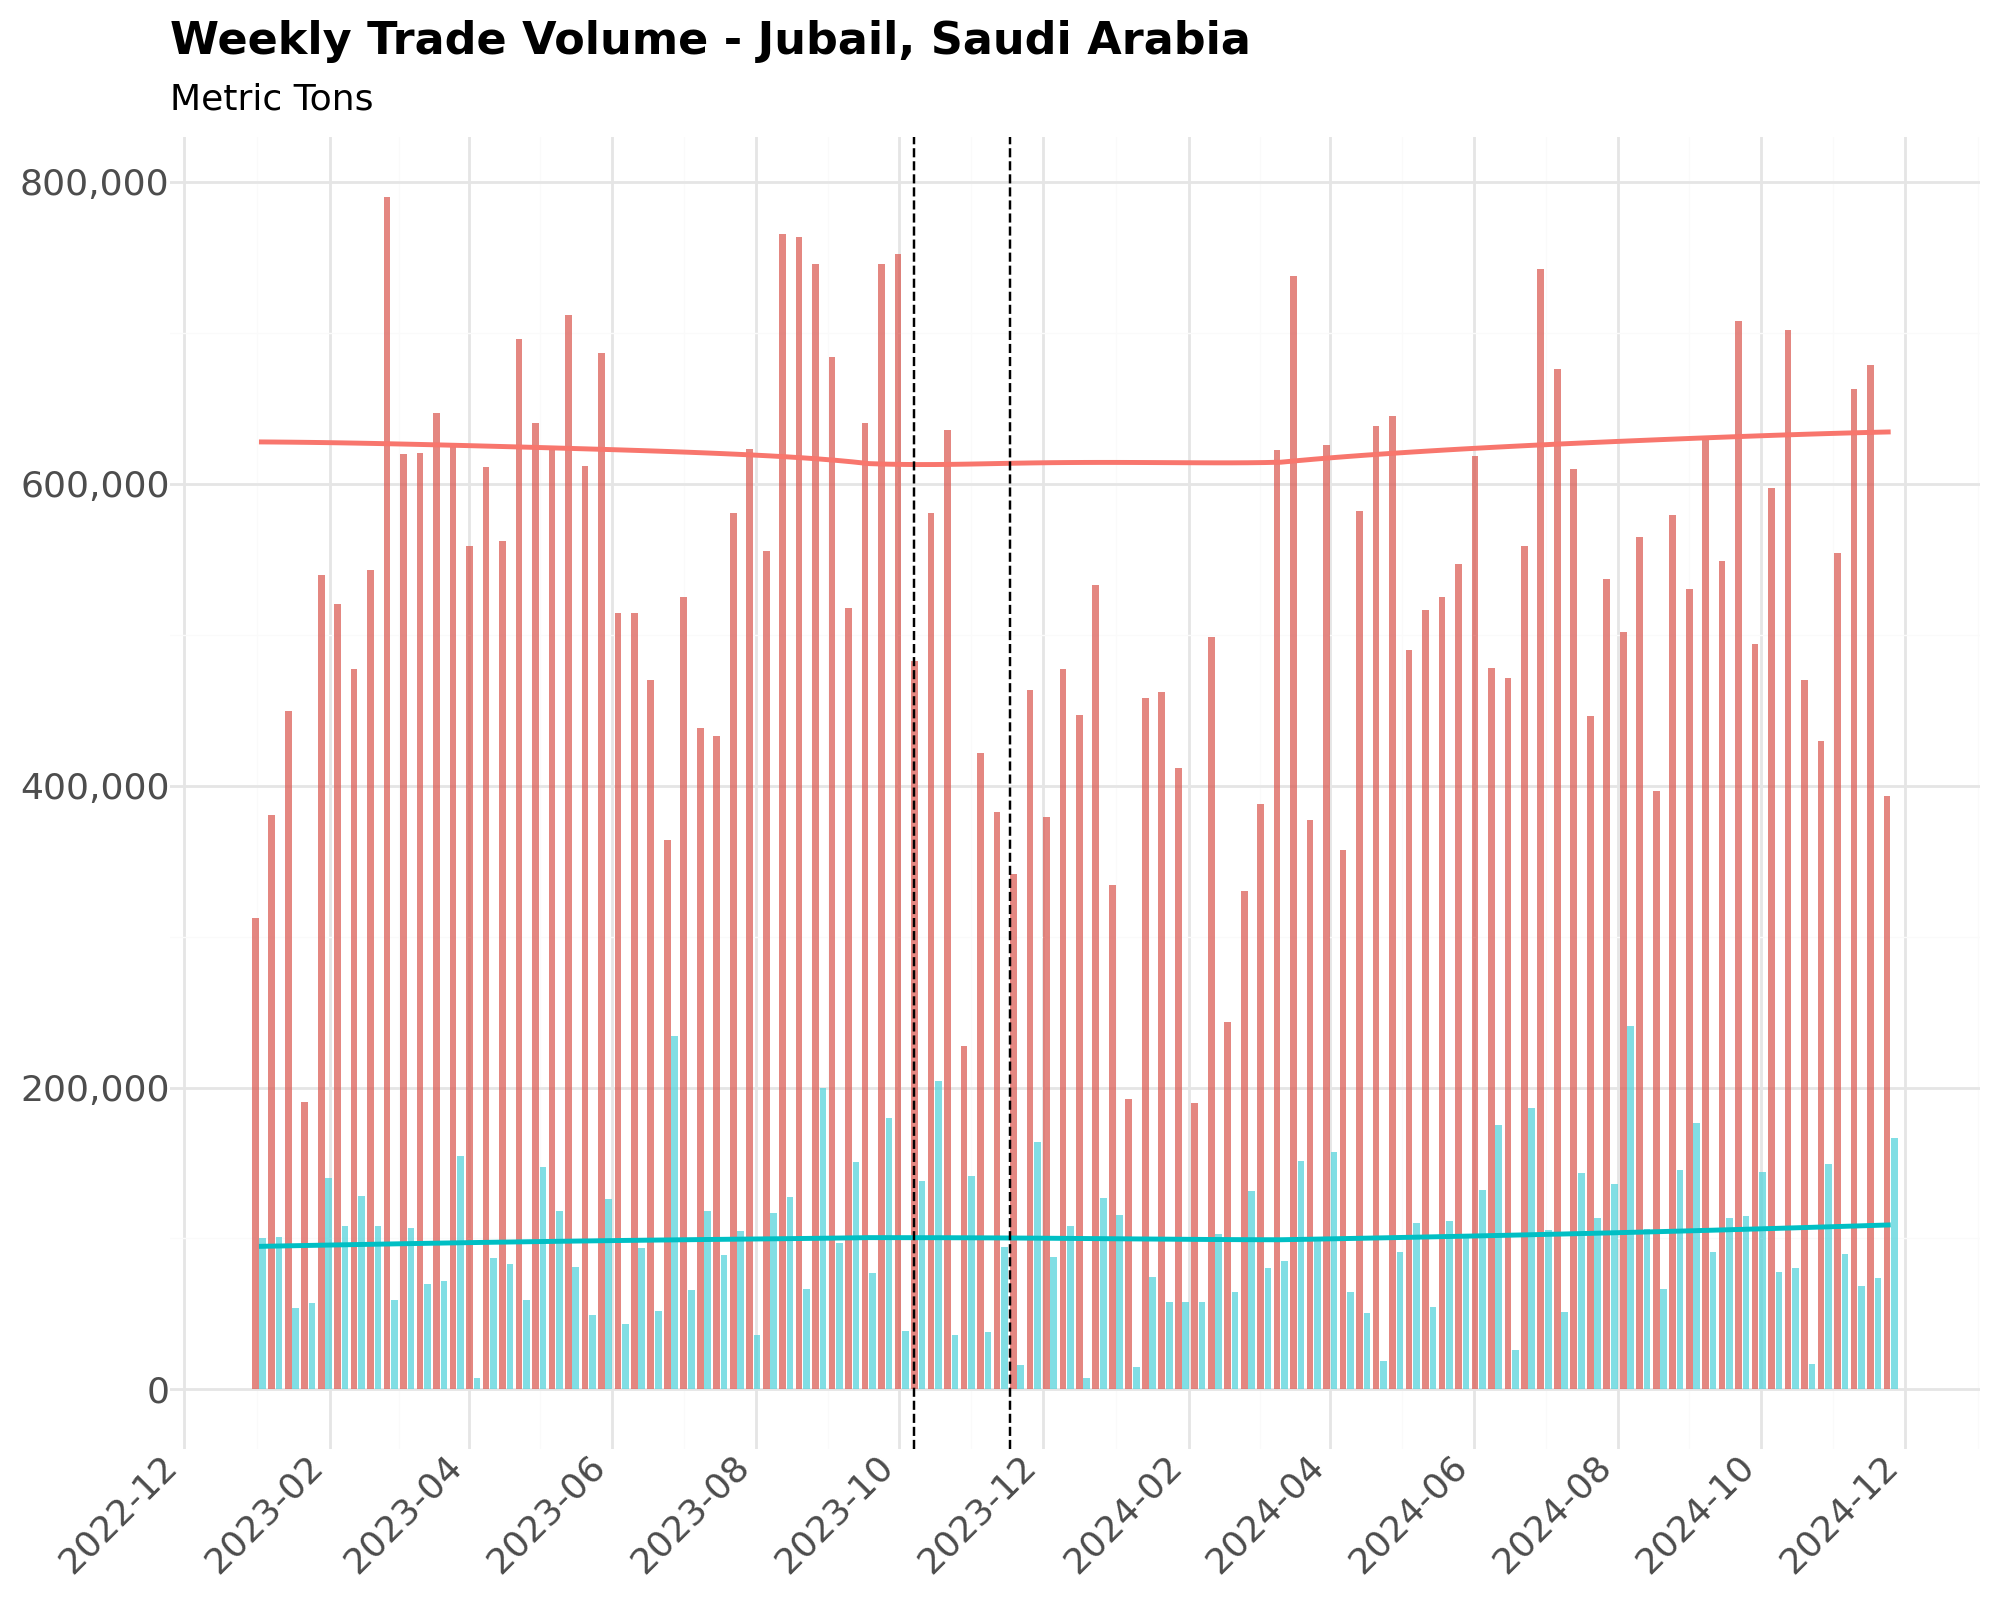

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


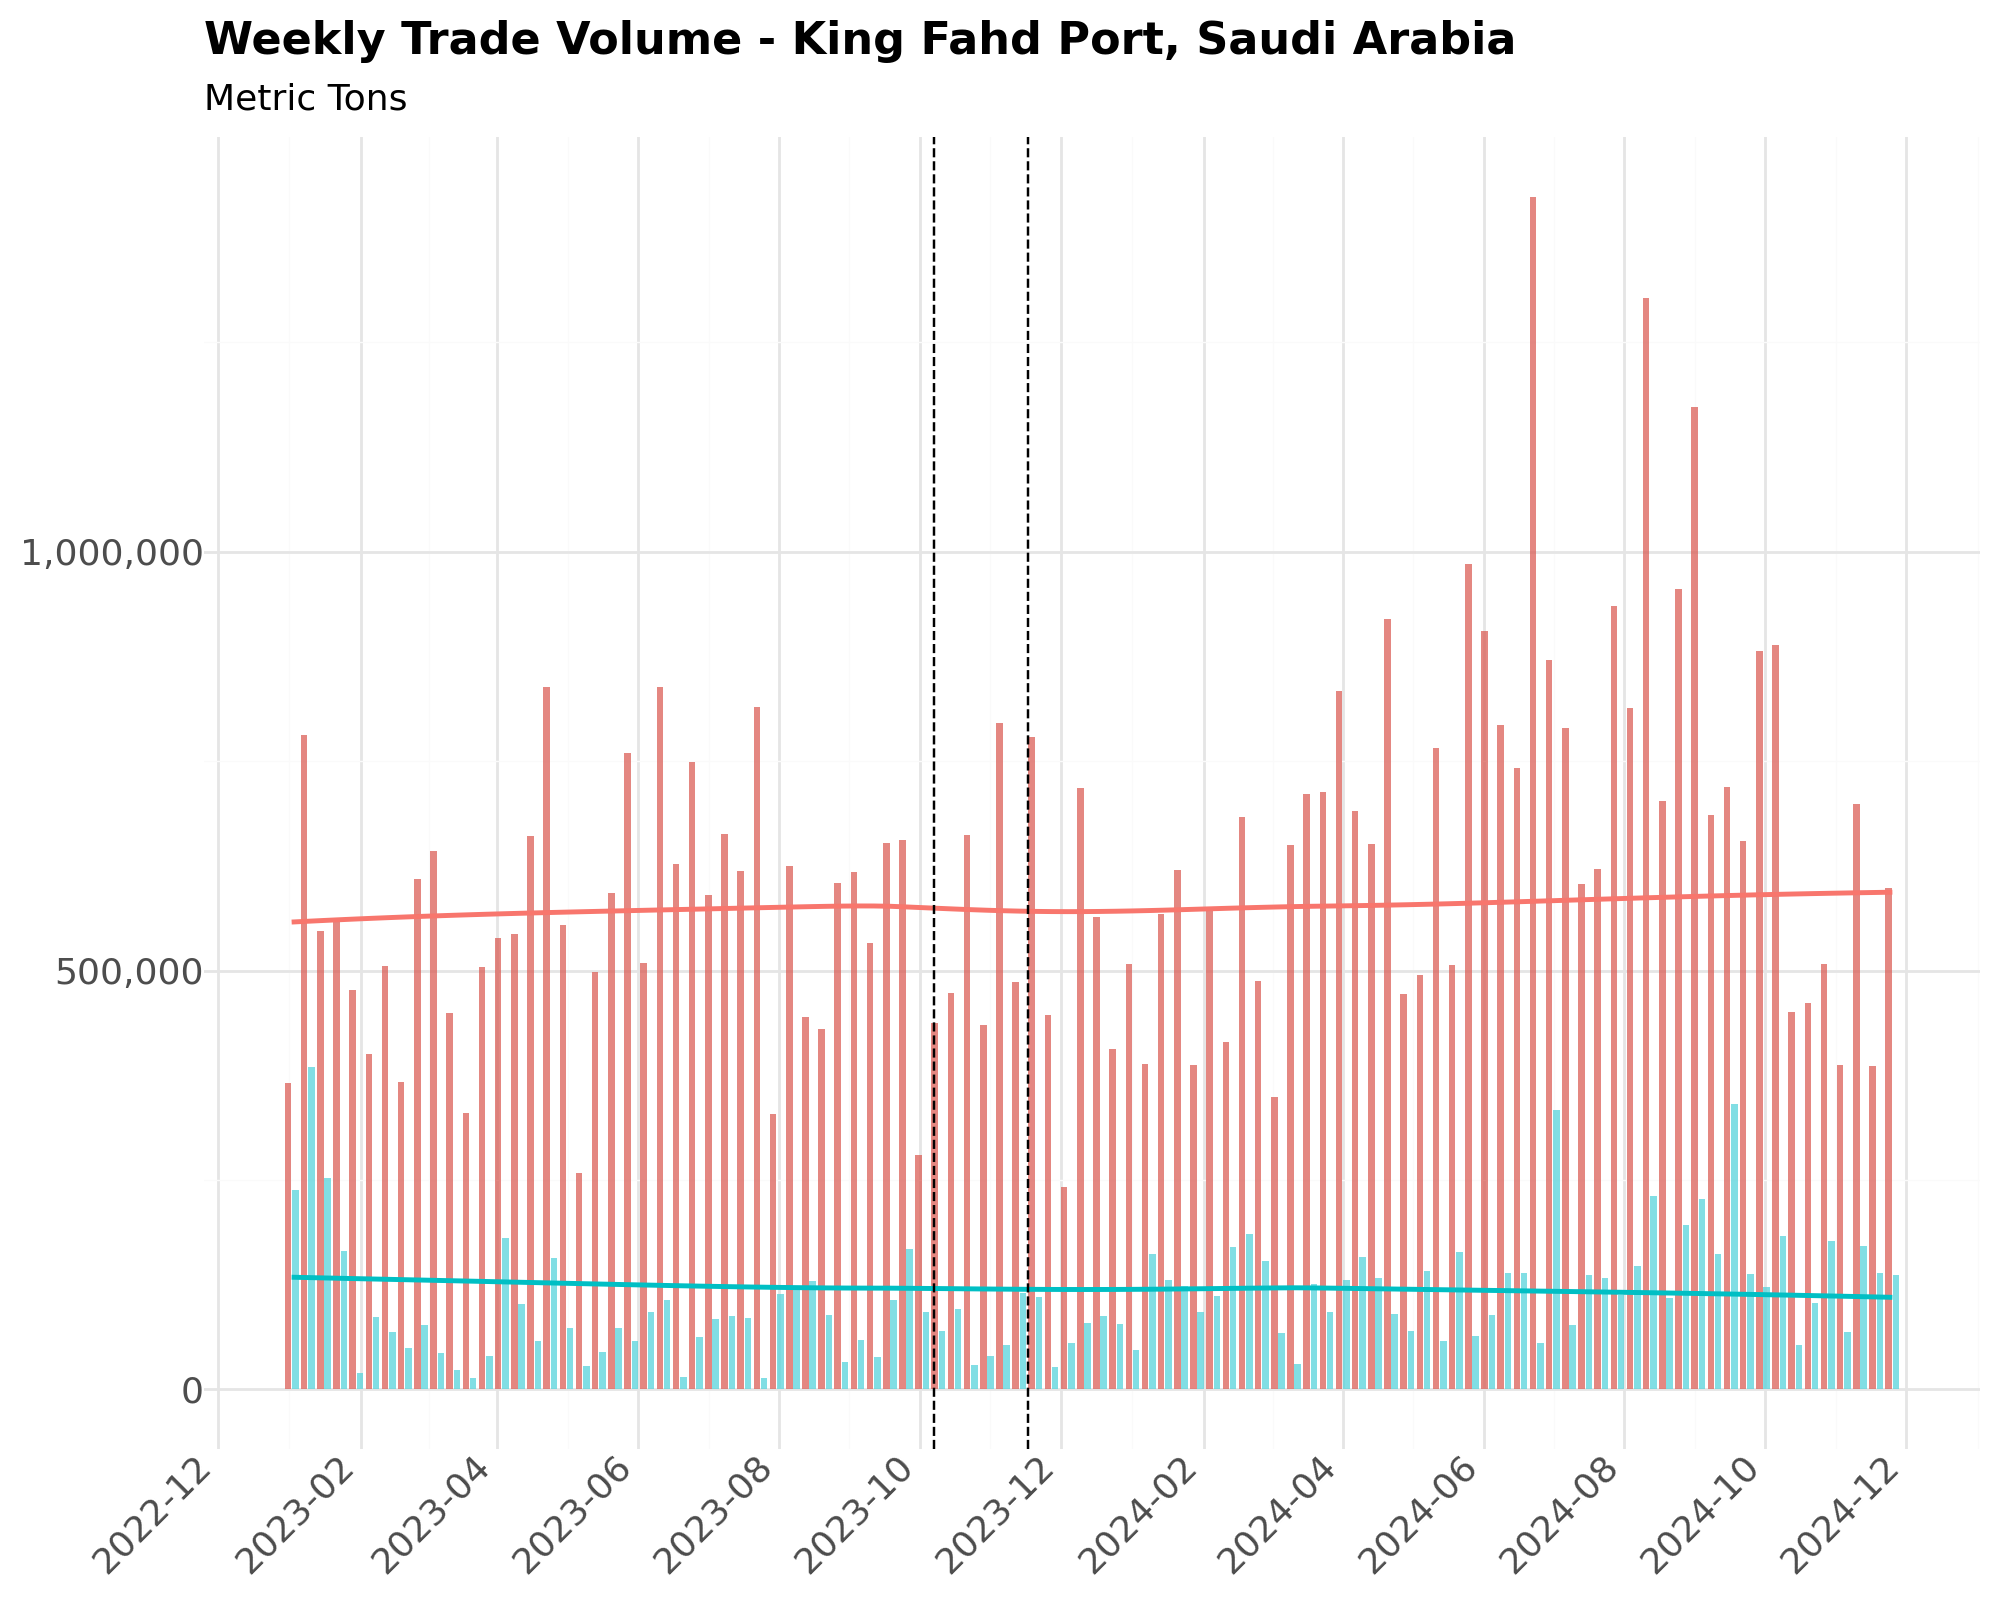

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


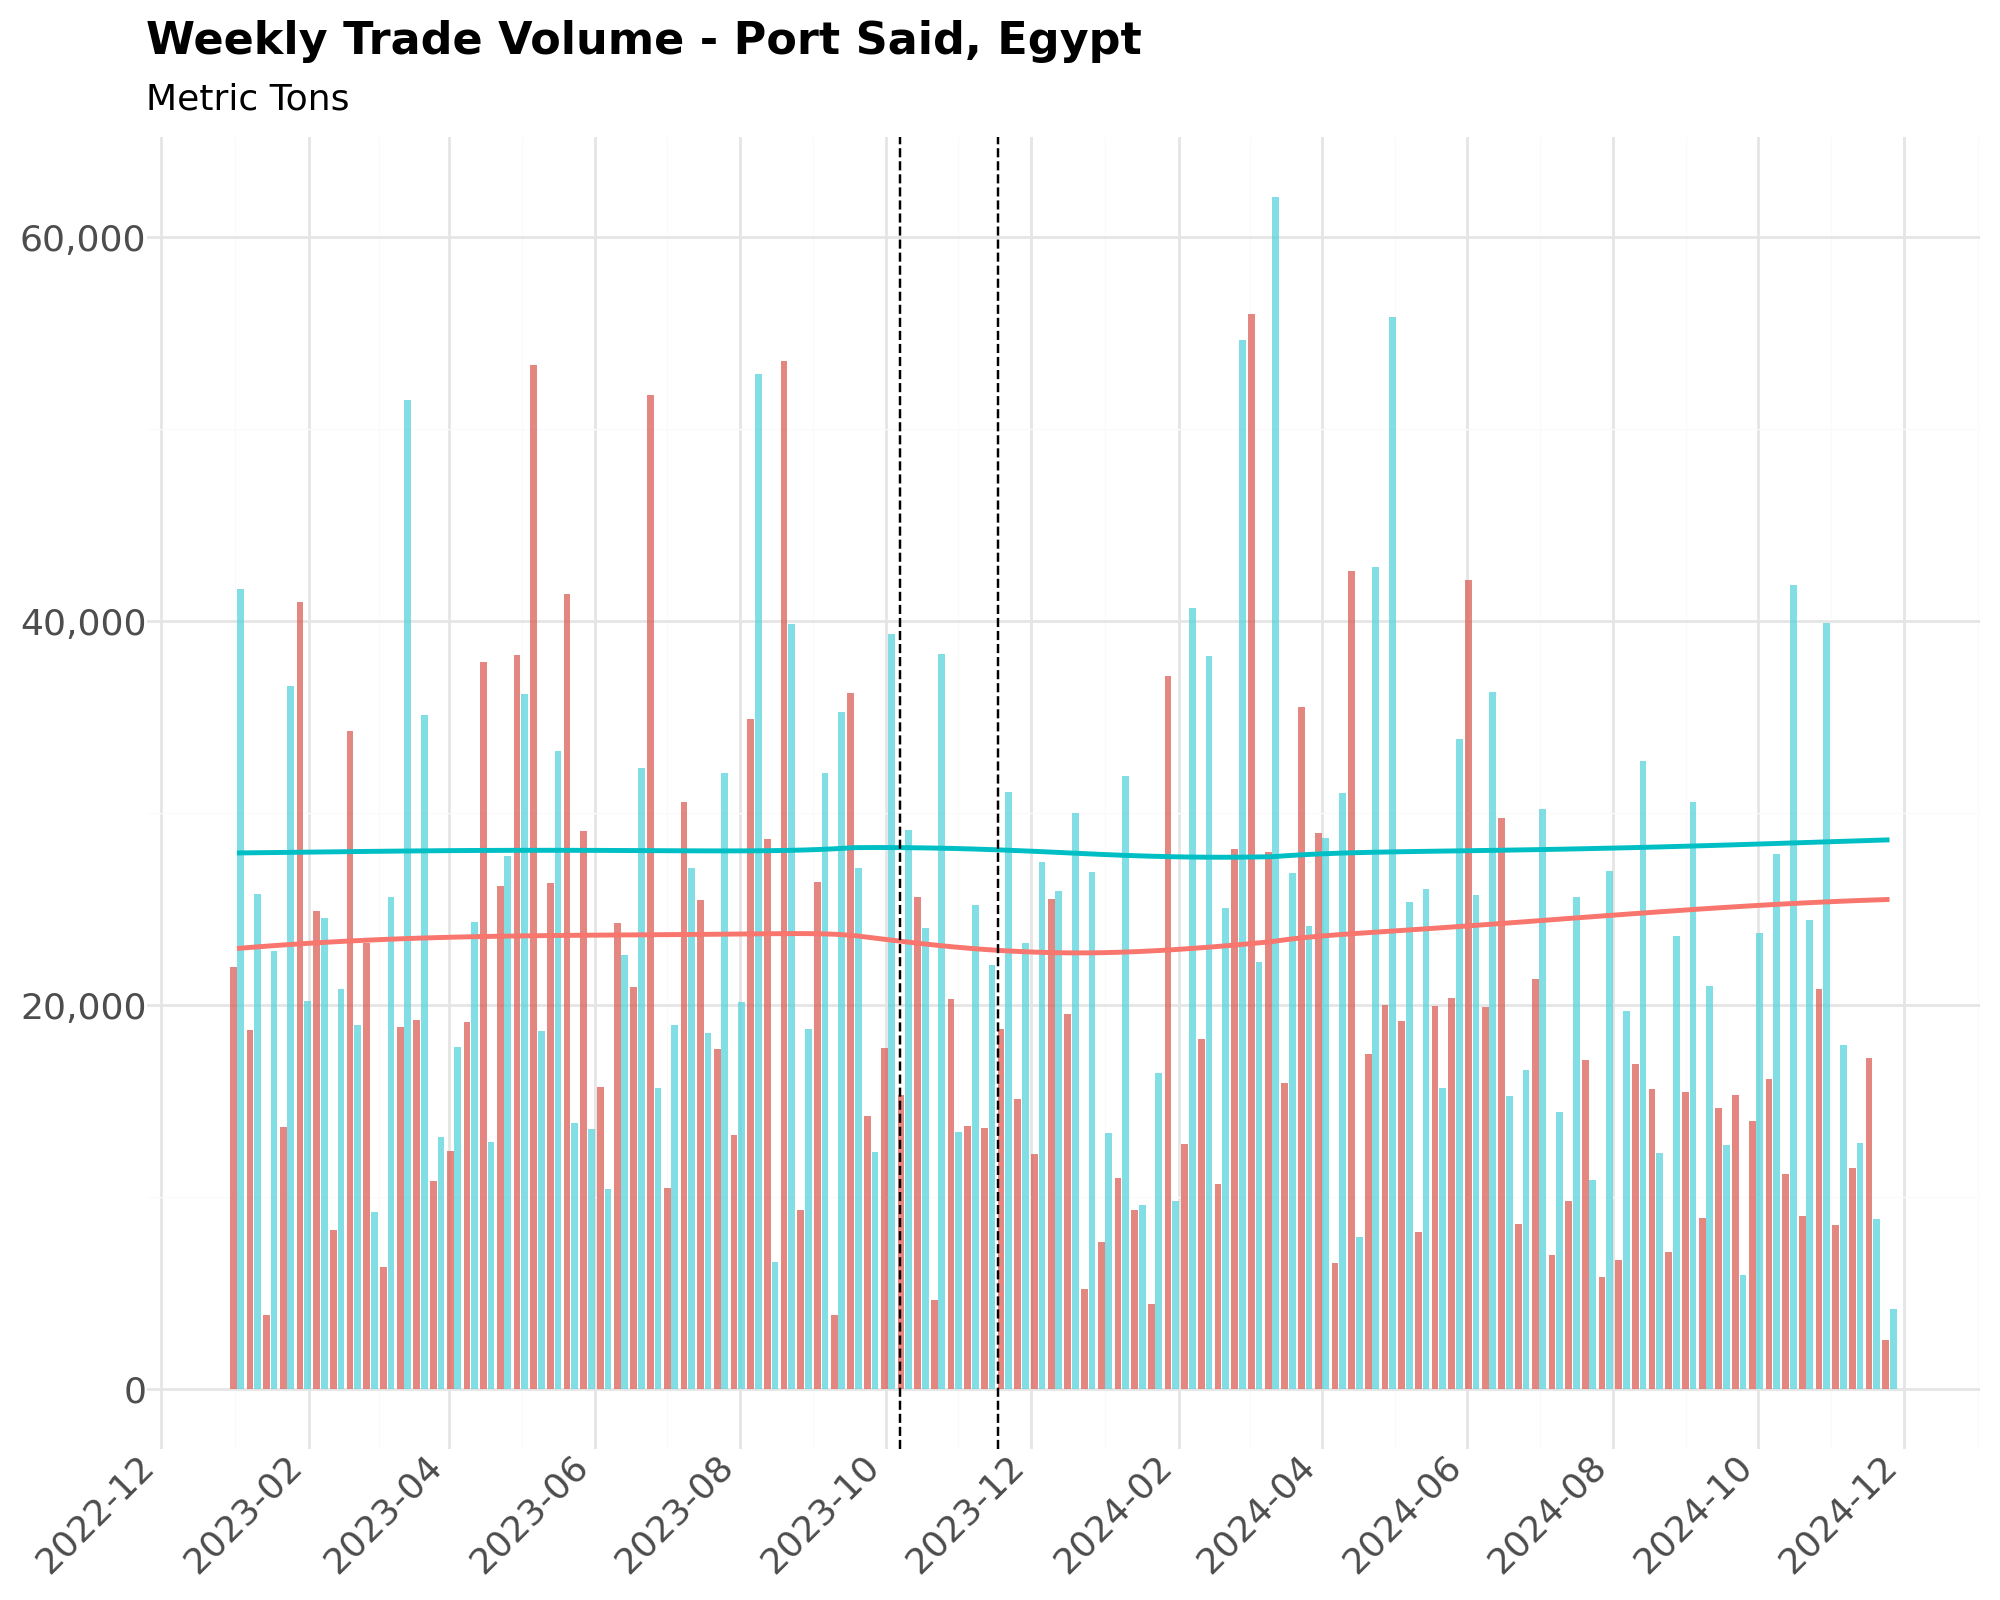

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


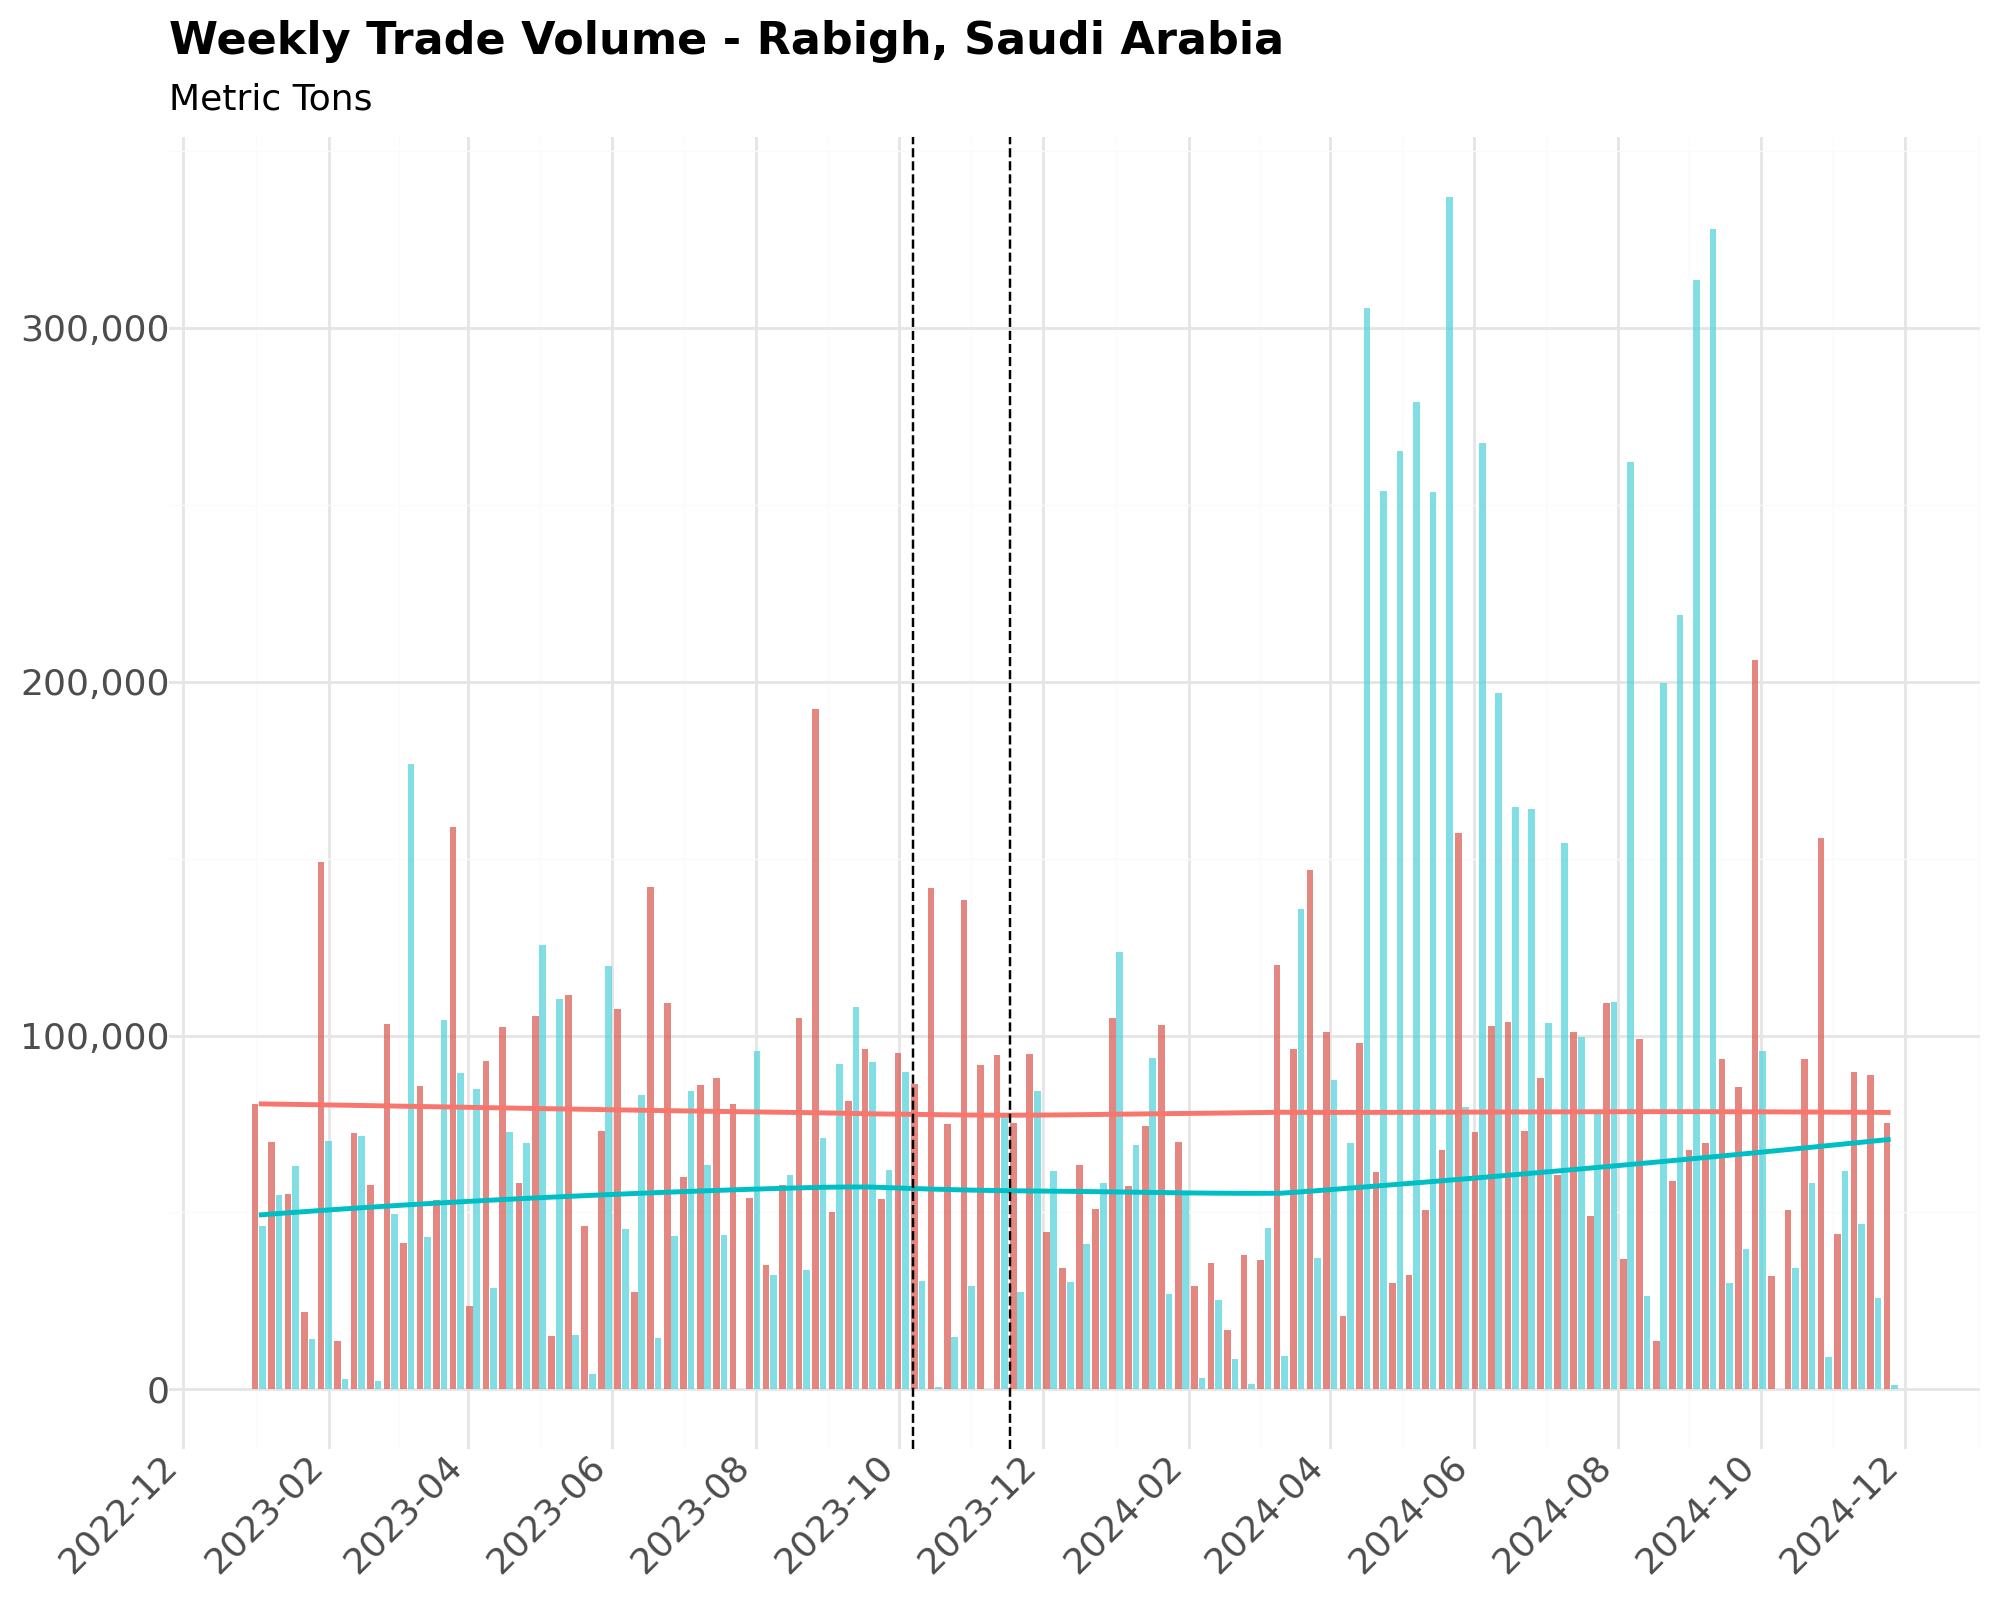

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


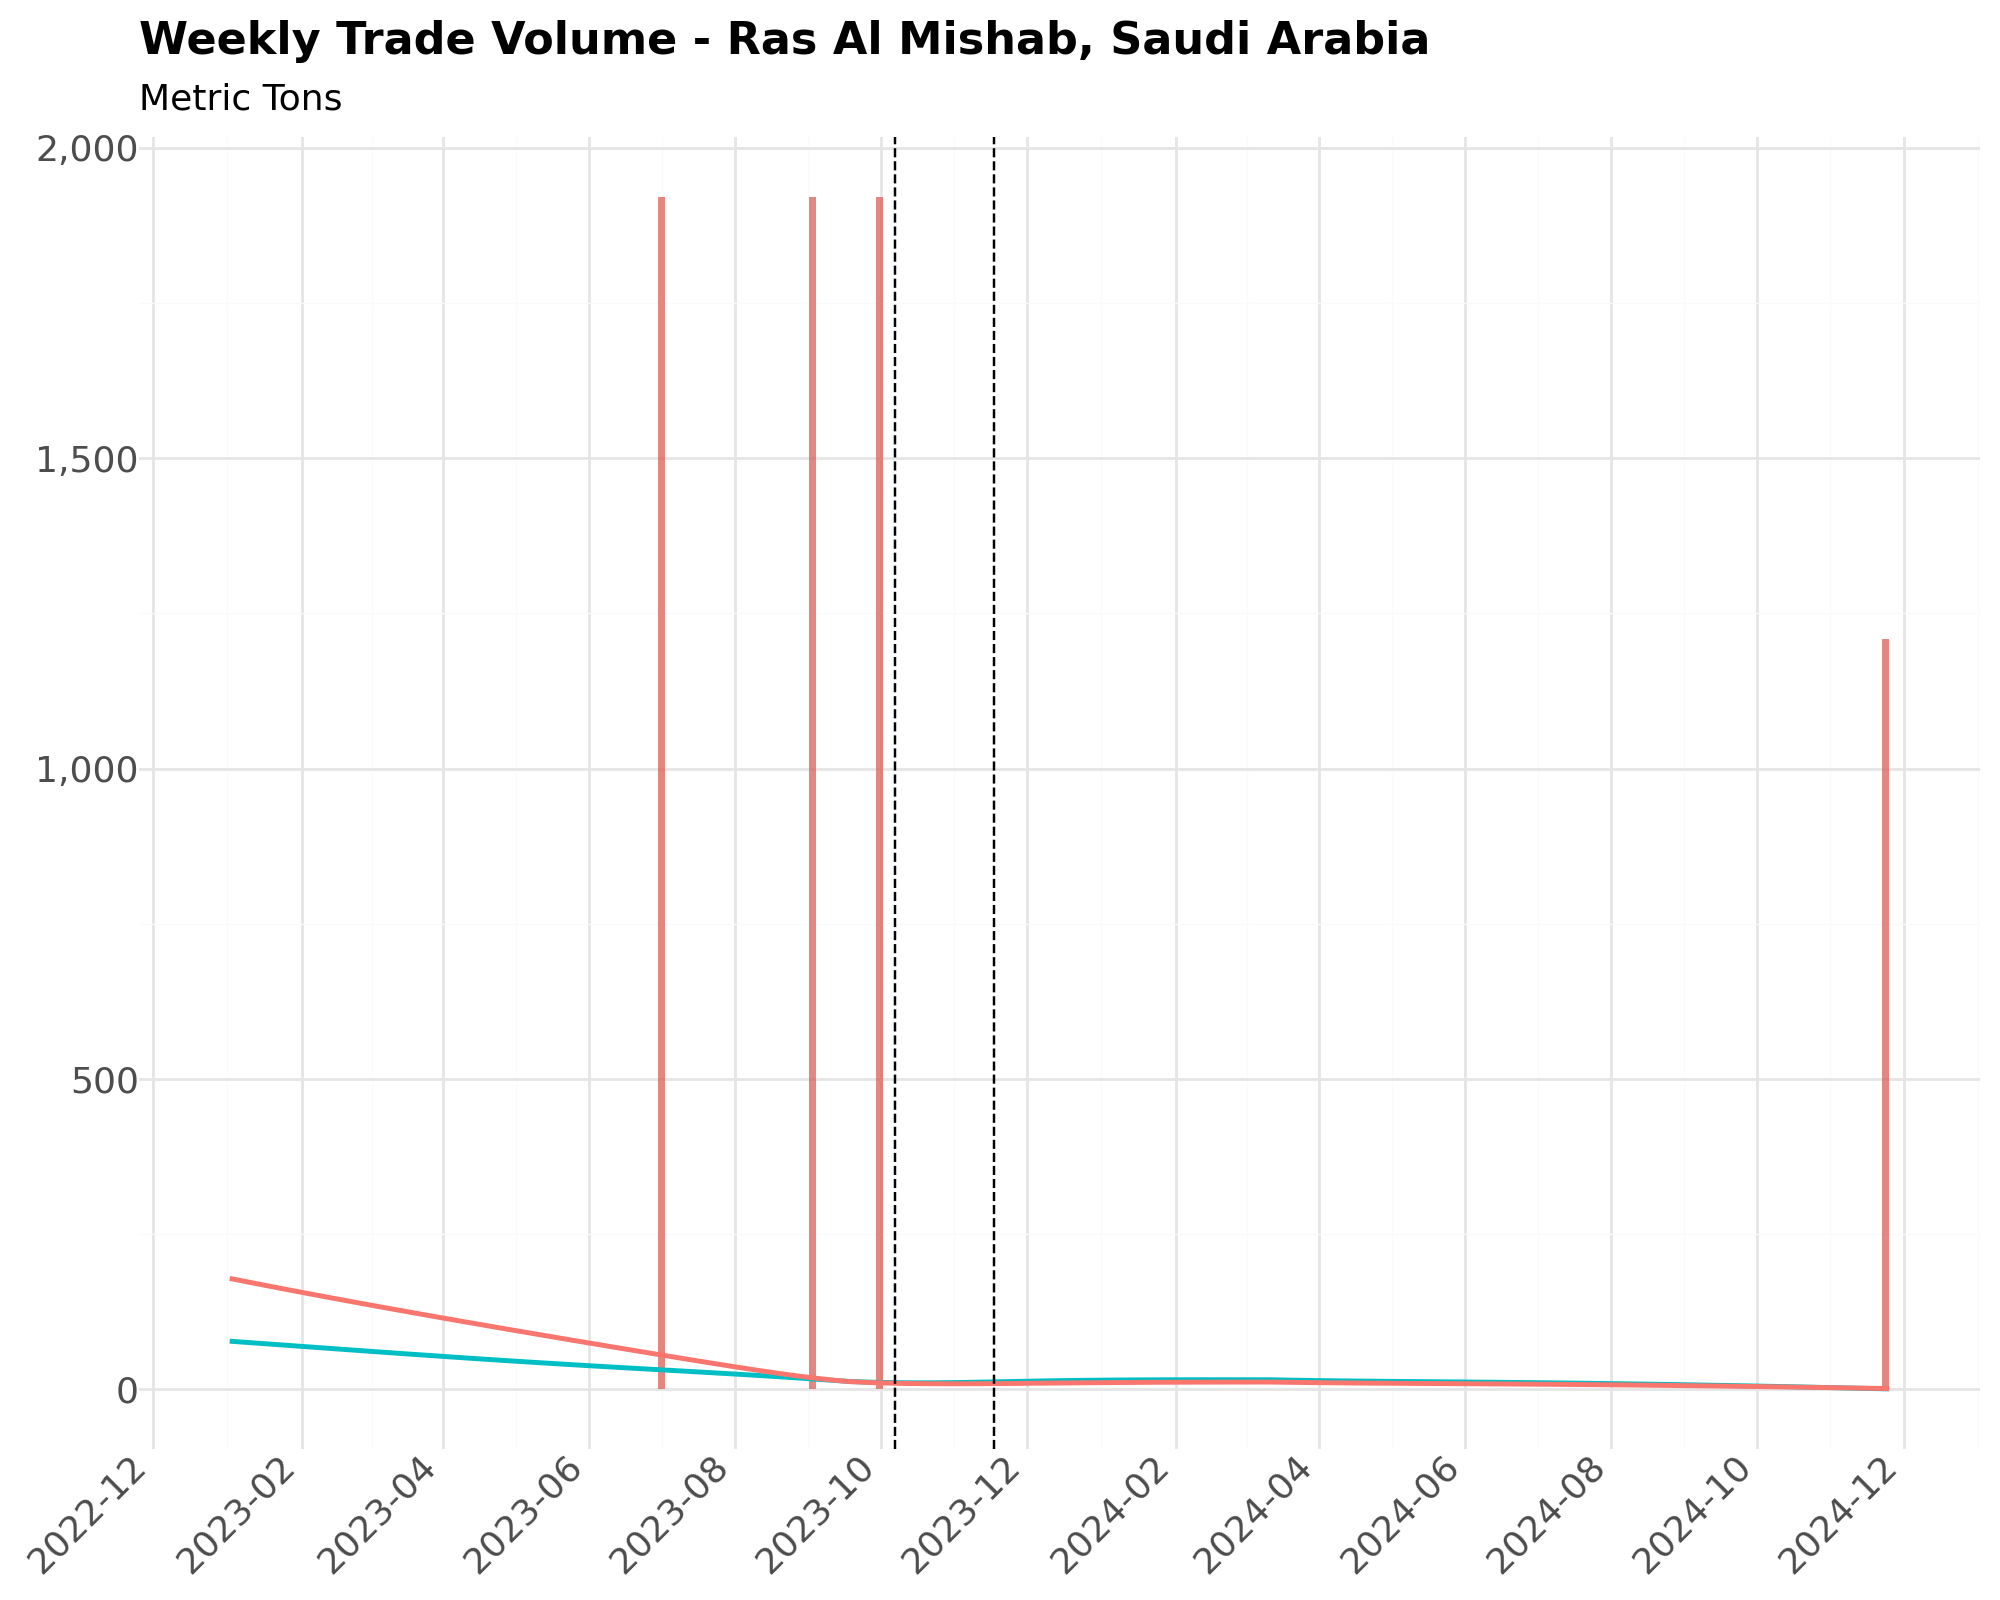

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


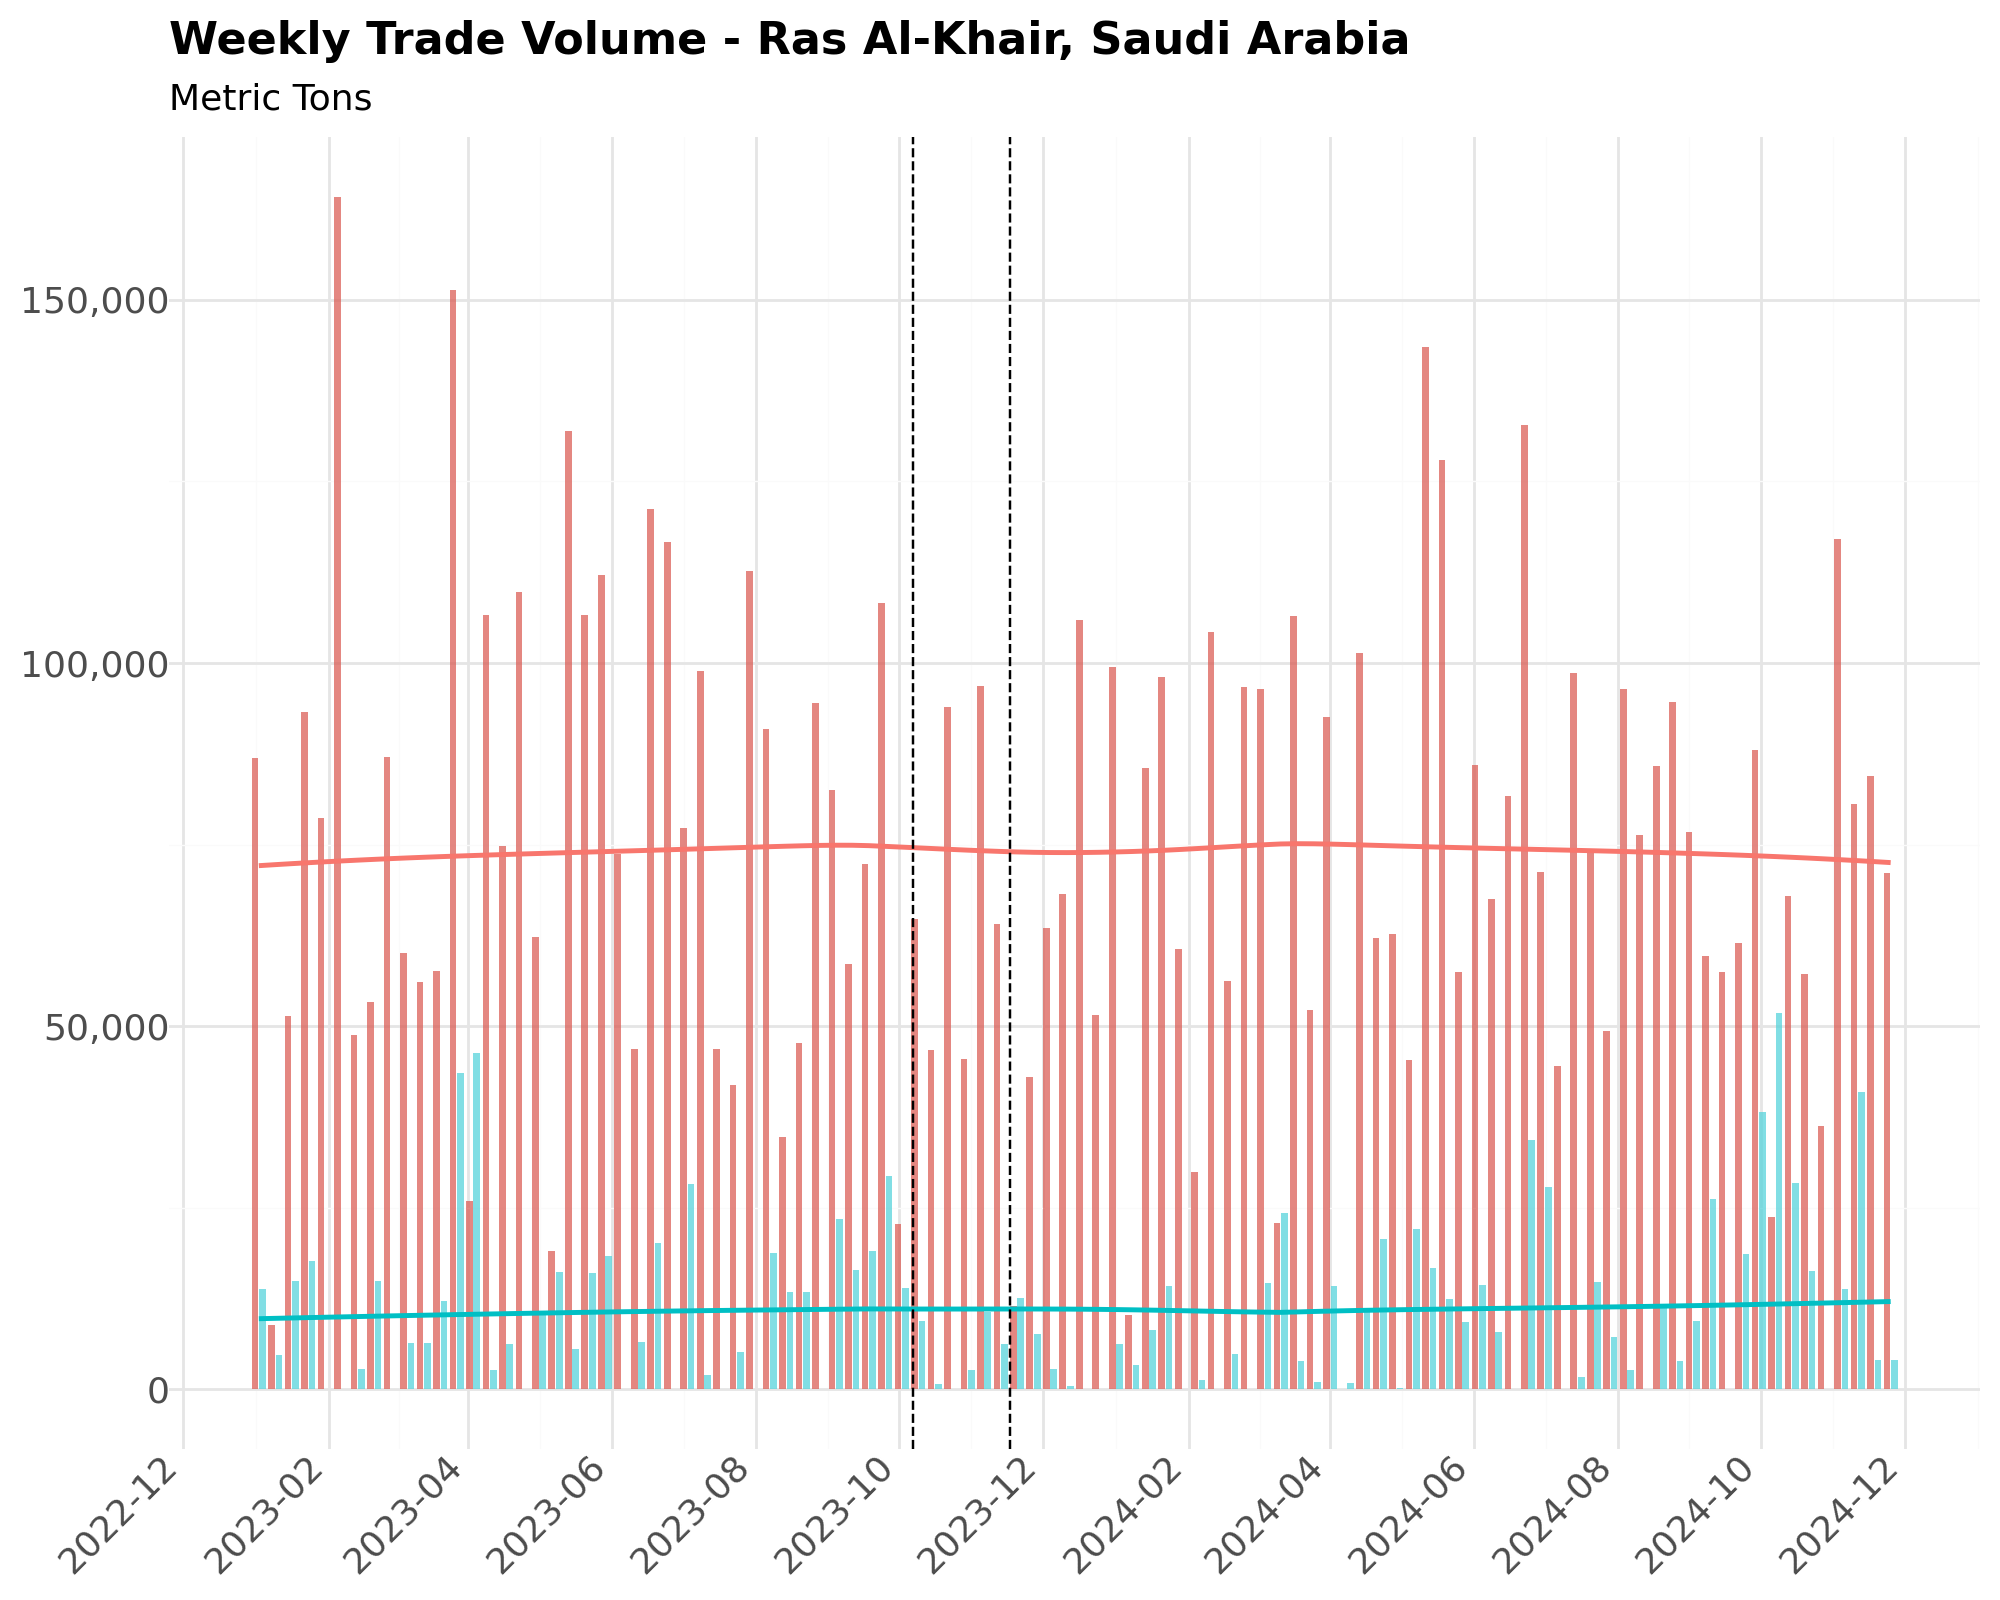

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


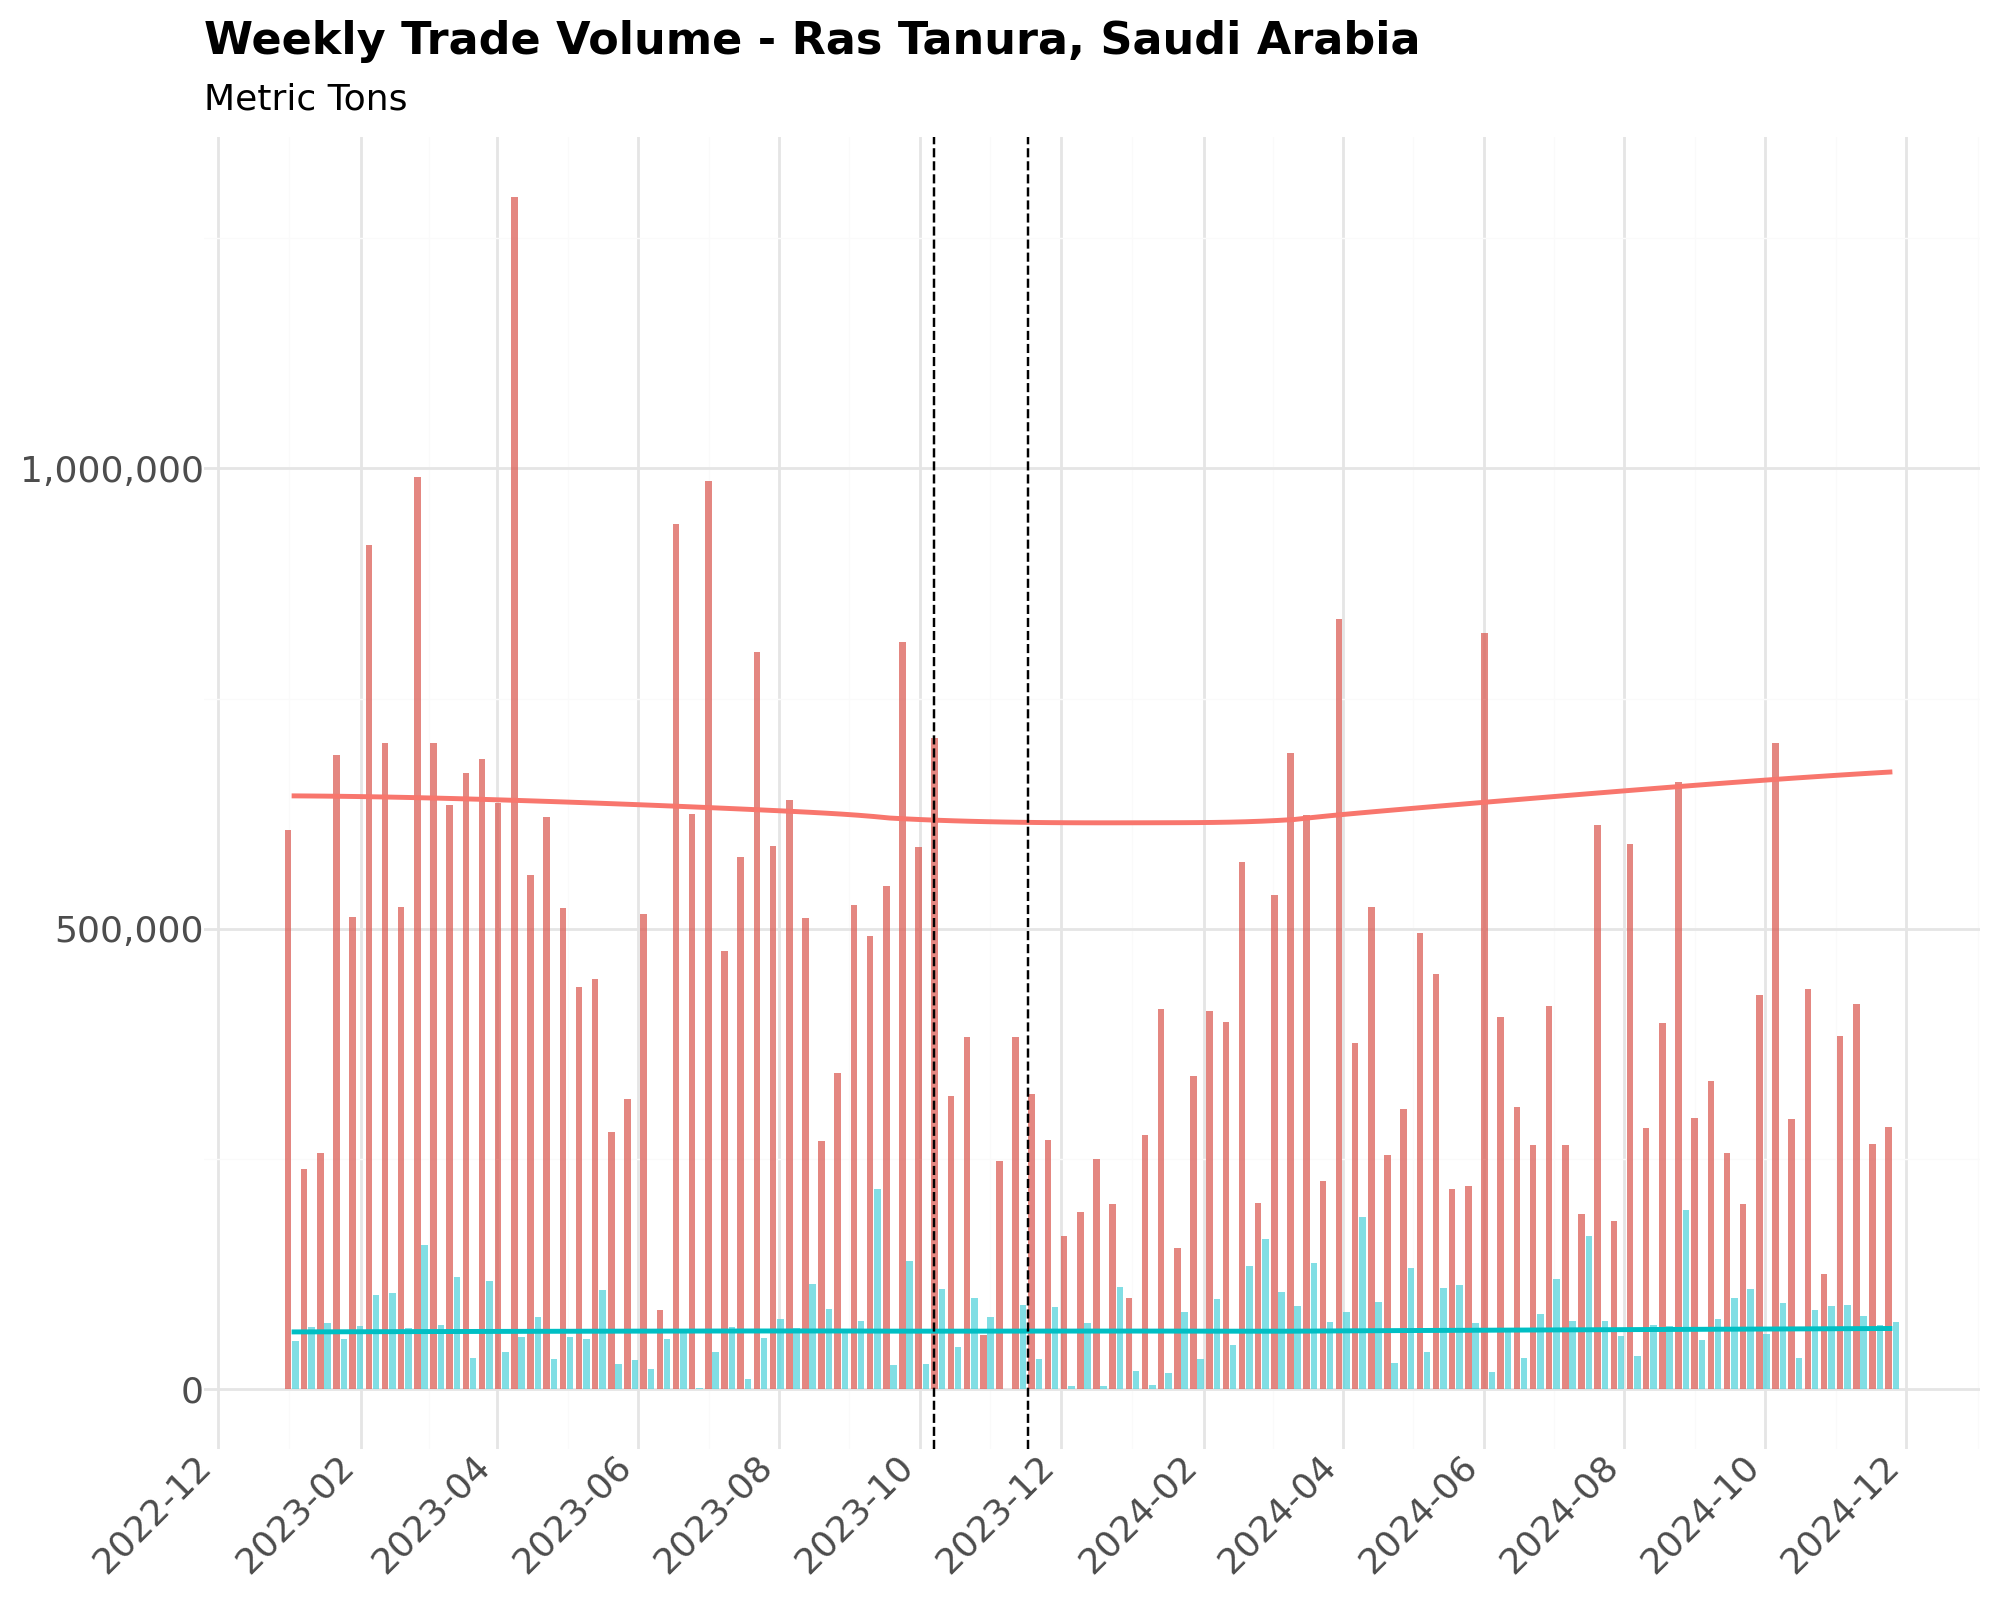

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


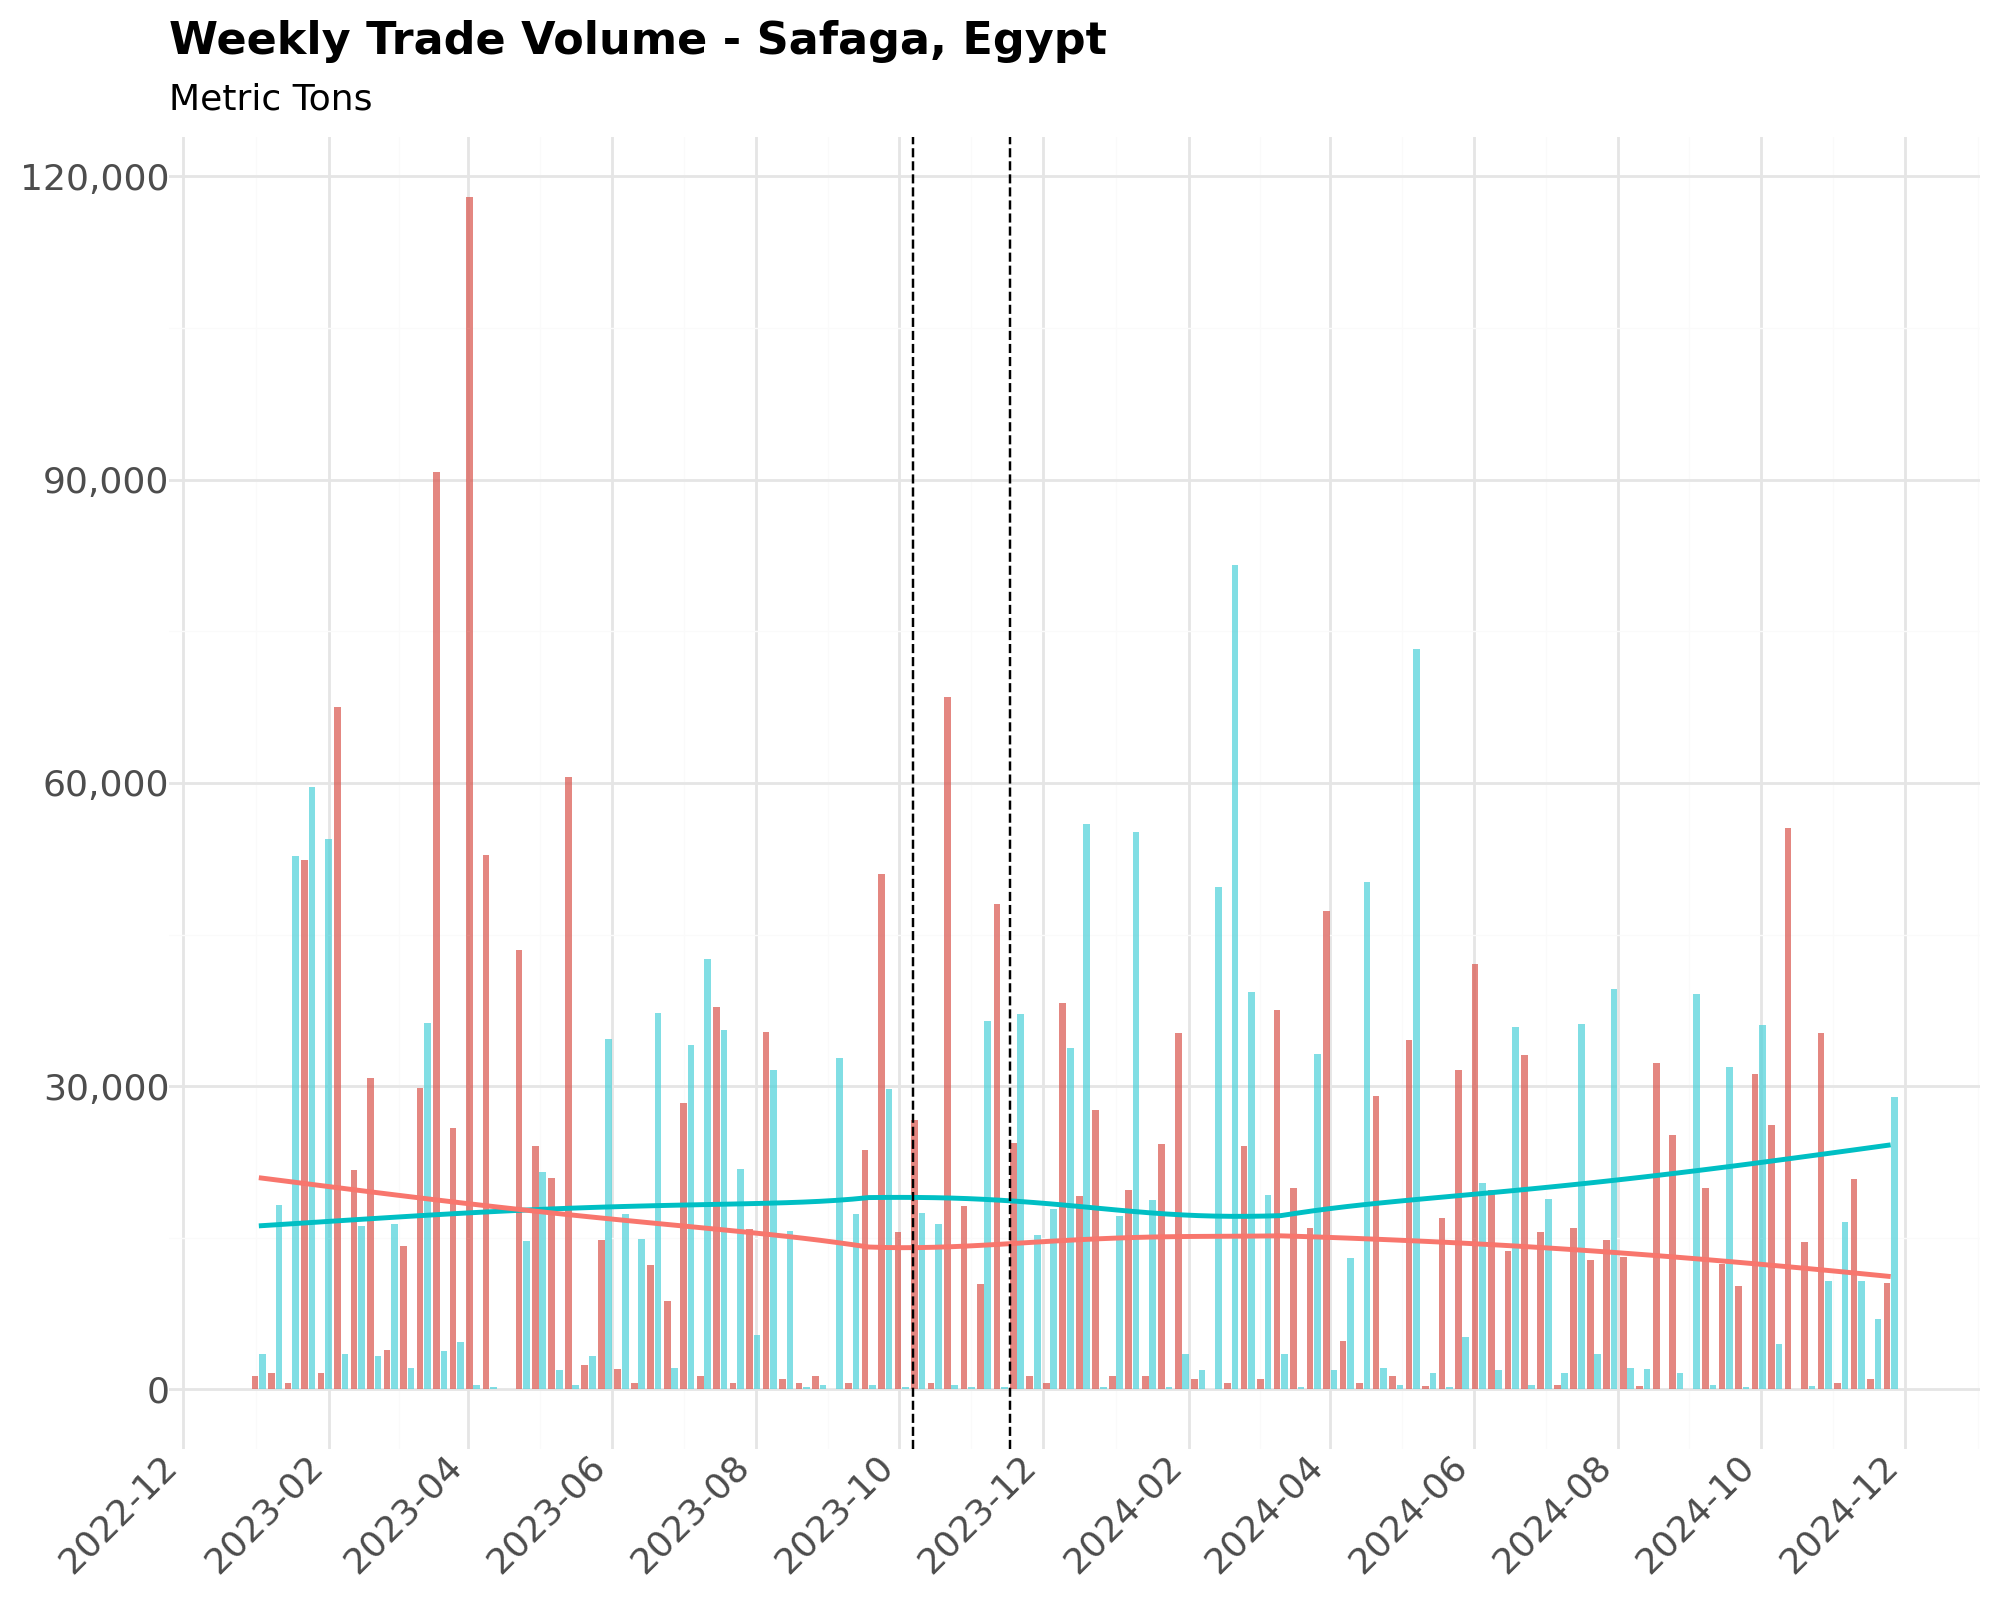

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


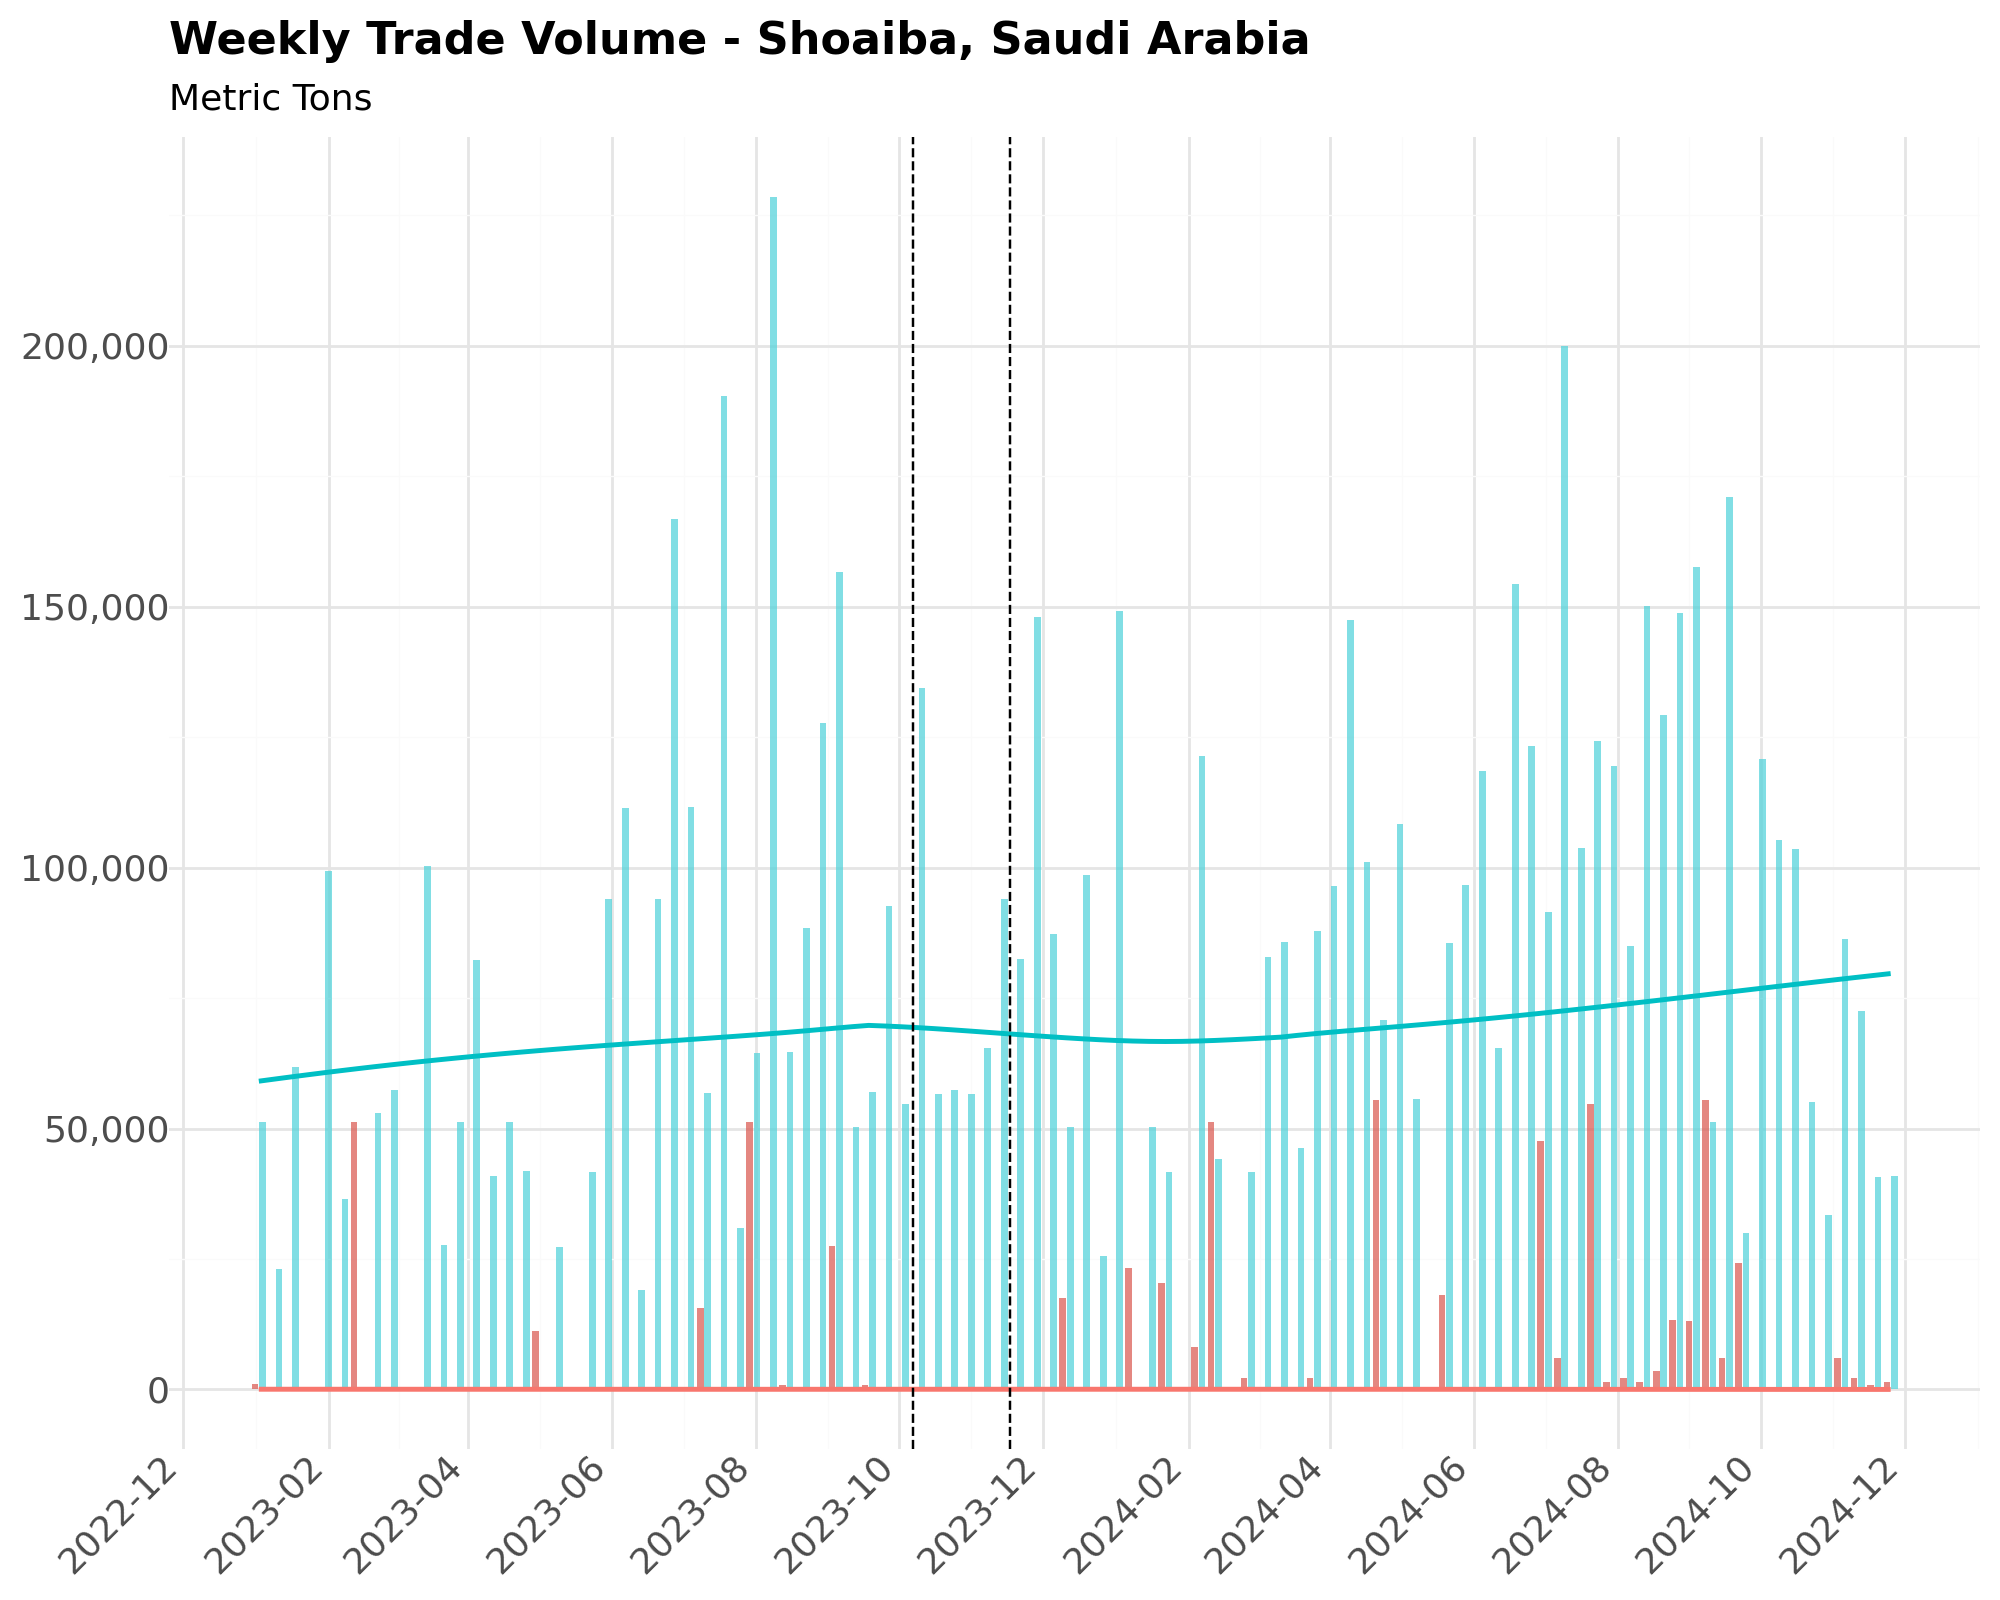

/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/home/sol/venv/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


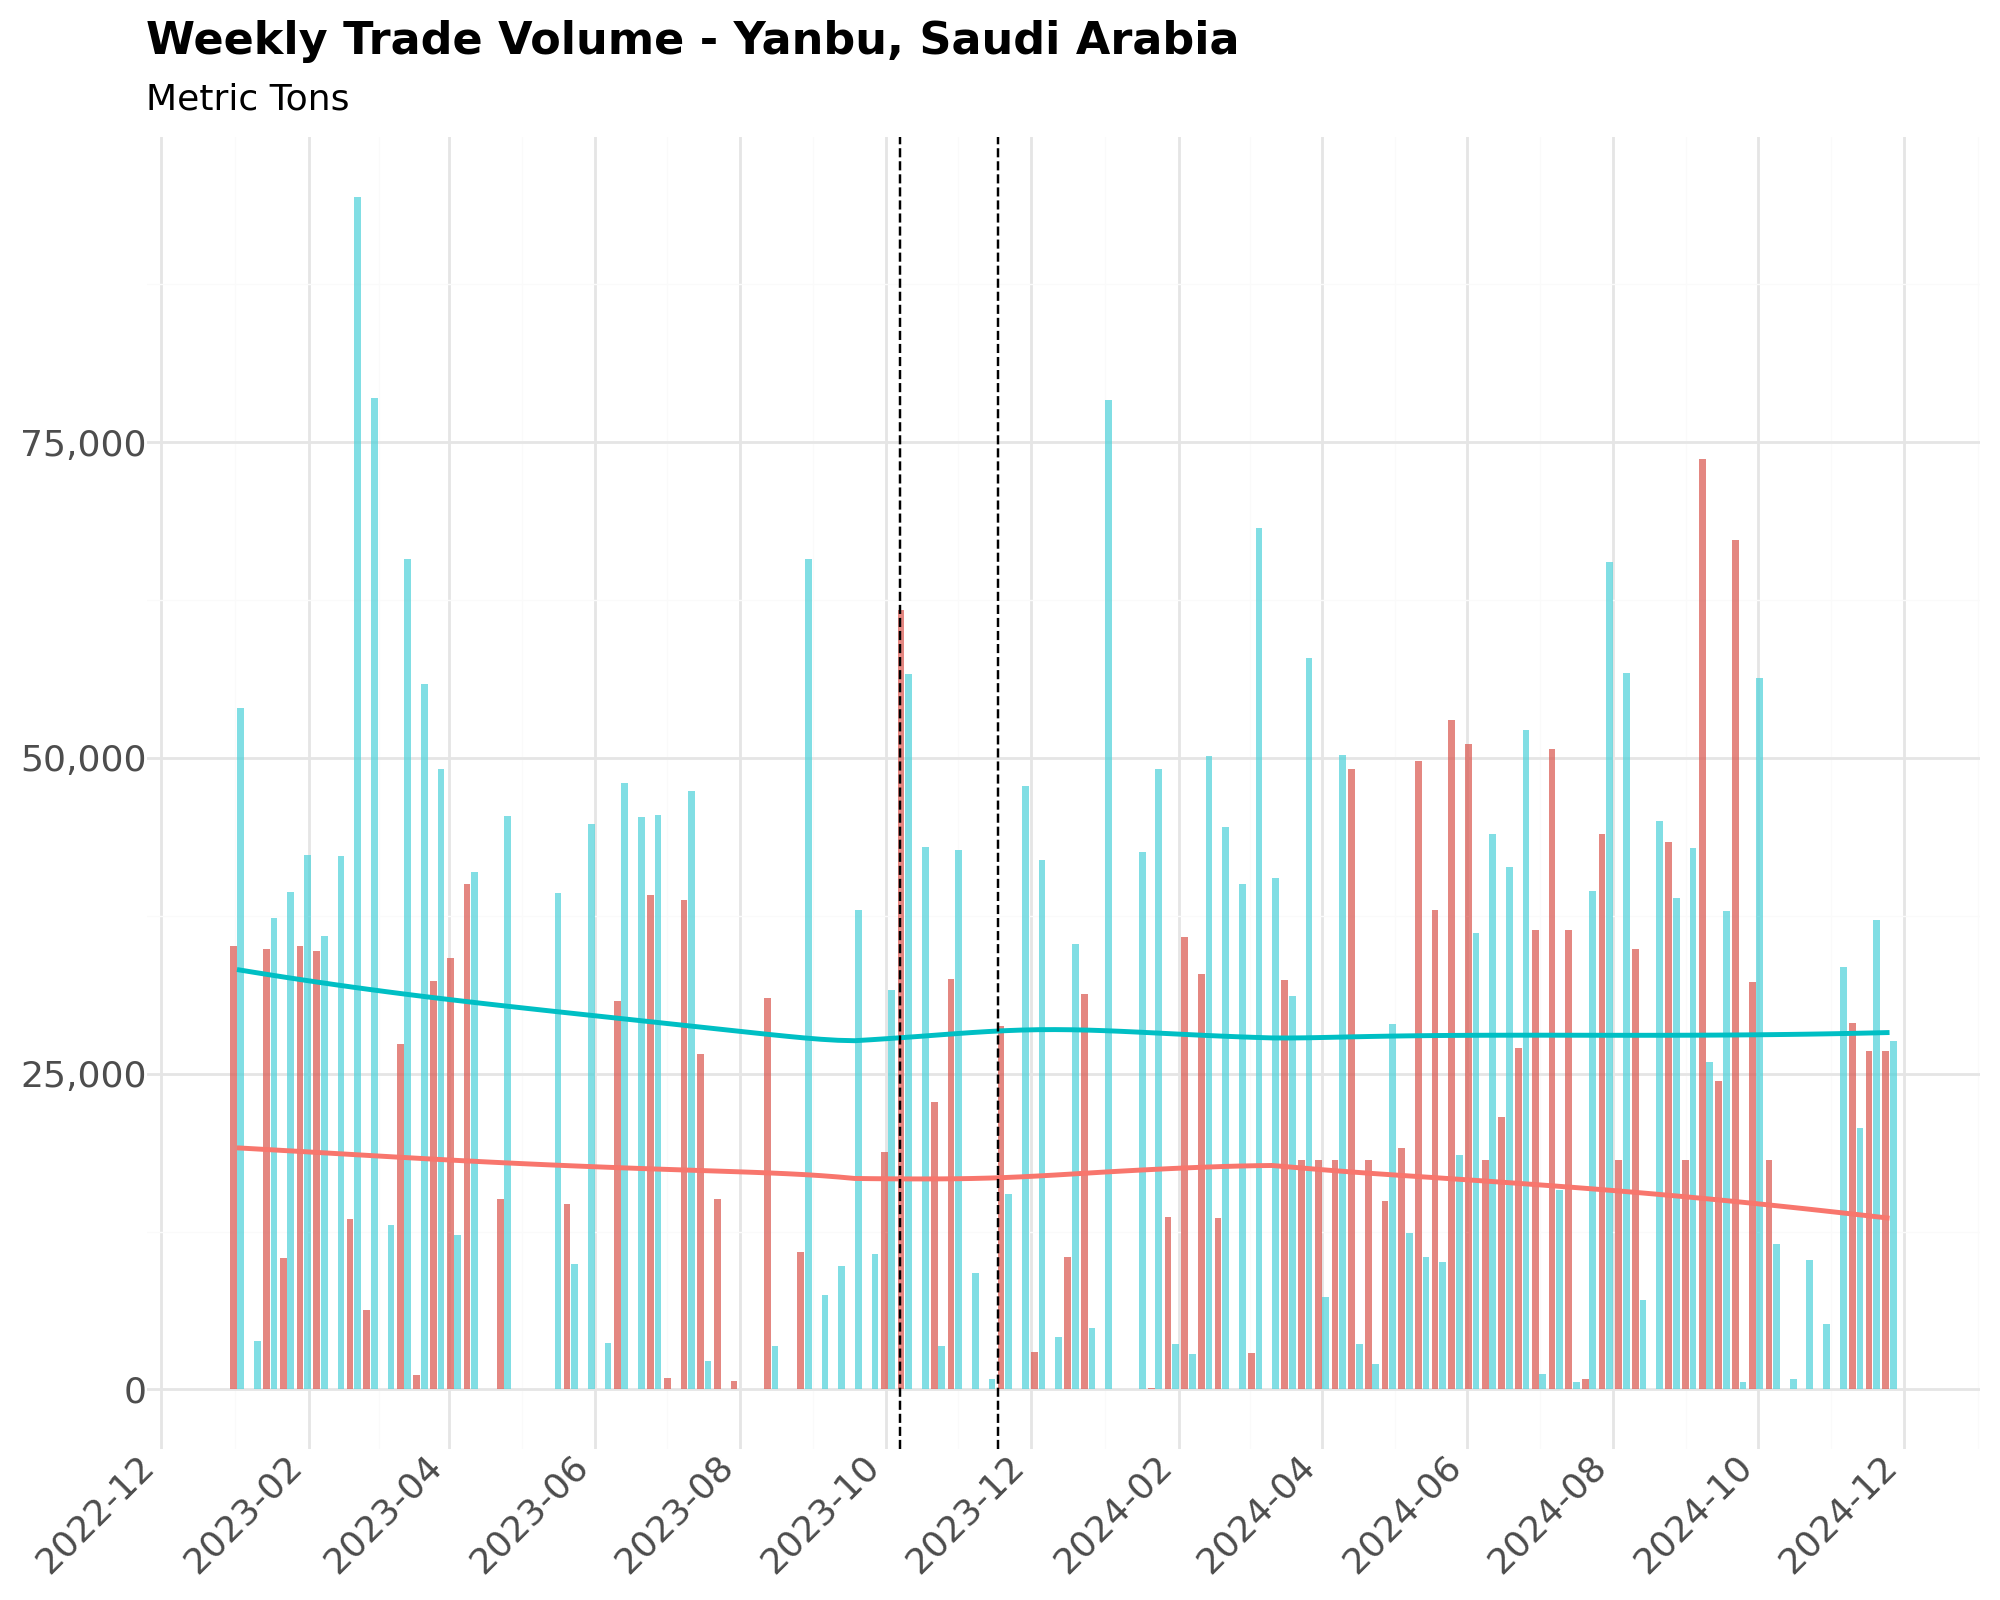

In [45]:
for port_id in df_filt.portid.unique():
    port_info = ports_red_sea.loc[ports_red_sea.portid == port_id].iloc[0]
    country = port_info.country
    df_port = df_filt.loc[df_filt.portid == port_id].copy()
    df_port_copy = df_port.copy()
    port = df_port_copy.iloc[0].portname
    df_port = df_port.melt(
        id_vars="date",
        value_vars=["import", "export"],
        var_name="direction",
        value_name="trade",
    )
    df_port.loc[:, "direction"] = df_port.direction.str.capitalize()
    p0 = (
        ggplot(df_port_copy, aes(x="date", y="import_ref"))  #
        + geom_bar(
            mapping=aes(x="date", y="trade", fill="direction"),
            data=df_port,
            alpha=3 / 4,
            stat="identity",
            position="dodge2",
        )
        + geom_smooth(
            mapping=aes(x="date", y="import_ref"), color="#00BFC4", size=1, alpha=3 / 4
        )
        + geom_smooth(
            mapping=aes(x="date", y="export_ref"), color="#F8766D", size=1, alpha=3 / 4
        )
        + geom_vline(xintercept=conflict_date, linetype="dashed", color="black")
        + geom_vline(xintercept=crisis_date, linetype="dashed", color="black")
        + labs(
            x="",
            y="",
            subtitle="Metric Tons",
            title=f"Weekly Trade Volume - {port}, {country}",
            fill="Trade Flow",
        )
        + theme_minimal()
        + theme(
            text=element_text(size=13),
            plot_title=element_text(size=16, weight="bold"),
            axis_text_x=element_text(rotation=45, hjust=1),
            legend_position="none",
        )
        + scale_x_datetime(breaks=date_breaks("2 month"), labels=date_format("%Y-%m"))
        + scale_y_continuous(labels=comma_format())
    )
    display(p0)